In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.patches as mpatches
import keras
import tensorflow as tf

2024-05-21 17:31:12.736585: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 17:31:12.788624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set matplotlib default color cycle
new_color_cycle = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#aec7e8',
    '#ffbb78',
    '#98df8a',
    '#ff9896',
    '#c5b0d5',
    '#c49c94',
    '#f7b6d2',
    '#c7c7c7',
    '#dbdb8d',
    '#9edae5'
]

# You can then apply this new color cycle to your matplotlib plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=new_color_cycle)

In [3]:
# This is the list that will hold all of the data (data22 and MC)

datasets = {}
pass_HLT = {}
pass_L1 = {}
weights = {}

## Collect Data

In [4]:
# Read EB file
with h5py.File('../../../../ntuples/AOD_EB_ntuples_04-10-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

# Concatenate HLT data
HLT_objects = np.concatenate([HLT_jets, HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)

# Indices of events that passed L1
pass_L1_idxs = (pass_L1_unprescaled == 1)

# Indices of events that passed HLT
pass_HLT_idxs = (pass_HLT_unprescaled == 1)

# Append to datasets
datasets['HLT_data'] = HLT_objects[pass_L1_idxs][:, :, [0, 2, 3]]
weights['HLT_data'] = EB_weights[pass_L1_idxs]
pass_L1['HLT_data'] = pass_L1_idxs[pass_L1_idxs]
pass_HLT['HLT_data'] = pass_HLT_idxs[pass_L1_idxs]

datasets['L1_data'] = L1_objects[pass_L1_idxs]
weights['L1_data'] = EB_weights[pass_L1_idxs]
pass_L1['L1_data'] = pass_L1_idxs[pass_L1_idxs]
pass_HLT['L1_data'] = pass_HLT_idxs[pass_L1_idxs]

datasets['HLT_zerobias'] = HLT_objects[~pass_L1_idxs][:, :, [0, 2, 3]]
weights['HLT_zerobias'] = EB_weights[~pass_L1_idxs]
pass_L1['HLT_zerobias'] = pass_L1_idxs[~pass_L1_idxs]
pass_HLT['HLT_zerobias'] = pass_HLT_idxs[~pass_L1_idxs]

datasets['L1_zerobias'] = L1_objects[~pass_L1_idxs]
weights['L1_zerobias'] = EB_weights[~pass_L1_idxs]
pass_L1['L1_zerobias'] = pass_L1_idxs[~pass_L1_idxs]
pass_HLT['L1_zerobias'] = pass_HLT_idxs[~pass_L1_idxs]

datasets['HLT_passedHLT'] = HLT_objects[pass_HLT_idxs][:, :, [0, 2, 3]]
weights['HLT_passedHLT'] = EB_weights[pass_HLT_idxs]
pass_L1['HLT_passedHLT'] = pass_L1_idxs[pass_HLT_idxs]
pass_HLT['HLT_passedHLT'] = pass_HLT_idxs[pass_L1_idxs]

datasets['L1_passedHLT'] = L1_objects[pass_HLT_idxs]
weights['L1_passedHLT'] = EB_weights[pass_HLT_idxs]
pass_L1['L1_passedHLT'] = pass_L1_idxs[pass_HLT_idxs]
pass_HLT['L1_passedHLT'] = pass_HLT_idxs[pass_L1_idxs]

In [5]:
# Read MC data. Remove E.

filenames = ['Ztautau',
             #'HHbbttHadHad.h5', 
             'ZZ4lep',  
             #'jjJZ4.h5', 
             #'jjJZ2.h5', 
             'qqa', 
             'HNL7p5_ctau1_eemu',
             'Zprime2EJs',
             'HAHMggfZdZd2l2nu']
data_path = '../../../../ntuples/MC/'

for filename in filenames:
    with h5py.File(data_path+filename+'.h5', 'r') as hf:
        jets = hf['HLT_jets'][:]
        electrons = hf['electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        muons = hf['muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        pass_HLT_unprescaled = hf['pass_HLT_unprescaled'][:]
        # Indices of events that passed L1
        pass_L1_idxs = (pass_L1_unprescaled == 1)
        
        # Indices of events that passed HLT
        pass_HLT_idxs = (pass_HLT_unprescaled == 1)

        combined_data = np.concatenate([jets, electrons, muons, photons, MET], axis=1)
        datasets['HLT_'+filename] = combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]]
        pass_HLT['HLT_'+filename] = pass_HLT_idxs[0:min(len(combined_data), 100000)]
        pass_L1['HLT_'+filename] = pass_L1_idxs[0:min(len(combined_data), 100000)]
        weights['HLT_'+filename] = np.ones(min(len(combined_data), 100000))

In [6]:
# Read other MC data.

filenames = ['HHbbttHadHad',   
             'jjJZ4', 
             'jjJZ2'
            ]
data_path = '../../../../ntuples/L1_MC/'

for filename in filenames:
    with h5py.File(data_path+'HLT_'+filename+'_04-24-2024.h5', 'r') as hf:
        HLT_jets = hf['HLT_jets'][:]
        L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
        L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
        HLT_electrons = hf['HLT_electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        L1_egammas = hf['L1_egammas'][:]
        HLT_muons = hf['HLT_muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        L1_muons = hf['L1_muons'][:]
        L1_eFex_taus = hf['L1_eFex_taus'][:]
        L1_jFex_taus = hf['L1_jFex_taus'][:]
        HLT_photons = hf['HLT_photons'][:]
        HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]

        # Indices of events that passed L1
        pass_L1_idxs = (pass_L1_unprescaled == 1)
        
        # Indices of events that passed HLT
        pass_HLT_idxs = (pass_HLT_unprescaled == 1)

        HLT_combined_data = np.concatenate([HLT_jets, HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
        datasets['HLT_'+filename] = HLT_combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]]
        pass_HLT['HLT_'+filename] = pass_HLT_idxs[0:min(len(combined_data), 100000)]
        pass_L1['HLT_'+filename] = pass_L1_idxs[0:min(len(combined_data), 100000)]
        weights['HLT_'+filename] = np.ones(min(len(combined_data), 100000))

        L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)
        datasets['L1_'+filename] = L1_objects
        weights['L1_'+filename] = np.ones(len(L1_objects))
        pass_L1['L1_'+filename] = pass_L1_idxs
        pass_HLT['L1_'+filename] = pass_HLT_idxs

In [7]:
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (219467, 20, 3)
L1_data: (219467, 20, 3)
HLT_zerobias: (777848, 20, 3)
L1_zerobias: (777848, 20, 3)
HLT_passedHLT: (7850, 20, 3)
L1_passedHLT: (7850, 20, 3)
HLT_Ztautau: (100000, 20, 3)
HLT_ZZ4lep: (100000, 20, 3)
HLT_qqa: (50000, 20, 3)
HLT_HNL7p5_ctau1_eemu: (10000, 20, 3)
HLT_Zprime2EJs: (100000, 20, 3)
HLT_HAHMggfZdZd2l2nu: (70000, 20, 3)
HLT_HHbbttHadHad: (70000, 20, 3)
L1_HHbbttHadHad: (100000, 20, 3)
HLT_jjJZ4: (70000, 20, 3)
L1_jjJZ4: (100000, 20, 3)
HLT_jjJZ2: (70000, 20, 3)
L1_jjJZ2: (100000, 20, 3)


In [8]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for tag, data in datasets.items():

    # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
    MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
    MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
    MET_nan = np.isnan(data[:, 19, 2])
    data[MET_zeros, 19, 0] = 0.001
    data[MET_999, 19, :] = 0
    data[MET_nan, 19, :] = 0

In [9]:
"""Multiply the et of the L1 muons by 1000 to get them into the right units."""
for tag, data in datasets.items():
    if tag.startswith('L1'):
        data[:, 13:16, 0] *= 1000

## Make plots of the data

In [10]:
def plot_kinematics(datasets, weights, var='pt', object='jets'):
    '''Plots a histogram of the variable 'var' across 'object's in 'data'.
    var: should be either 'pt', 'eta', or 'phi'.
    object: should be either 'jets', 'electrons', 'photons', 'muons', or 'MET'.
    label: what the call the histogram in the legend.'''
    plt.figure(figsize=(14, 8))
    plt.rcParams['axes.linewidth'] = 2.4
    
    bins = {'pt': np.linspace(0, 2000, 35),
            'eta': np.linspace(-5, 5, 35),
            'phi': np.linspace(-np.pi, np.pi, 35)}

    idx_1 = {'jets': 0,
            'electrons': 10,
            'muons': 13,
            'photons': 16,
            'MET': 19}

    idx_2 = {'pt': 0,
            'eta': 1,
            'phi': 2}

    for tag, data in datasets.items():
        var_data = data[:, idx_1[object], idx_2[var]]
        mask = data[:, idx_1[object], 0] > 0 # require that the event has at least one of the given object
        plt.hist(var_data[mask], bins=bins[var], label=tag, histtype='step', density=True, fill=False, linewidth=3, weights=weights[tag][mask])

    plt.yscale('log')
    plt.xlabel(f'{object} {var}', fontsize=22)
    plt.ylabel('density', fontsize=22)
    plt.title(f'Leading {object} {var}', fontsize=30)
    plt.grid()
    plt.legend(fontsize=18, bbox_to_anchor=(1, 0.5), loc='center left')
    plt.show()

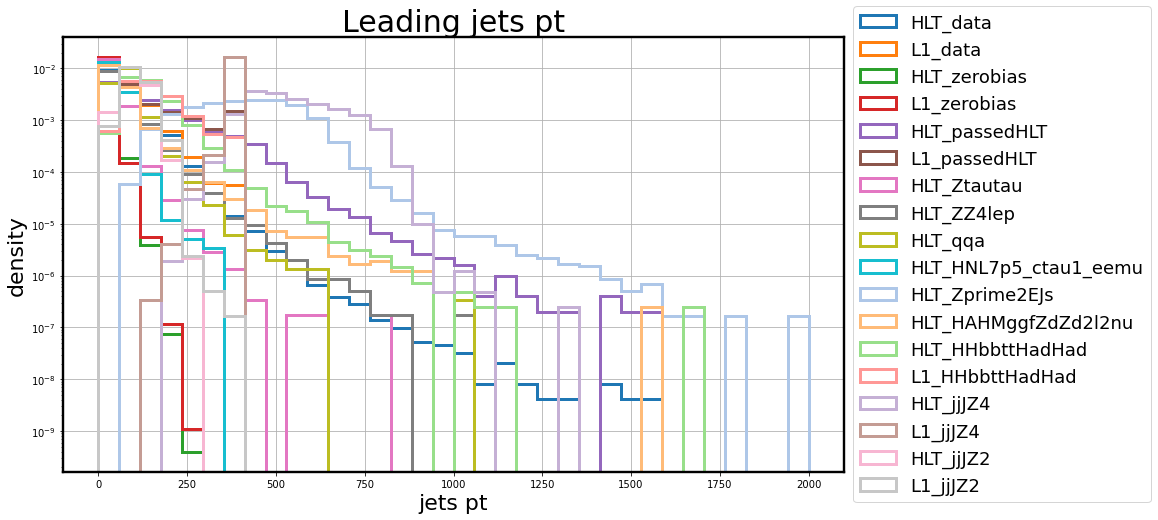

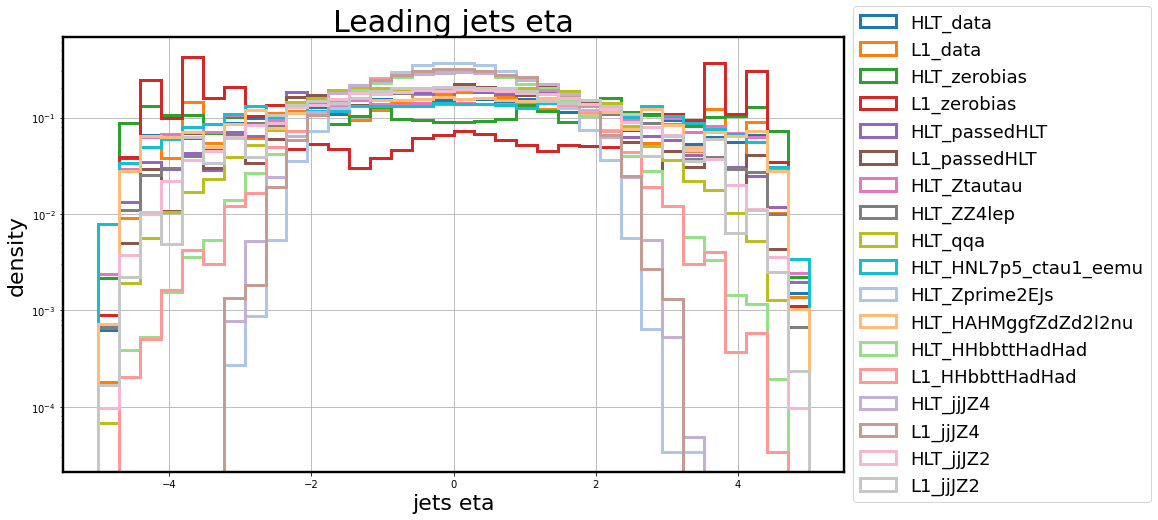

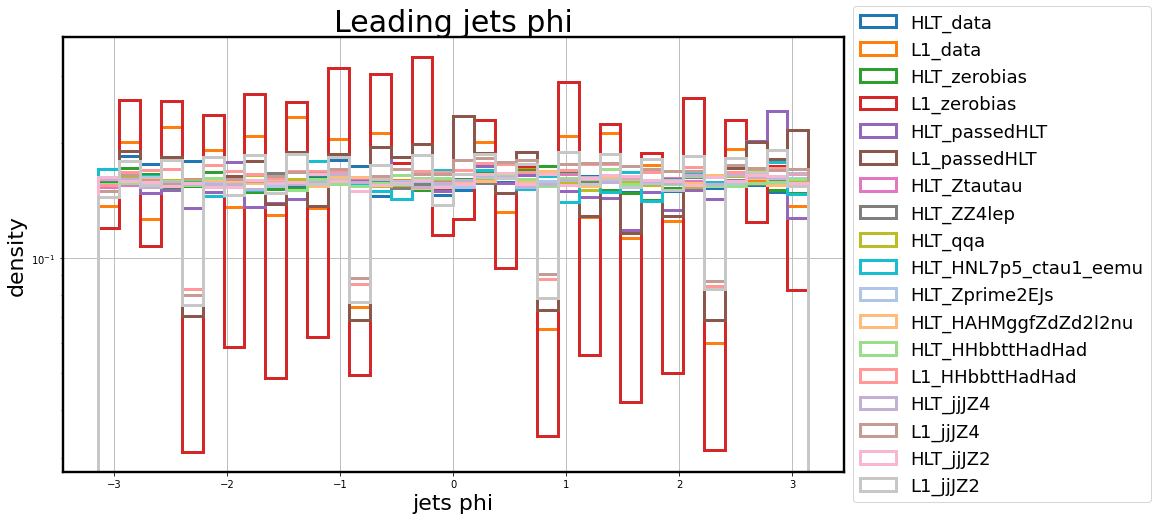

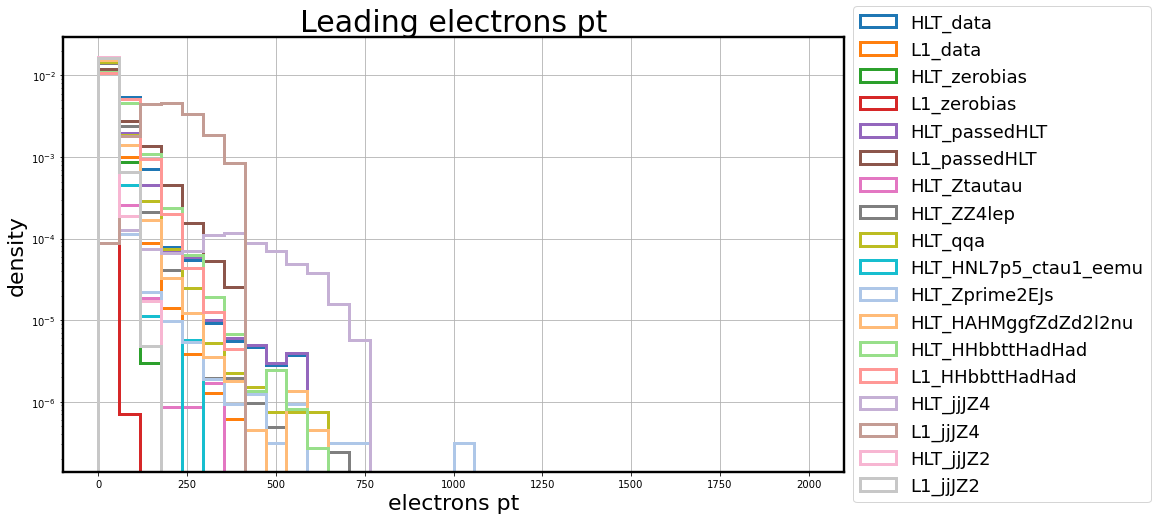

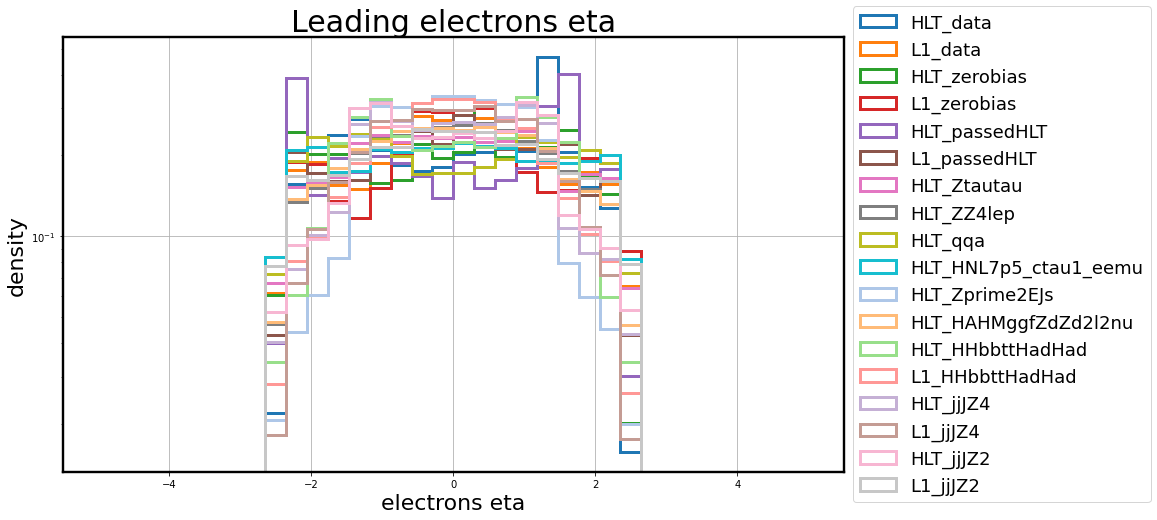

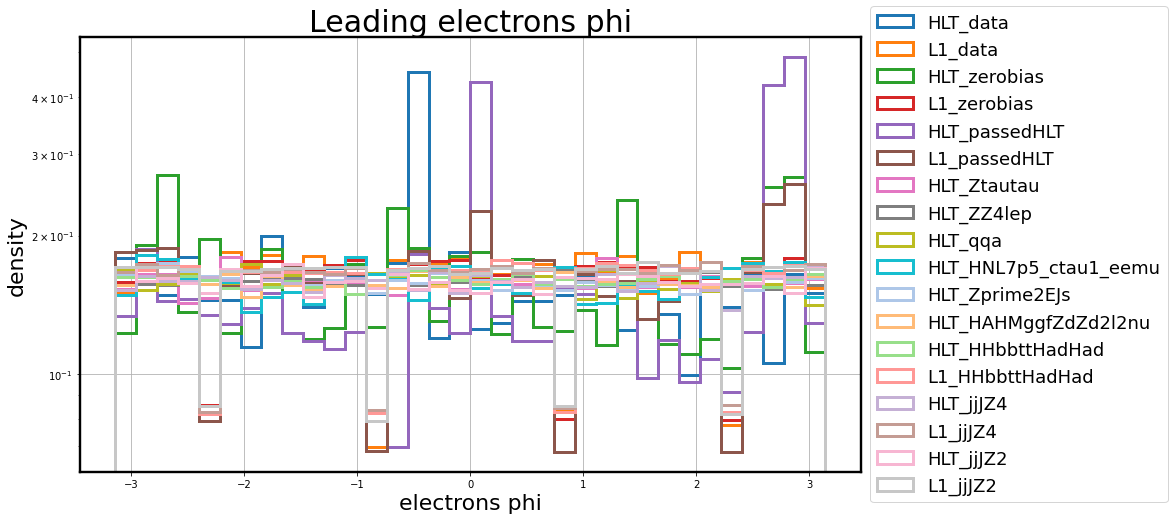

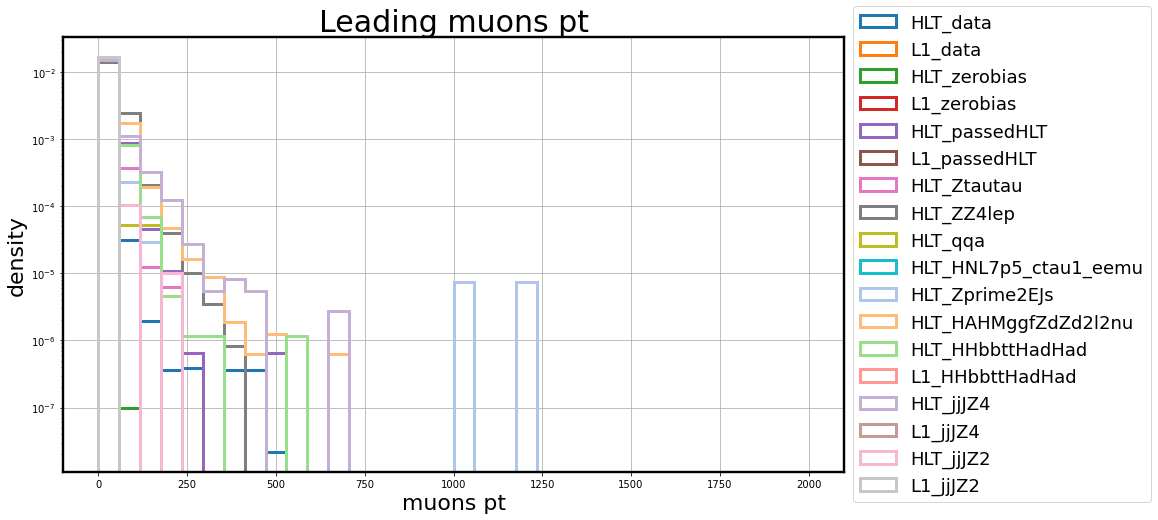

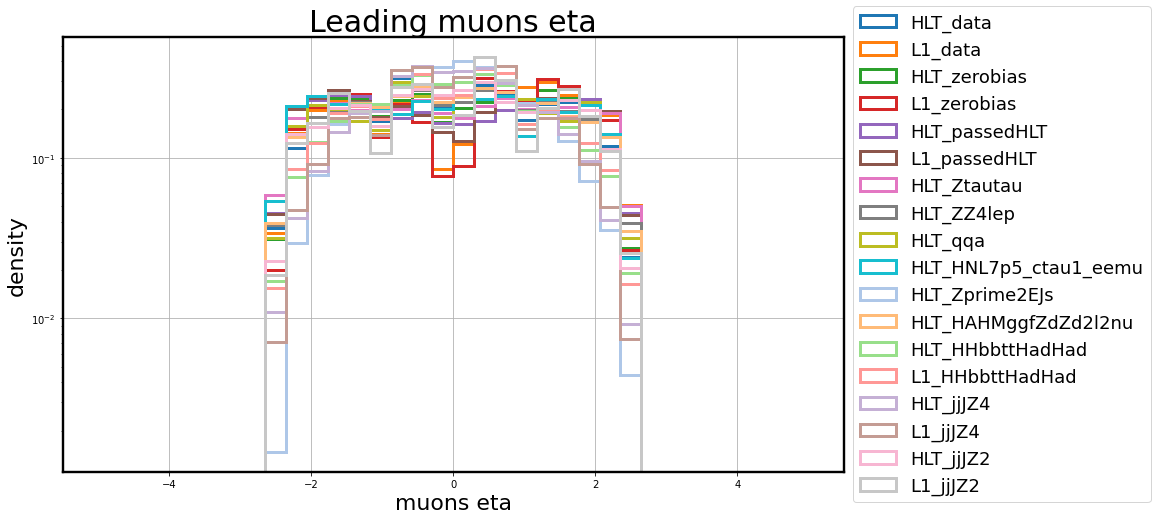

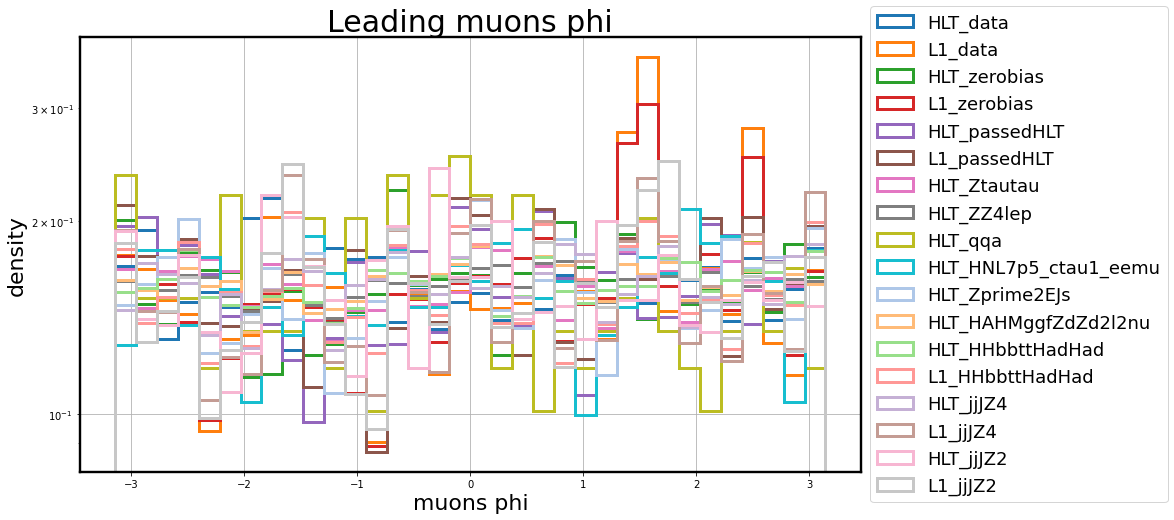

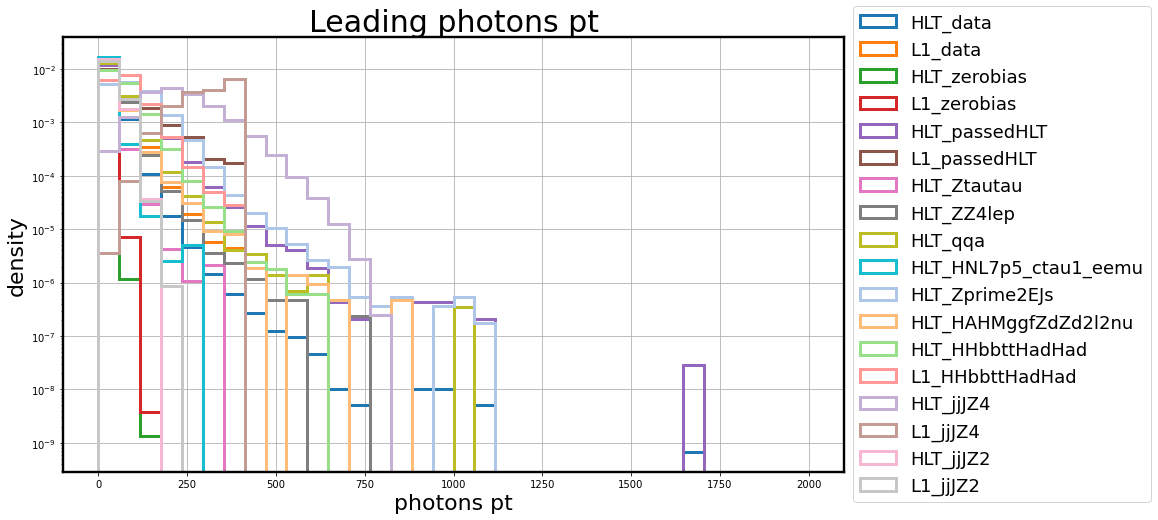

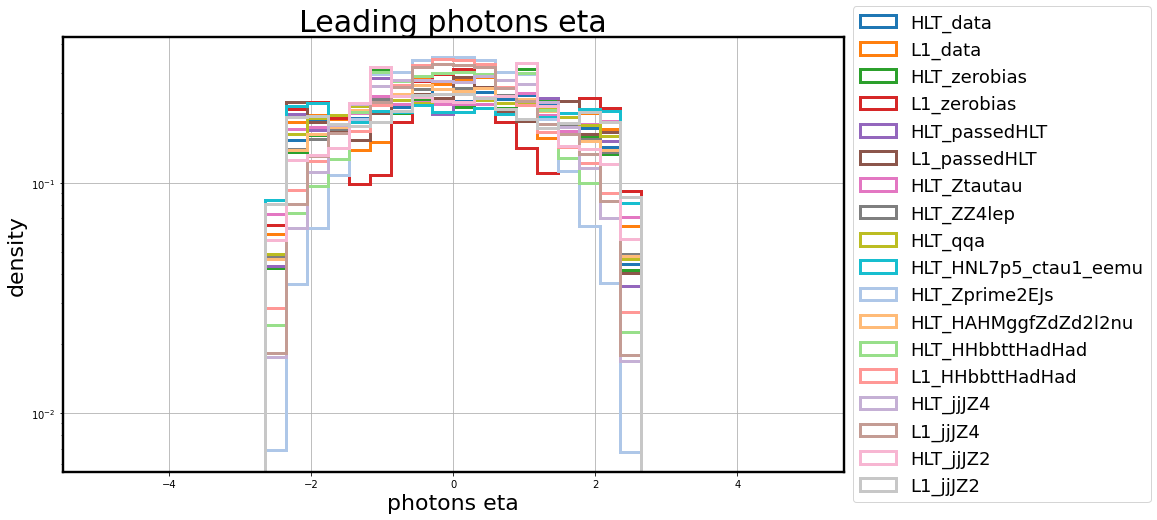

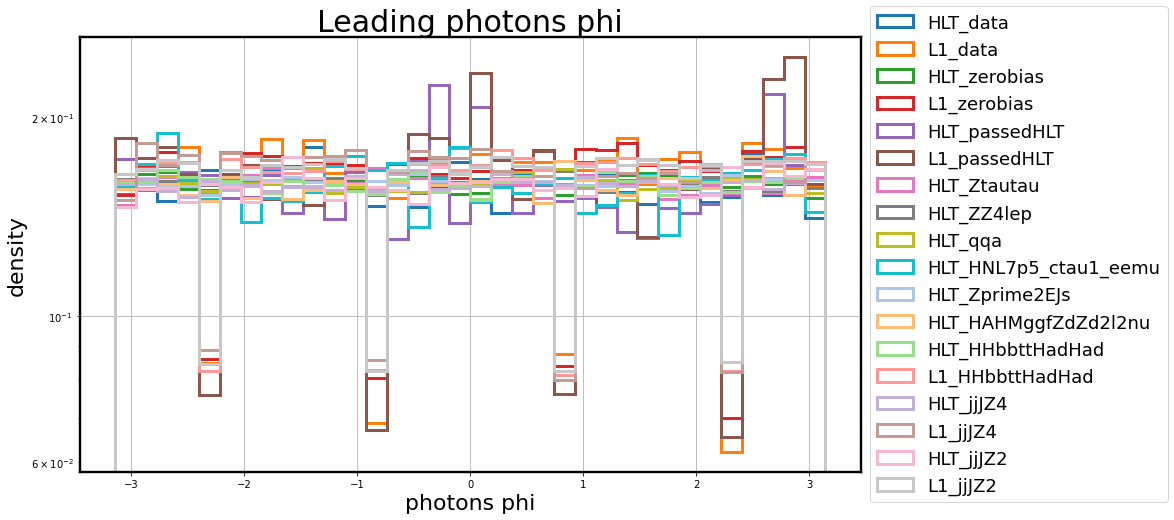

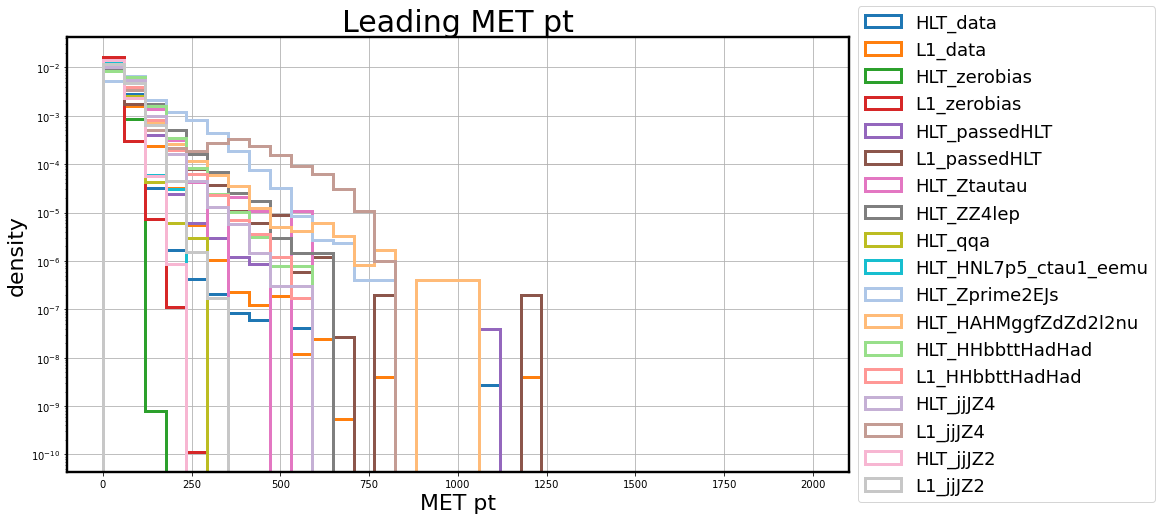

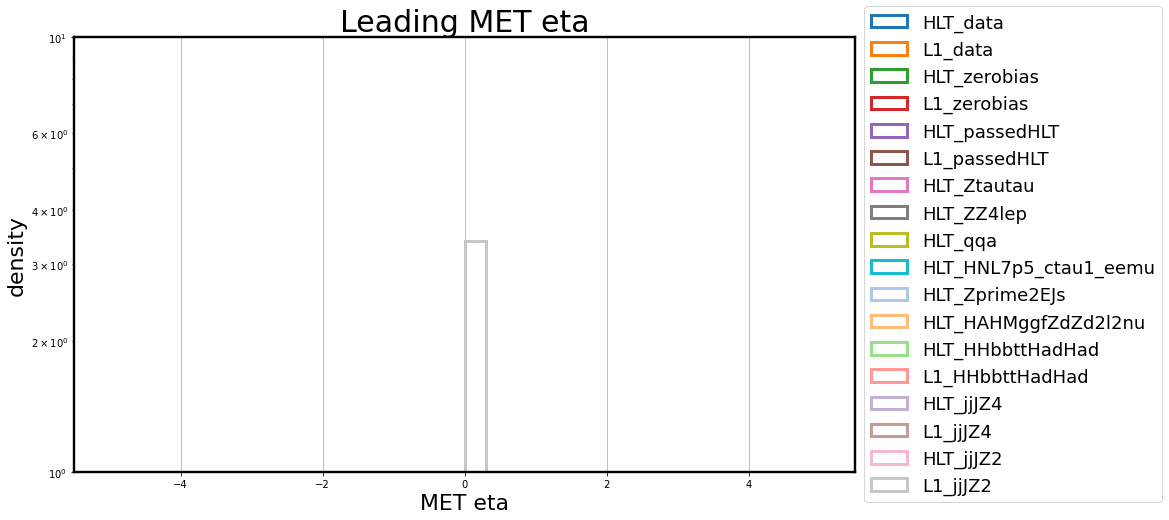

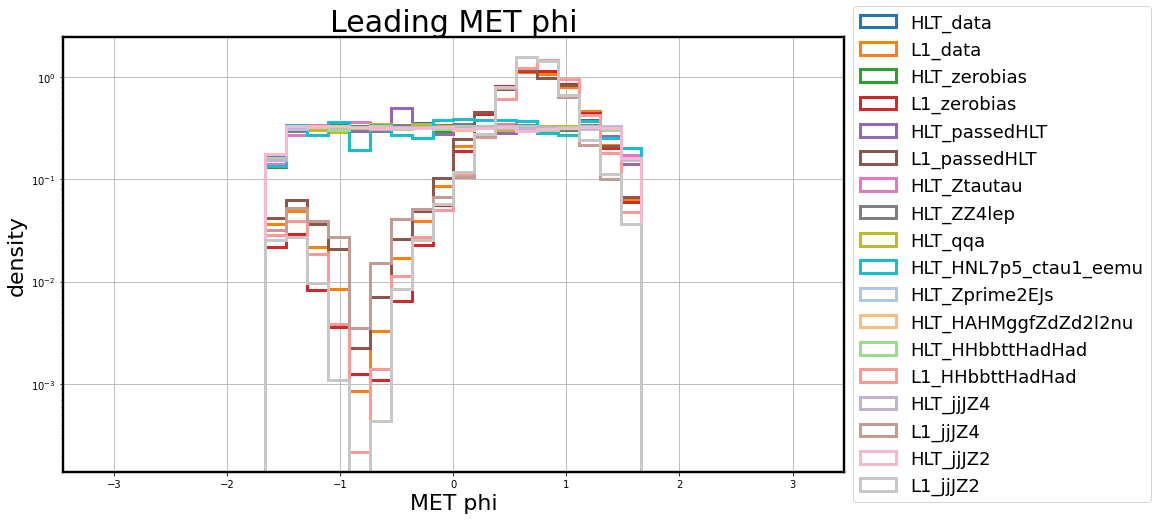

In [11]:
for object in ['jets', 'electrons', 'muons', 'photons', 'MET']:
    for var in ['pt', 'eta', 'phi']:
        plot_kinematics(datasets=datasets, weights=weights, object=object, var=var)

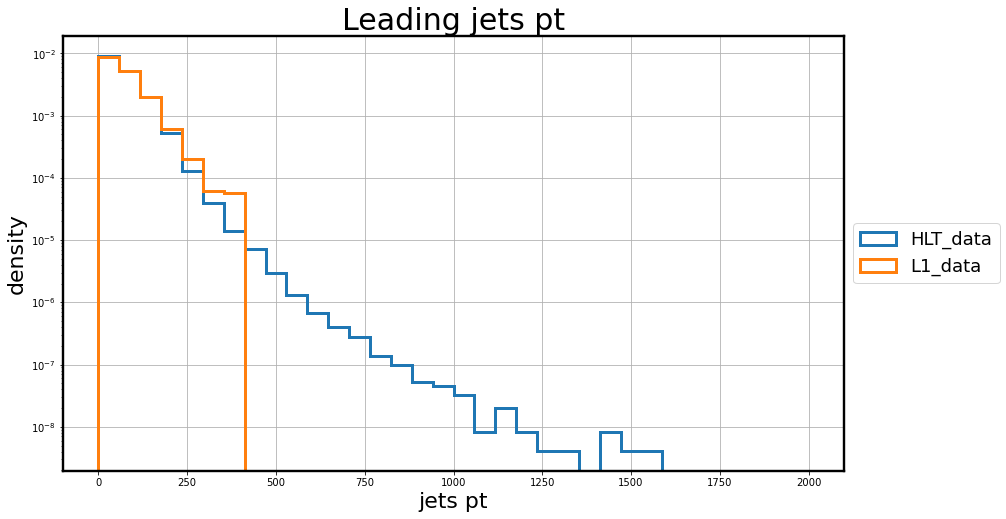

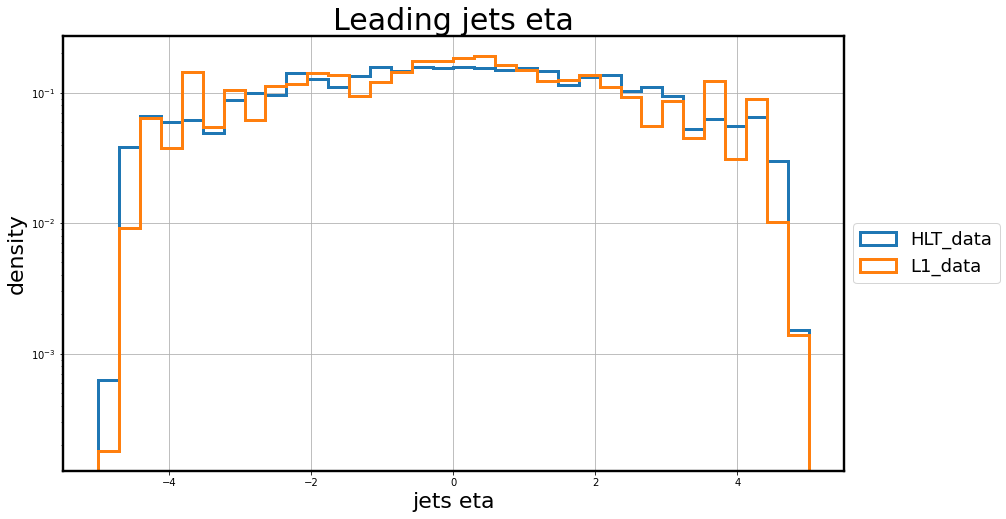

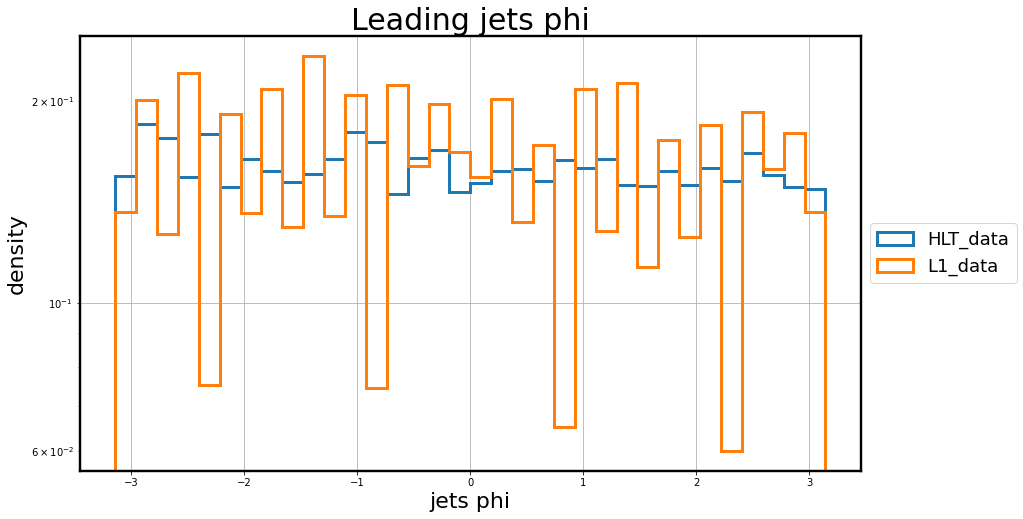

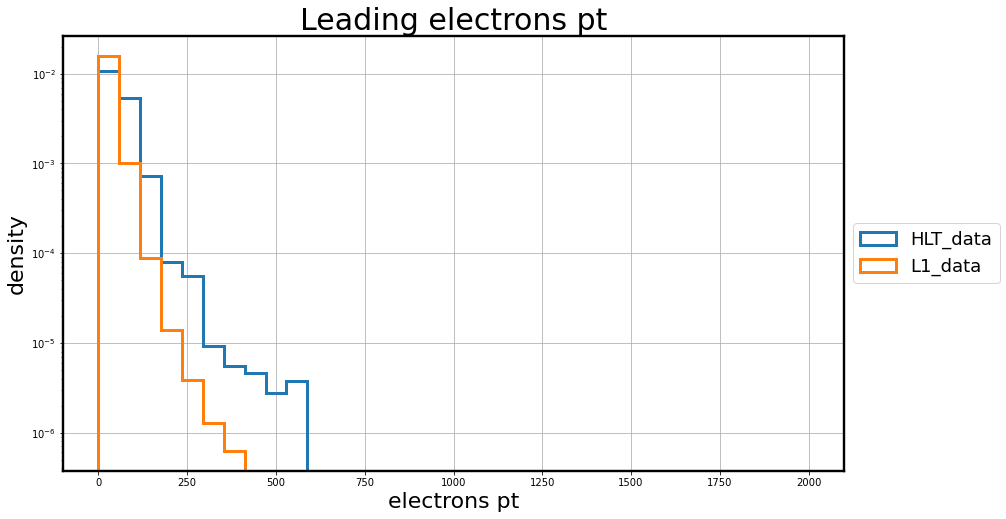

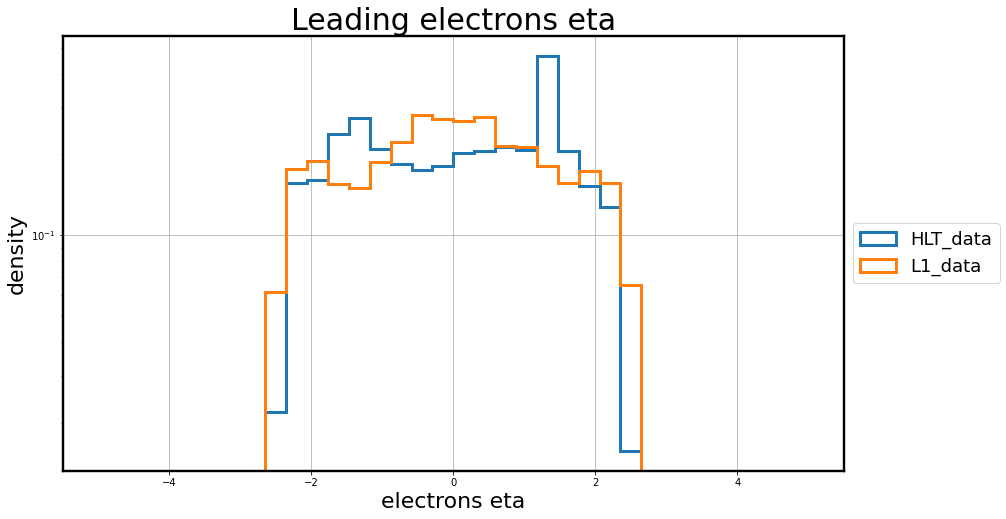

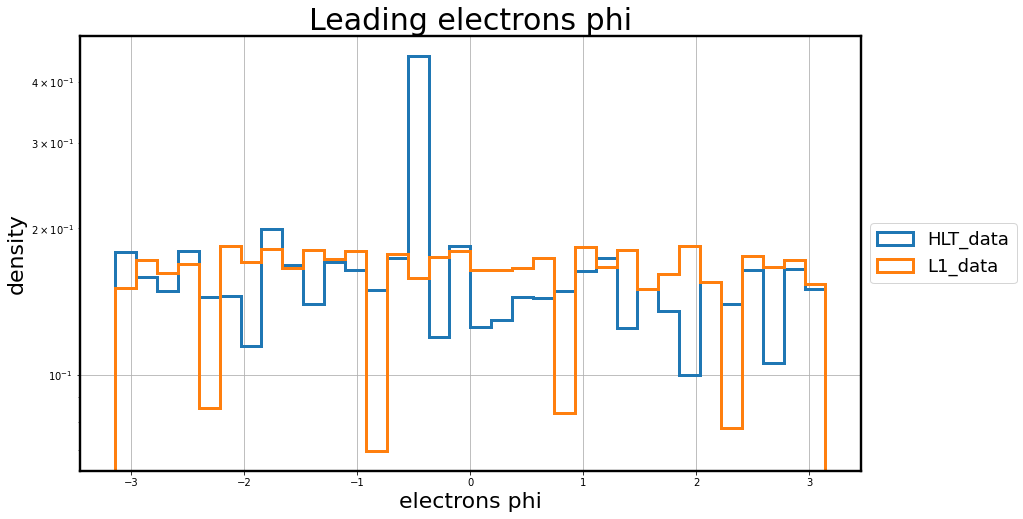

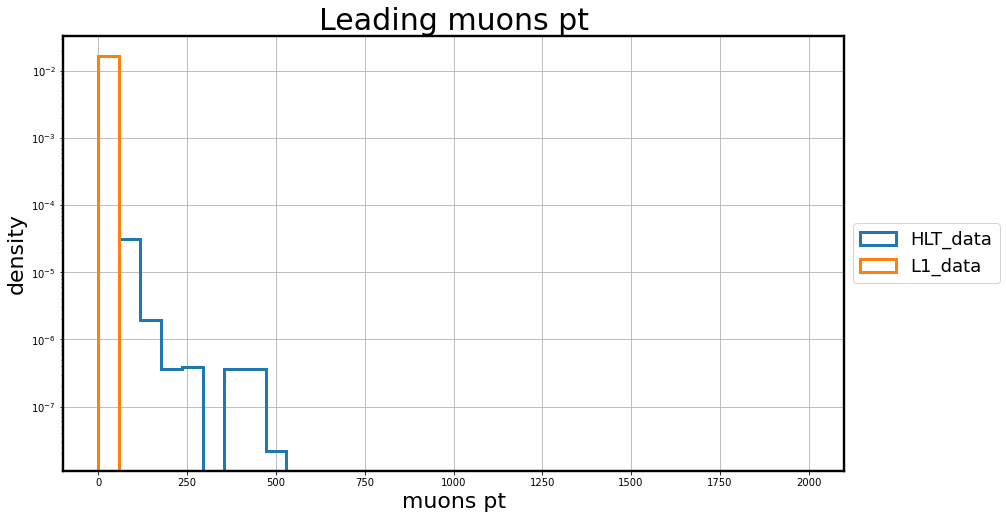

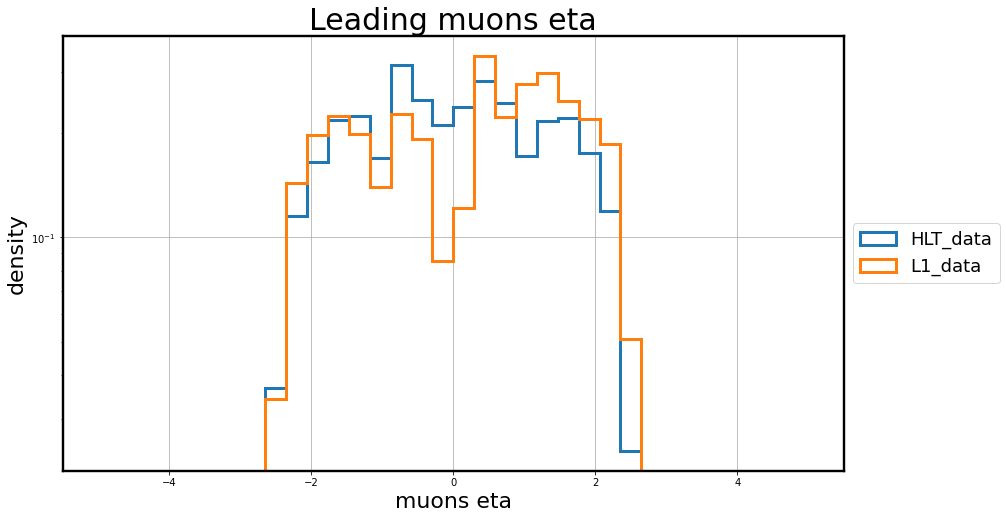

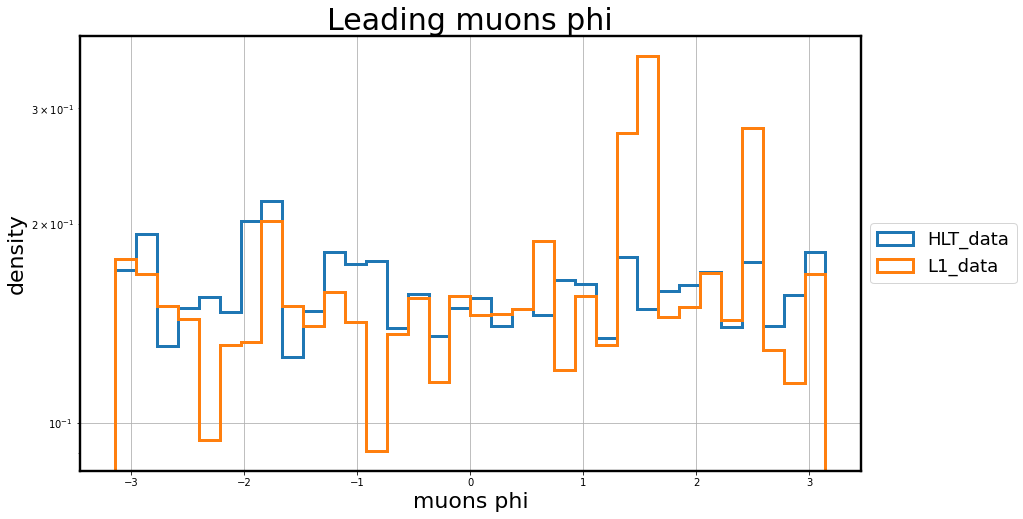

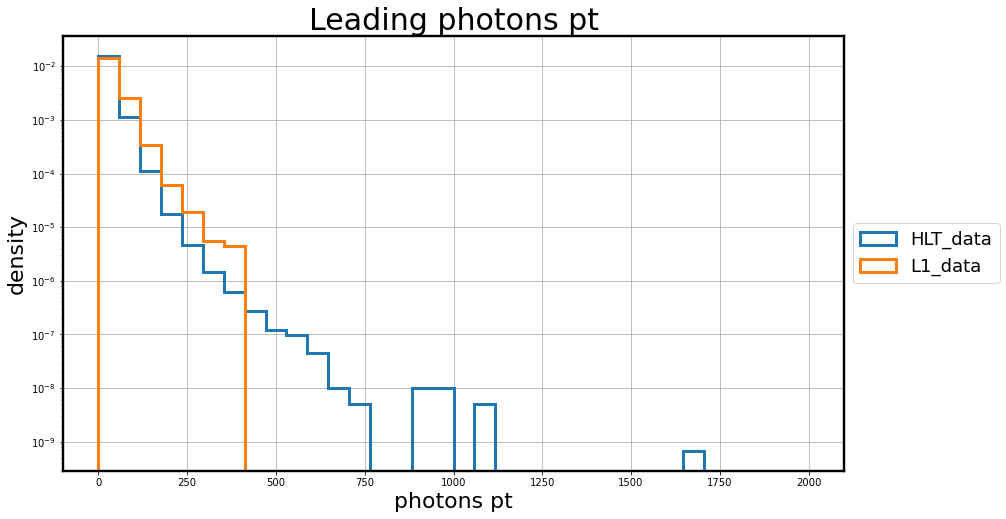

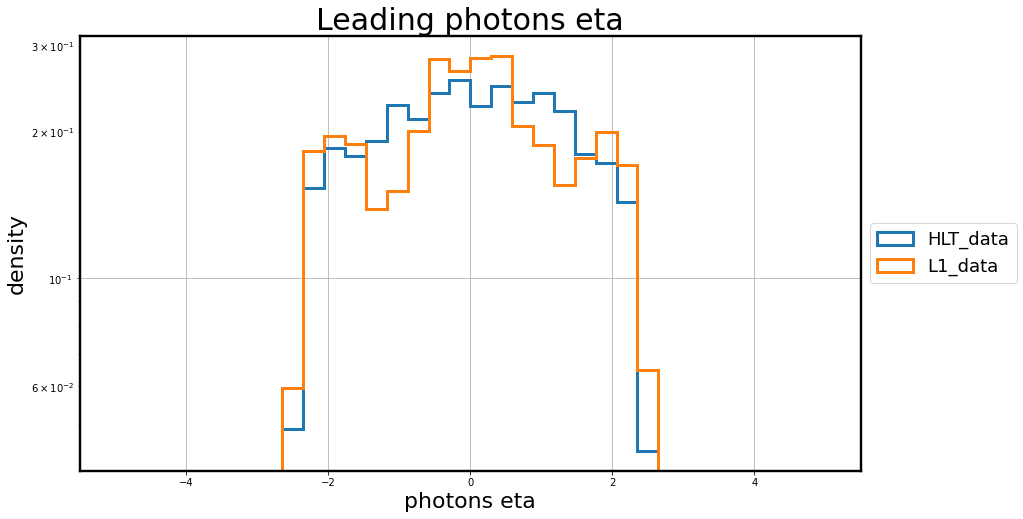

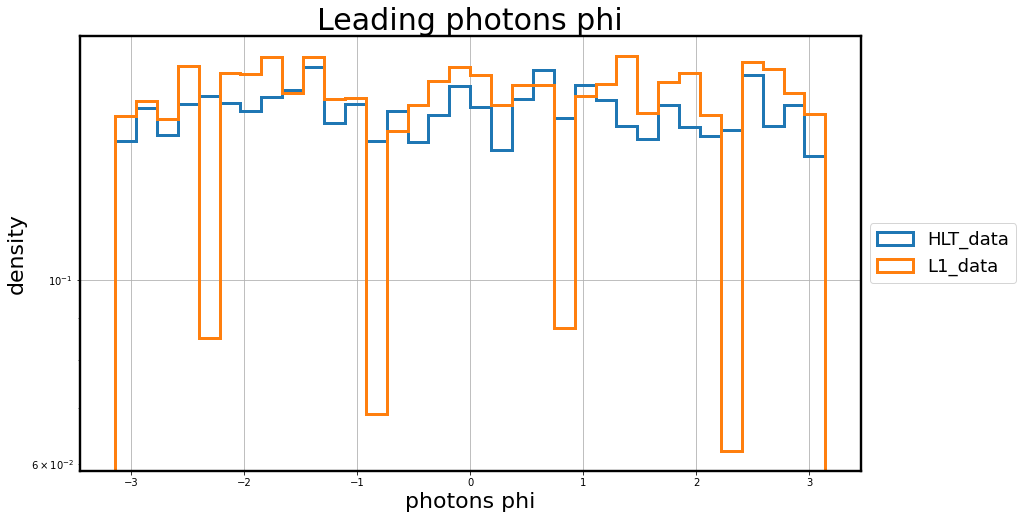

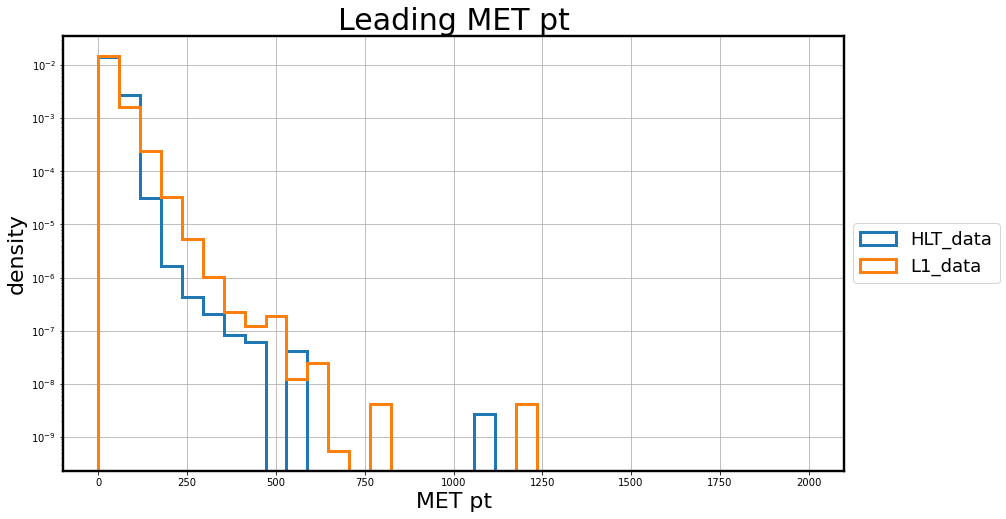

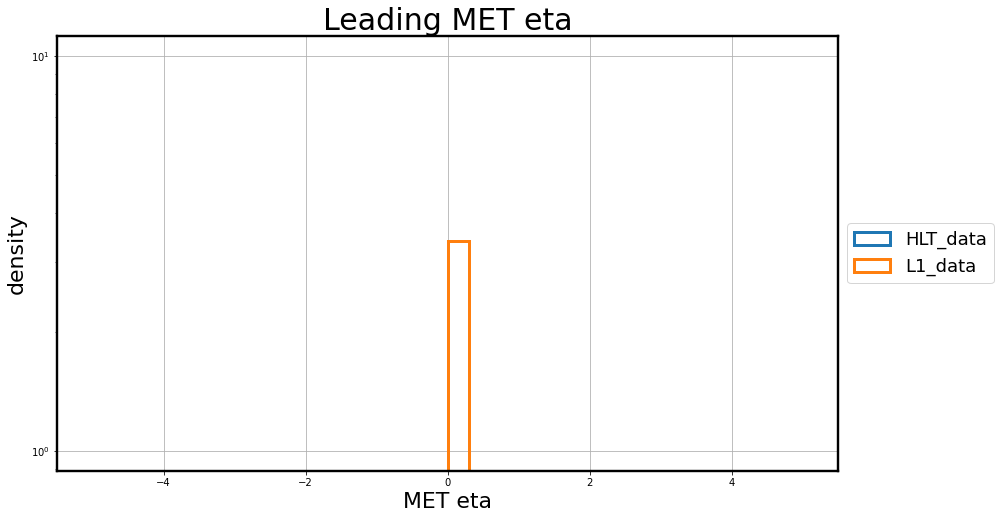

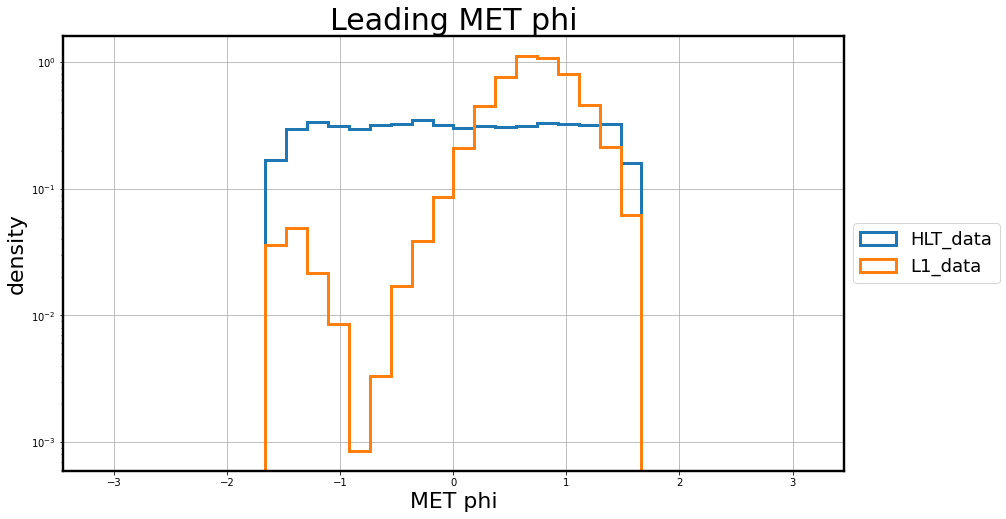

In [12]:
good_keys = ['HLT_data', 'L1_data']
plot_datasets = {key: value for key, value in datasets.items() if key in good_keys}

for object in ['jets', 'electrons', 'muons', 'photons', 'MET']:
    for var in ['pt', 'eta', 'phi']:
        plot_kinematics(datasets=plot_datasets, weights=weights, object=object, var=var)

In [13]:
def plot_event(event, dataset_tag=''):
    '''Visual representation of an event. Plots objects in the eta-phi plane, with the pt being
    represented as the size of the marker.'''
    labels = {
        'Jet': 'blue',
        'Electron': 'yellow',
        'Muon': 'green',
        'Photon': 'red',
        'MET': 'black'
    }
    colors = 10*['blue'] + 3*['yellow'] + 3*['green'] + 3*['red'] + ['black']

    
    pt = event[:, 0]
    eta = event[:, 1]
    phi = event[:, 2]

    plt.figure(figsize=(10, 7))
    plt.scatter(phi, eta, s=pt*10, c=colors)

    legend_handles = []
    for obj_type, color in labels.items():
        legend_handles.append(mpatches.Patch(color=color, label=obj_type))

    plt.legend(handles=legend_handles, fontsize=14)

    plt.xlabel('Phi', fontsize=16)
    plt.ylabel('Eta', fontsize=16)
    plt.title(f'Spatial Distribution of Objects in {dataset_tag} Event', fontsize=20)
    plt.grid(True)
    plt.show()

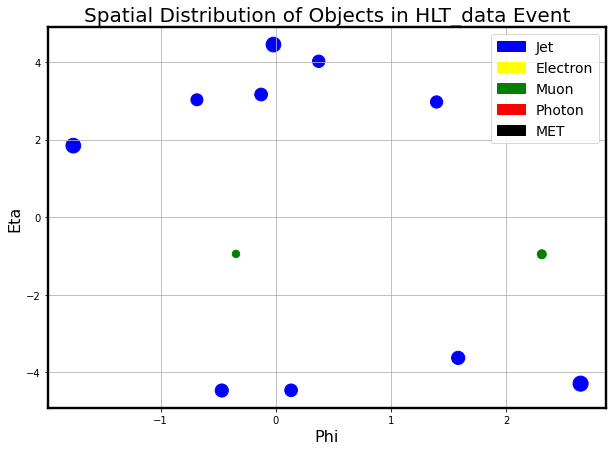

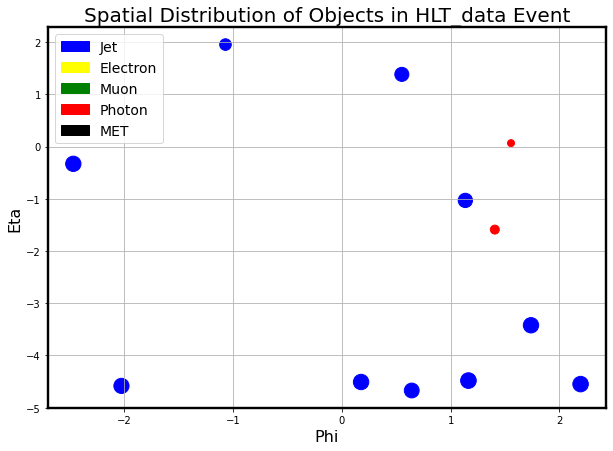

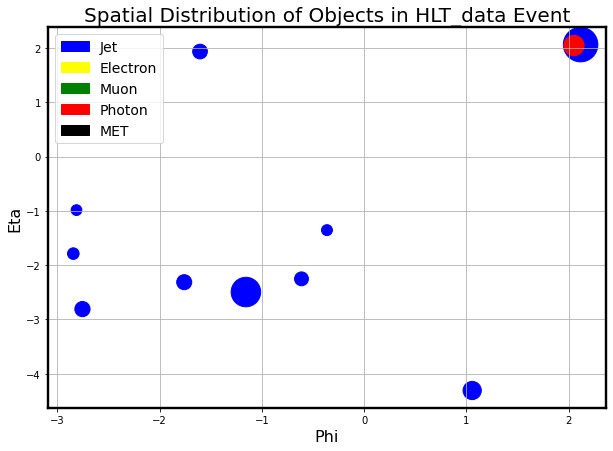

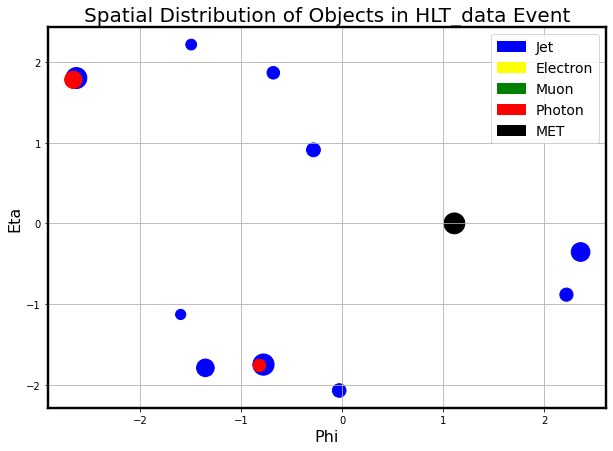

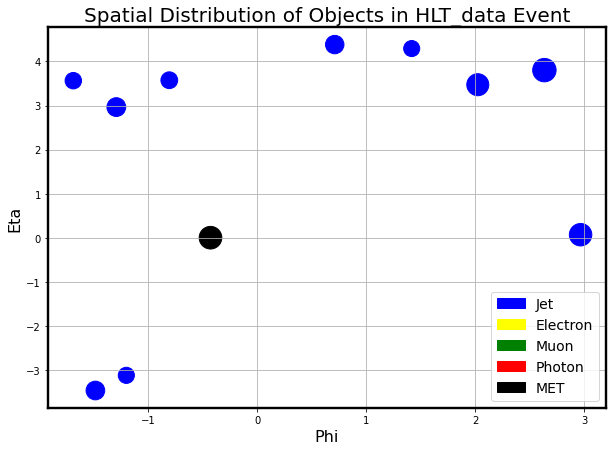

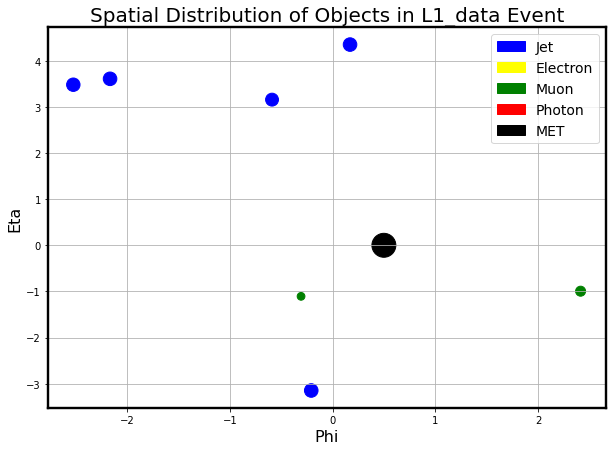

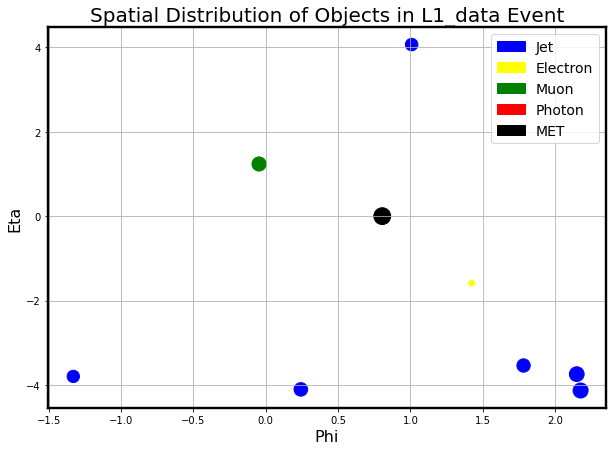

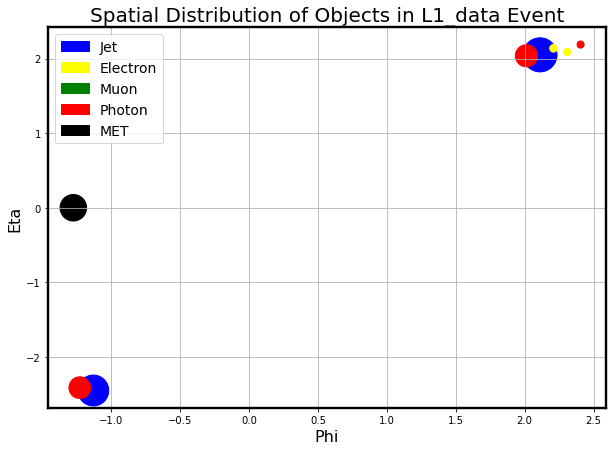

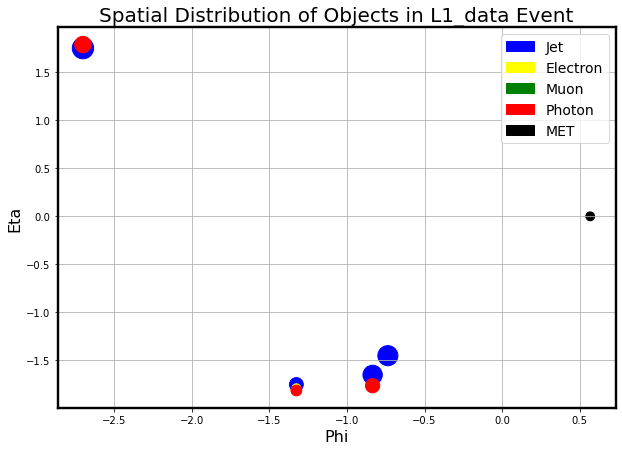

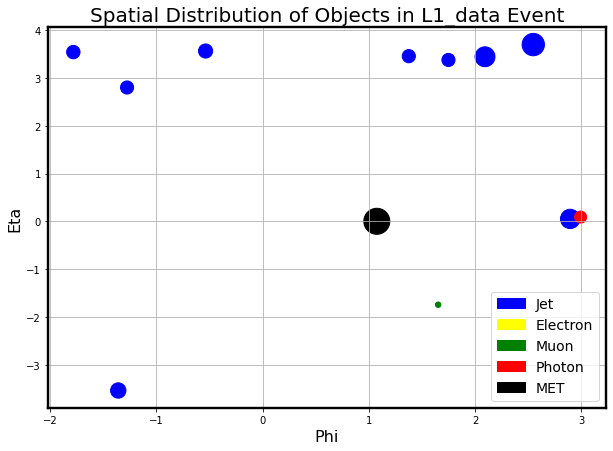

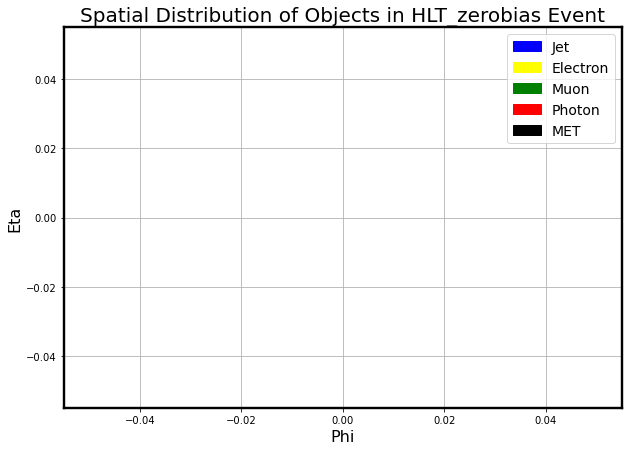

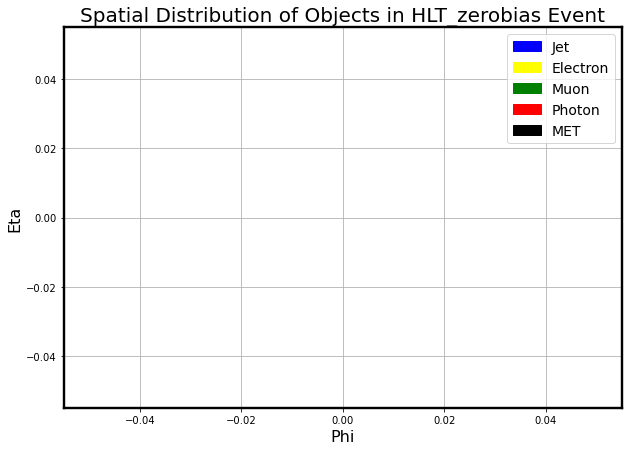

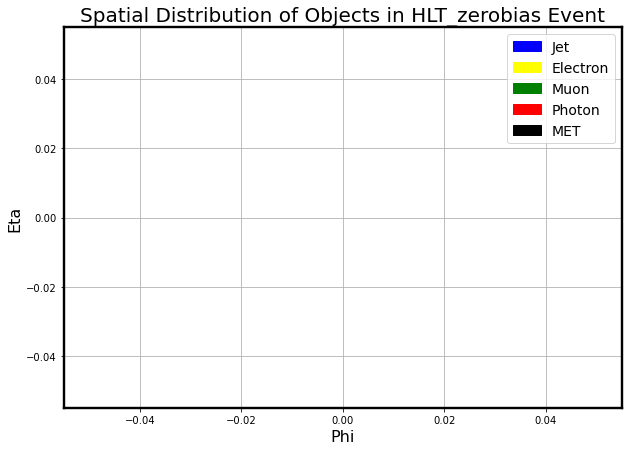

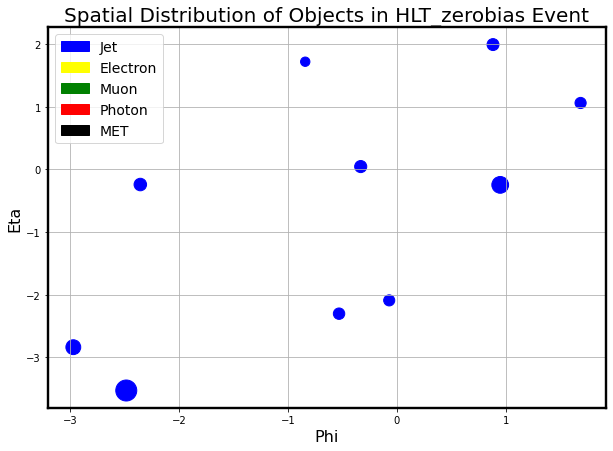

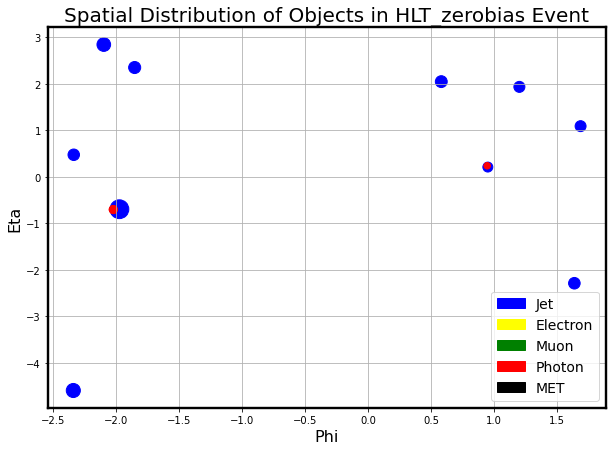

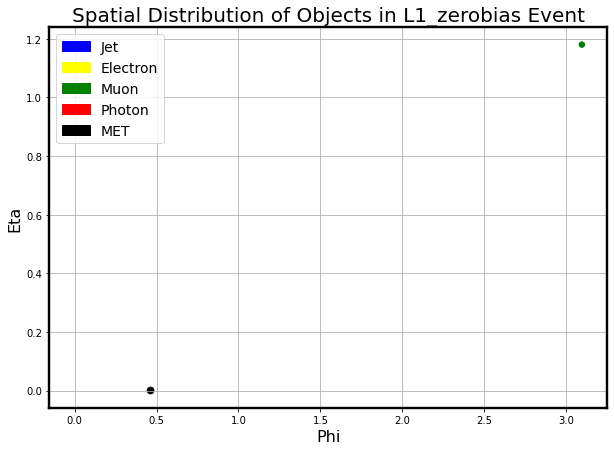

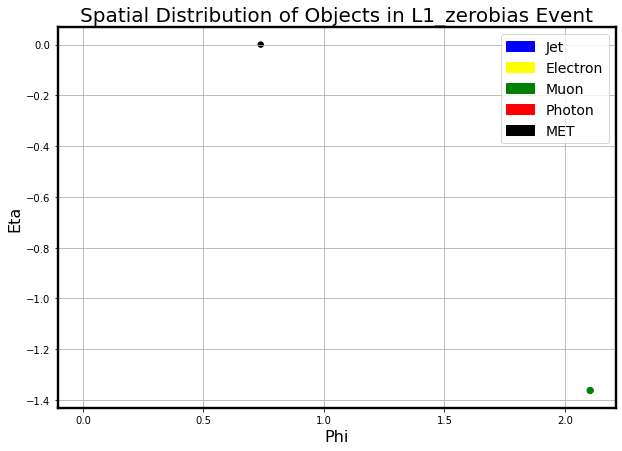

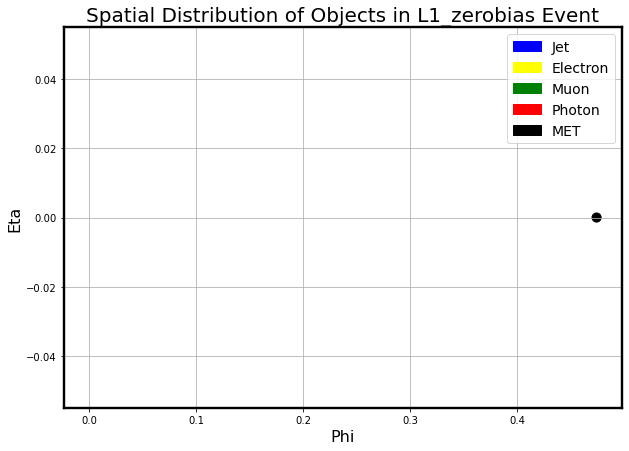

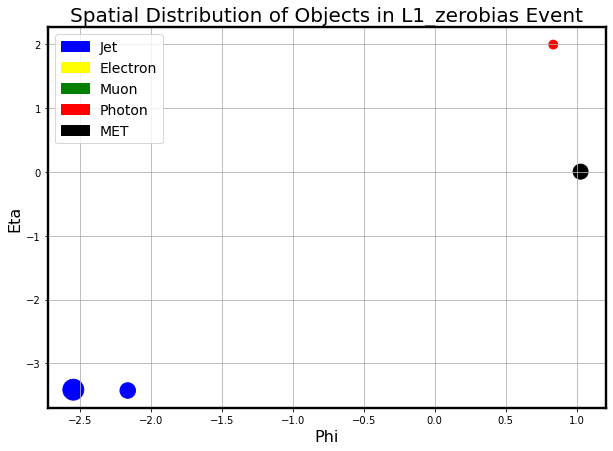

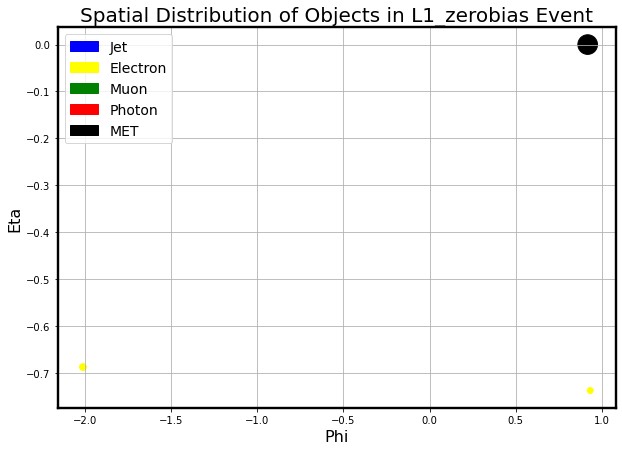

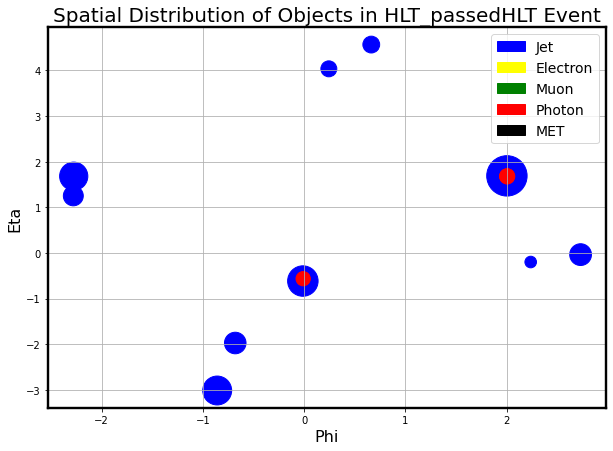

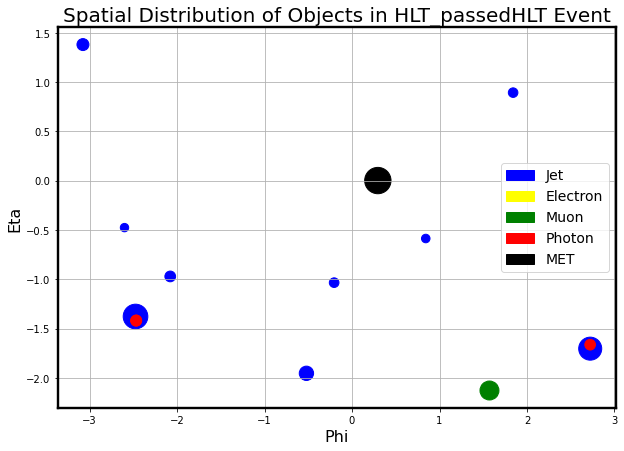

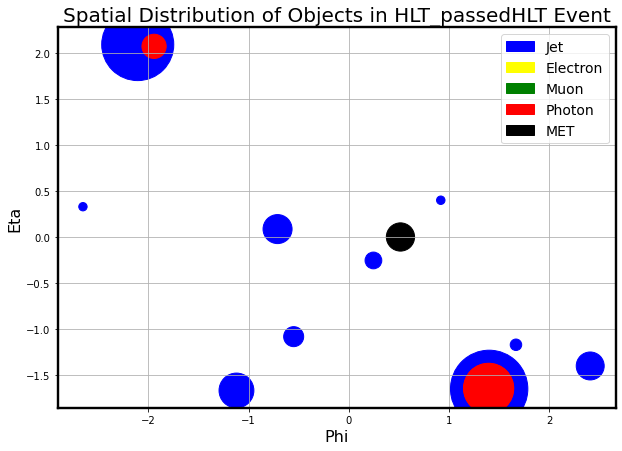

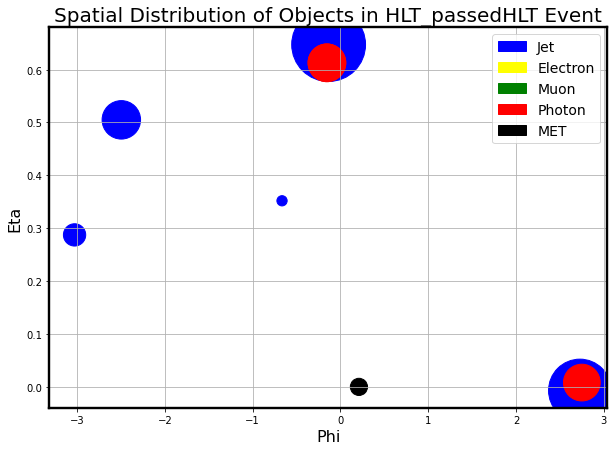

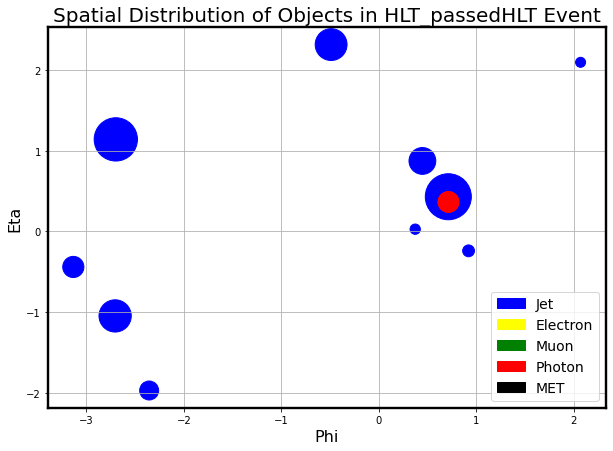

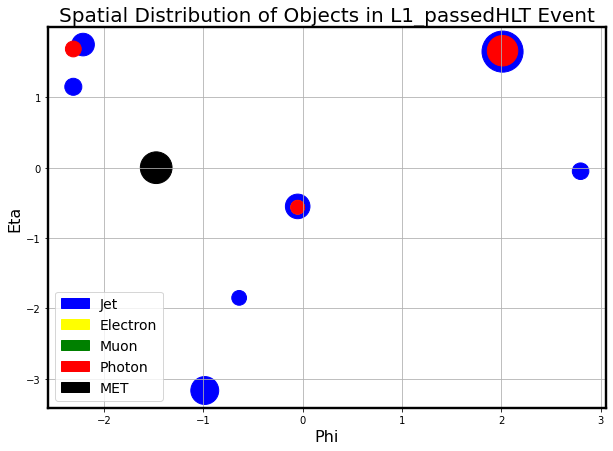

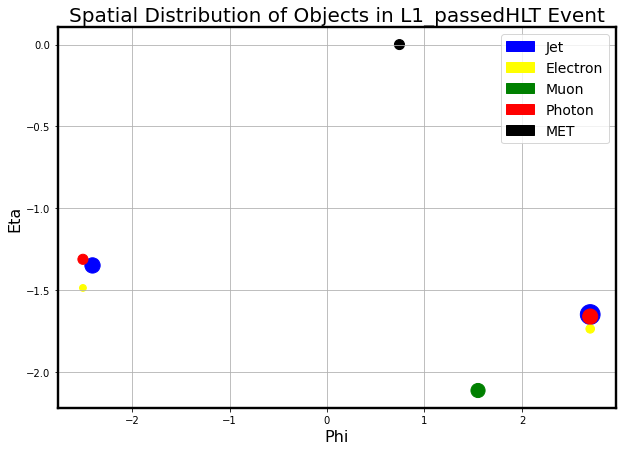

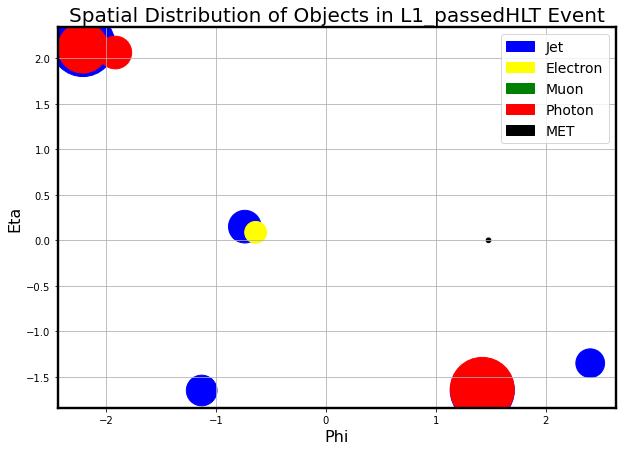

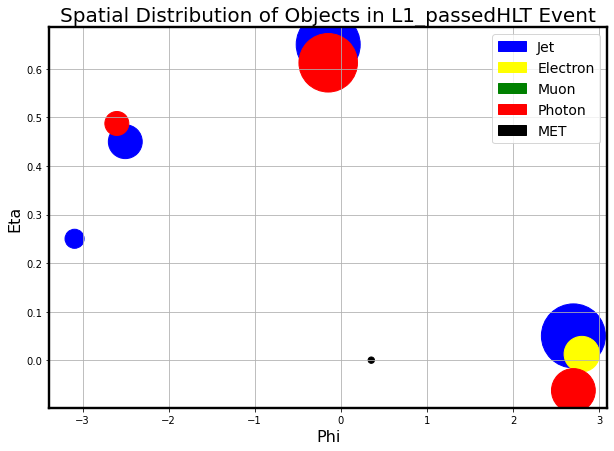

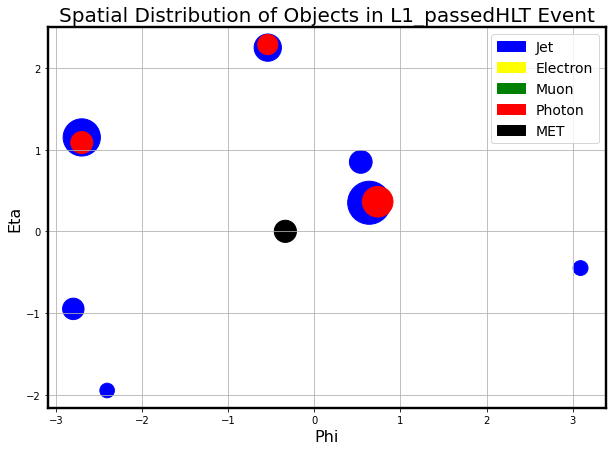

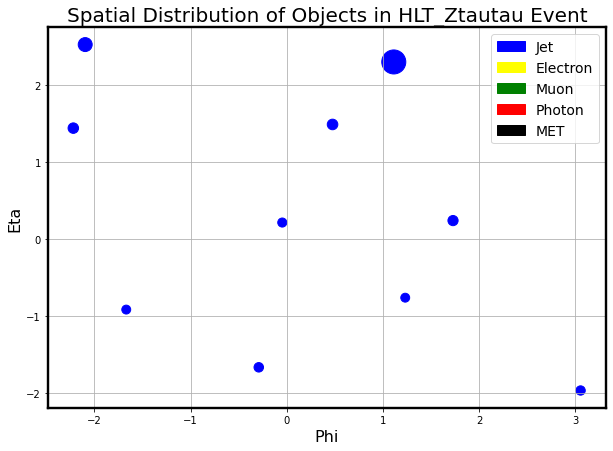

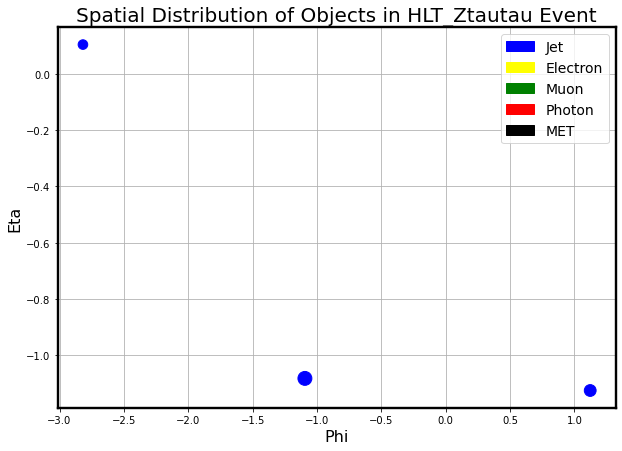

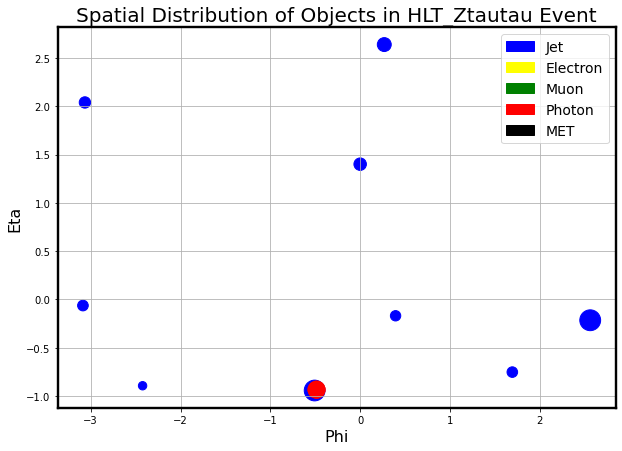

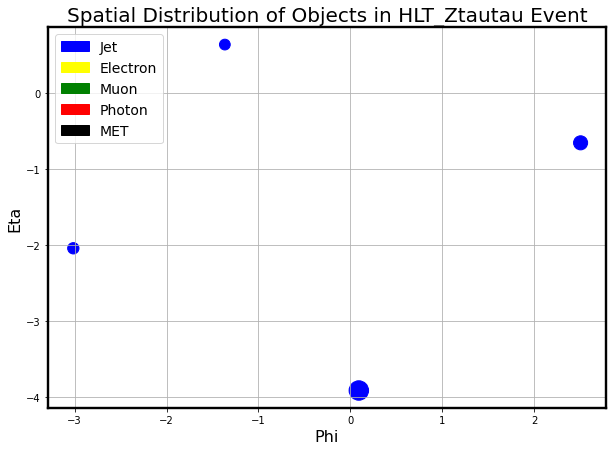

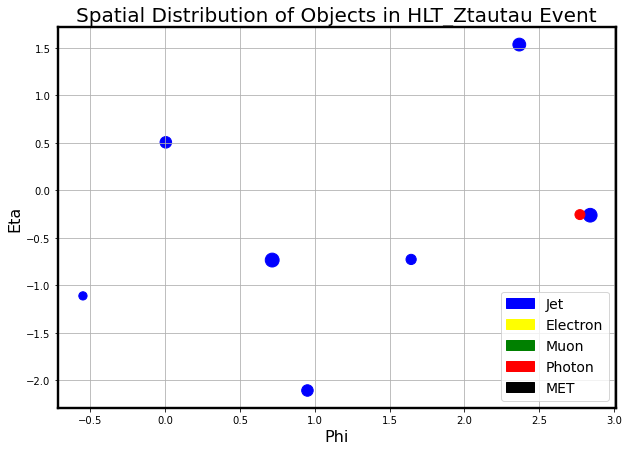

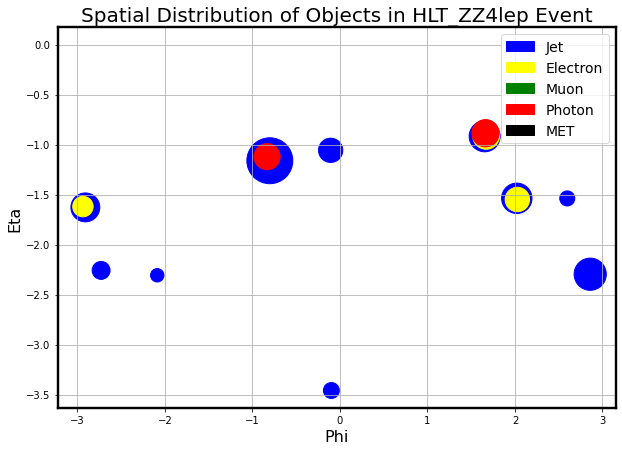

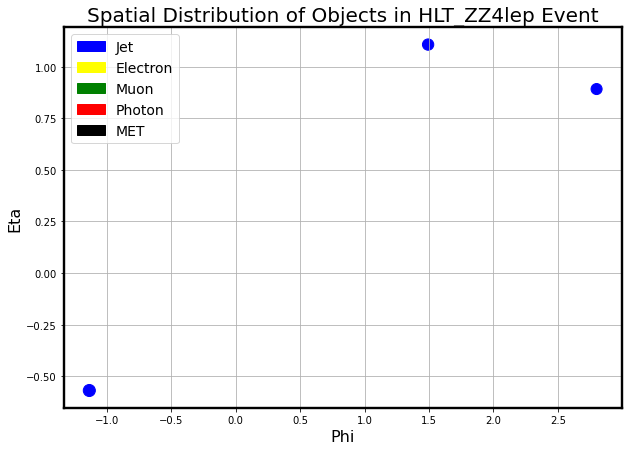

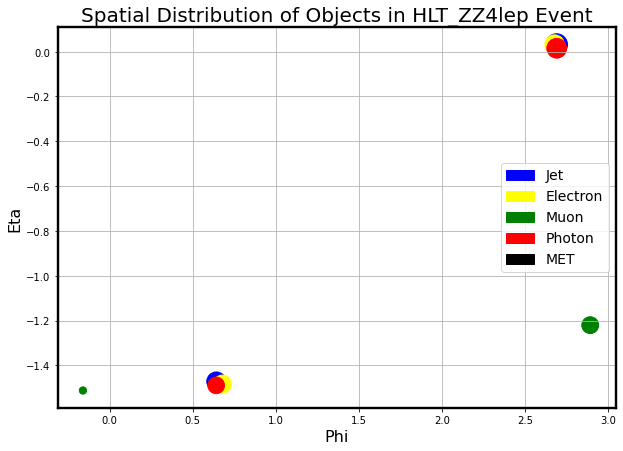

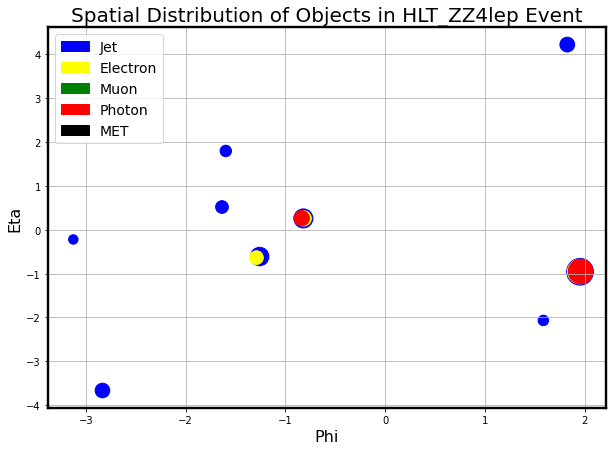

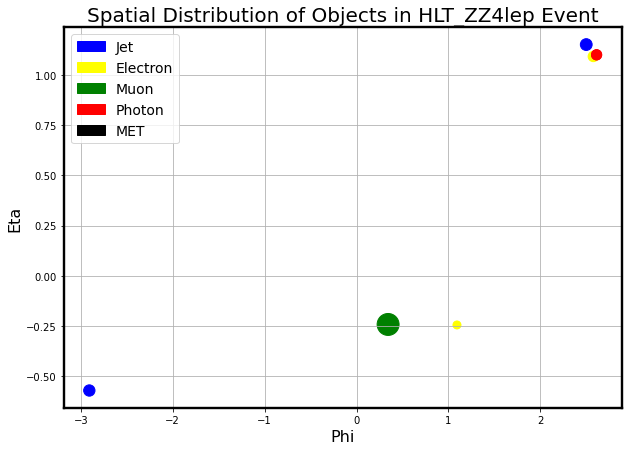

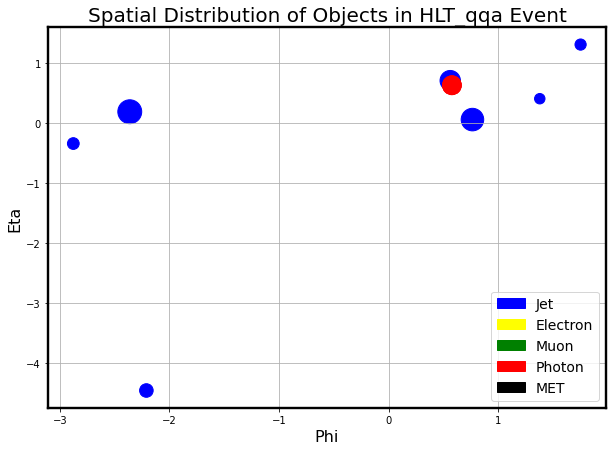

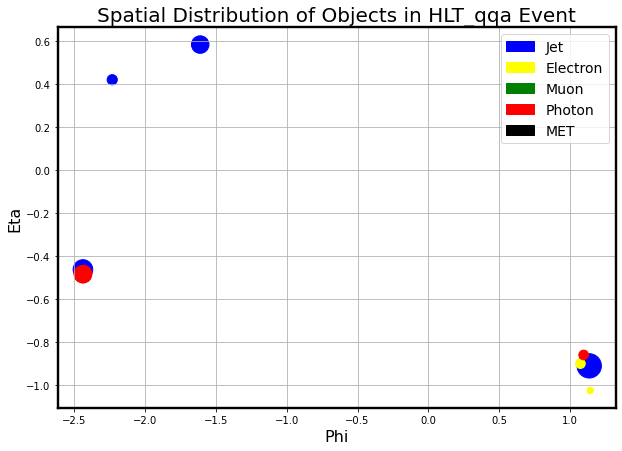

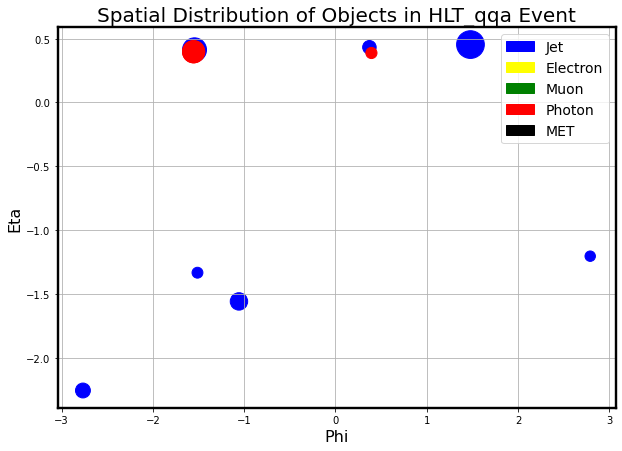

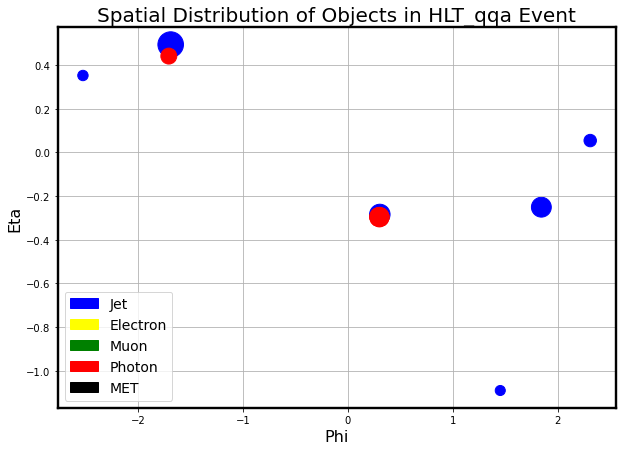

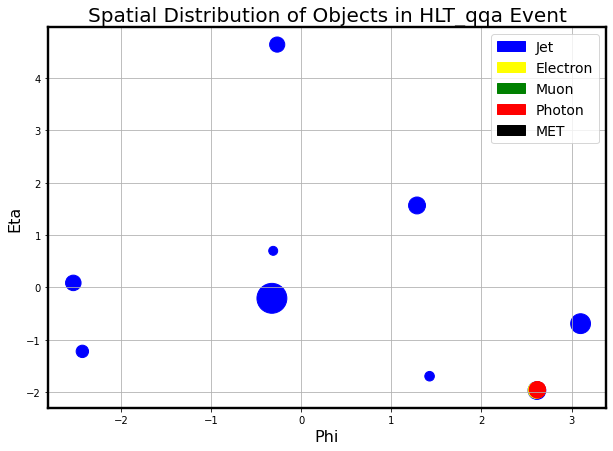

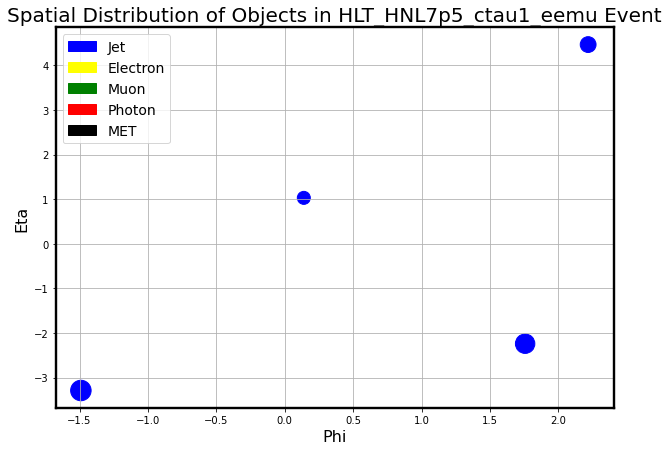

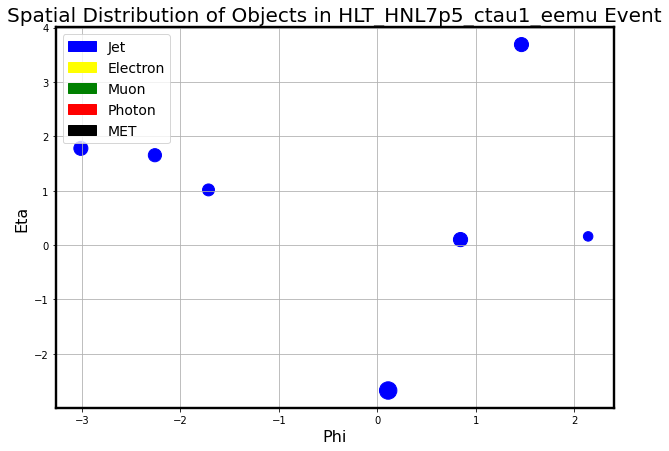

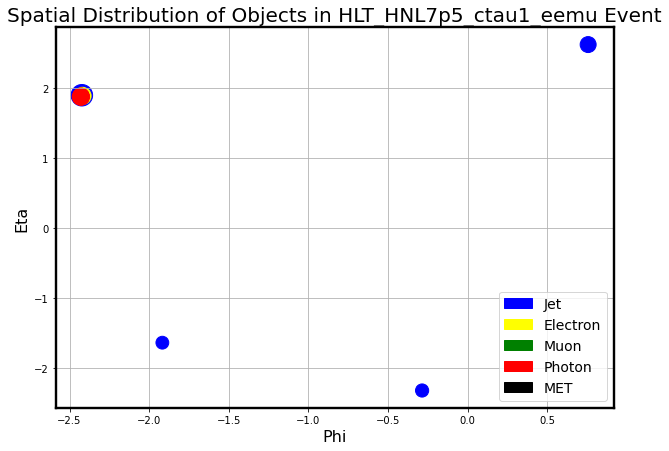

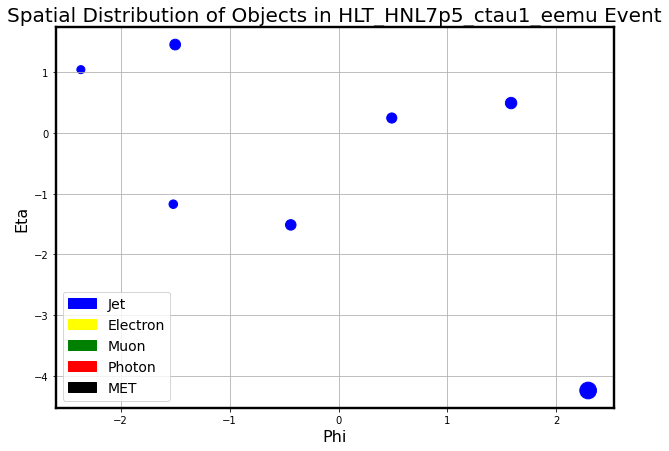

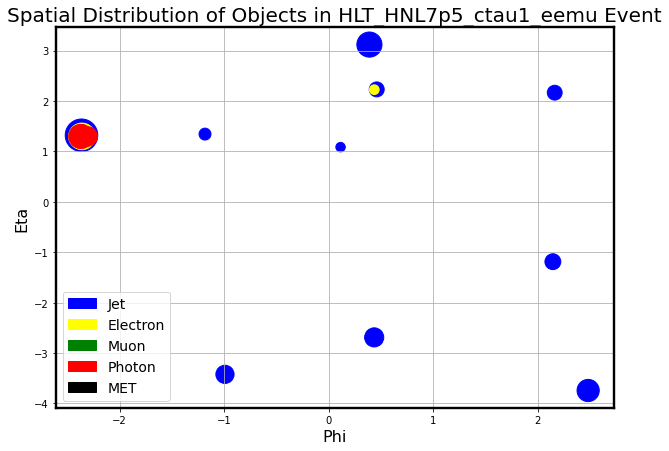

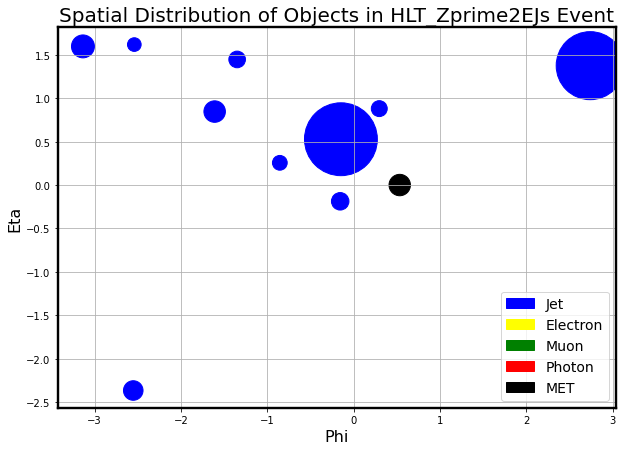

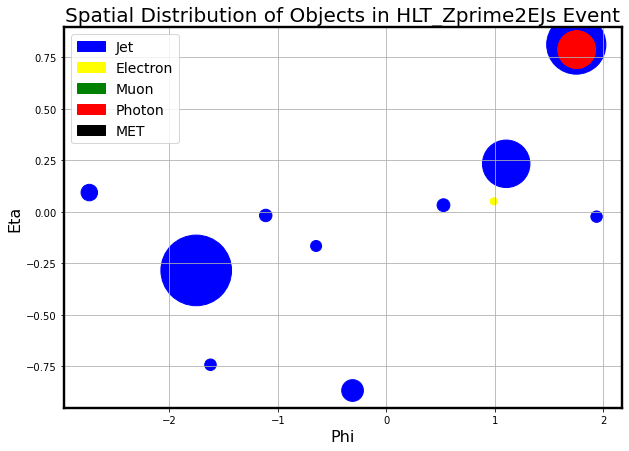

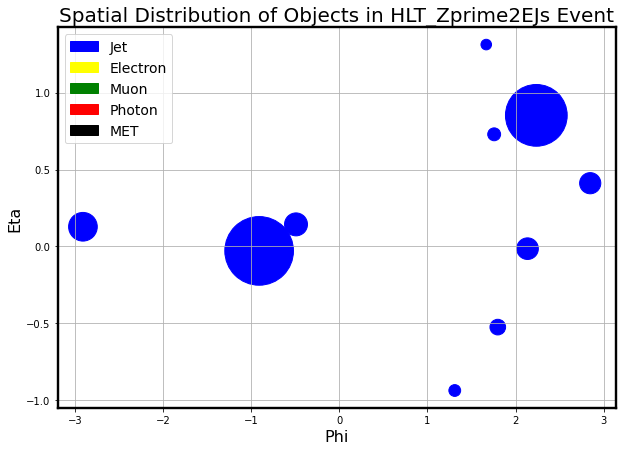

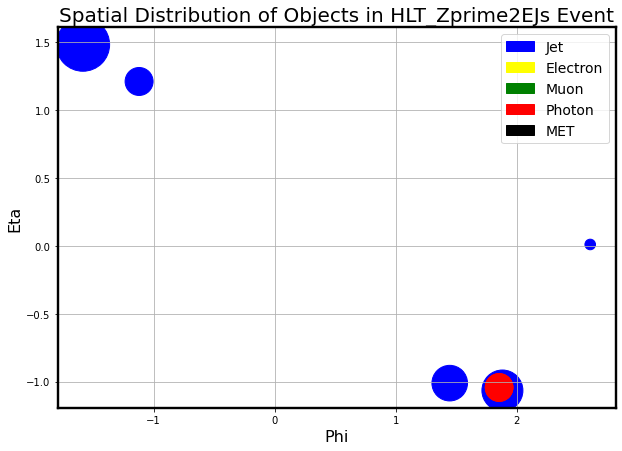

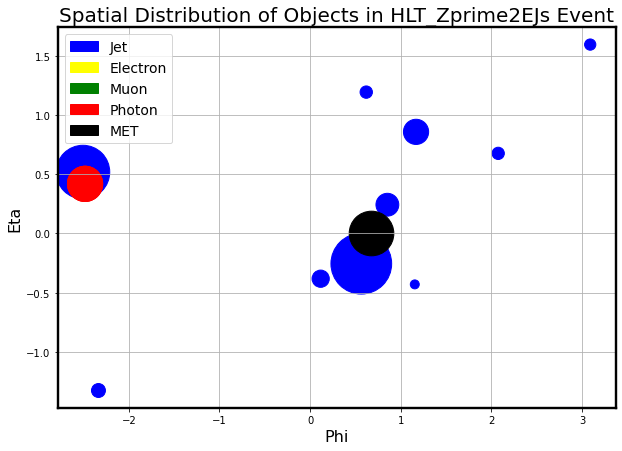

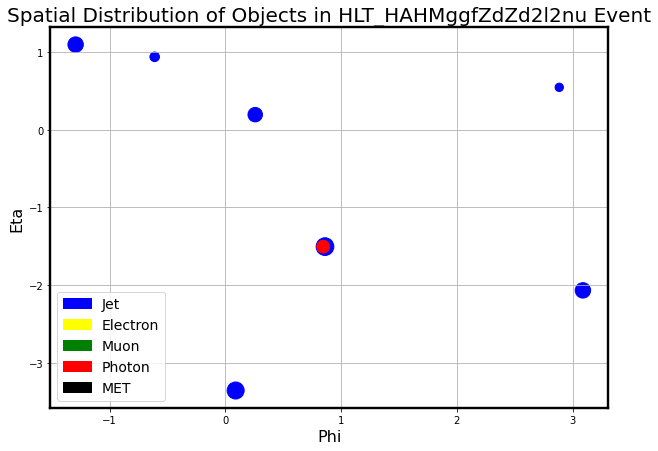

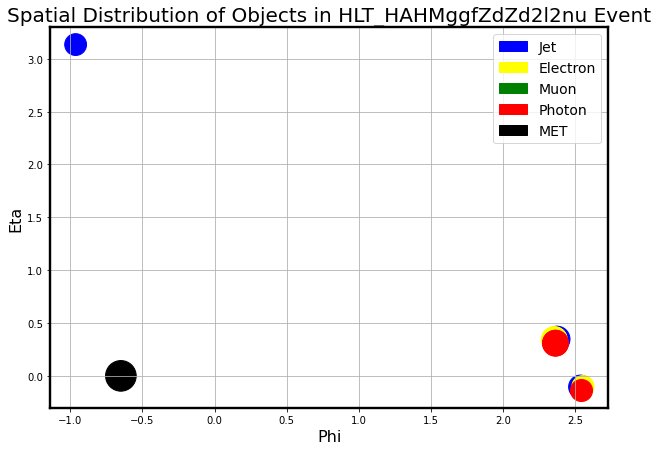

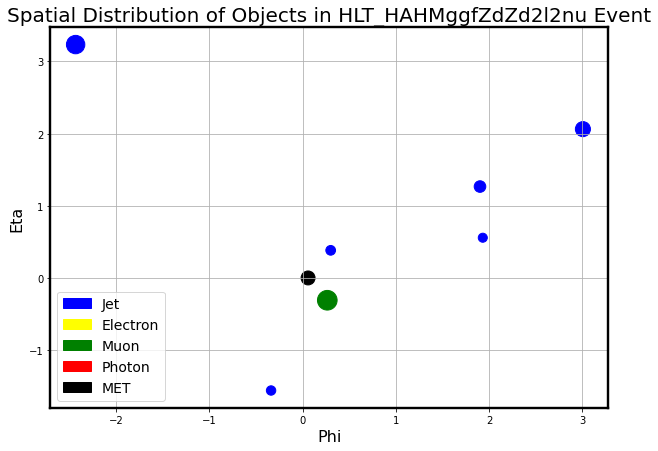

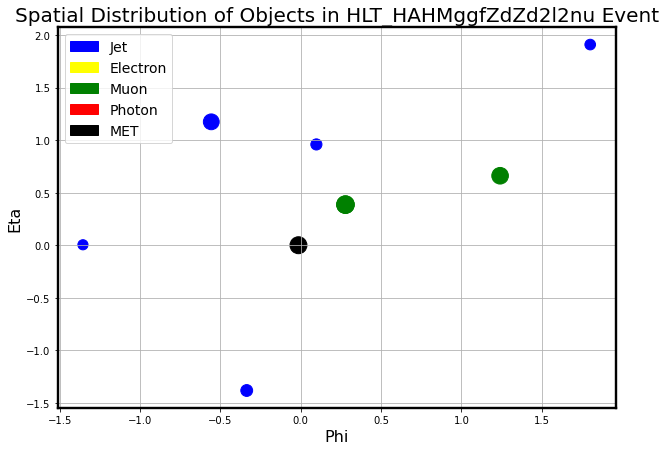

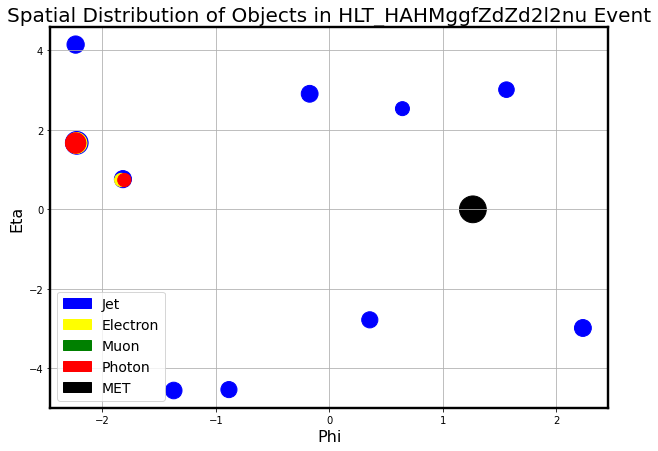

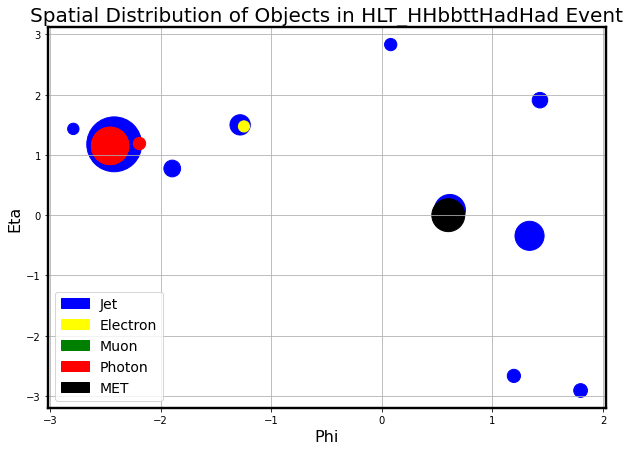

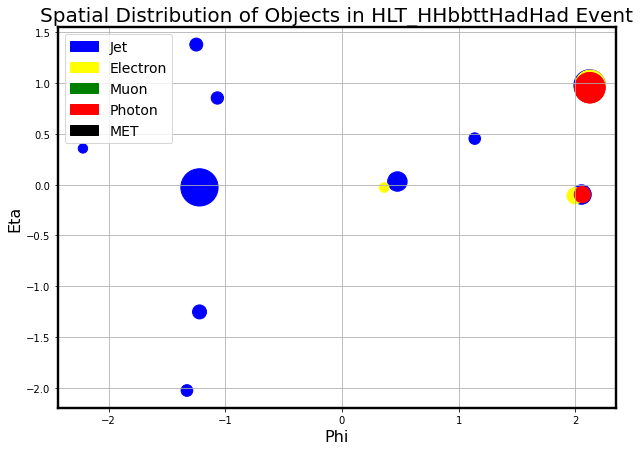

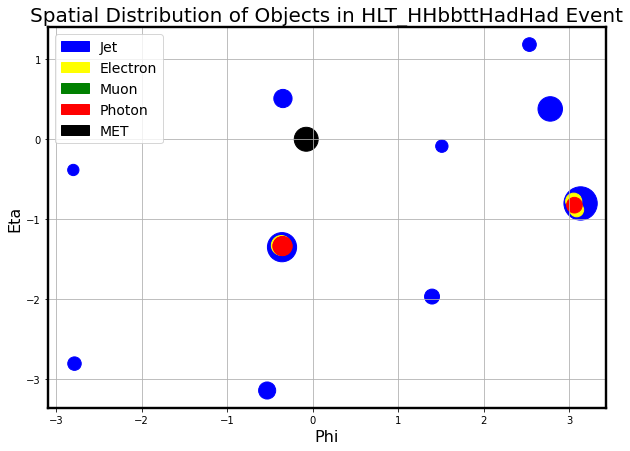

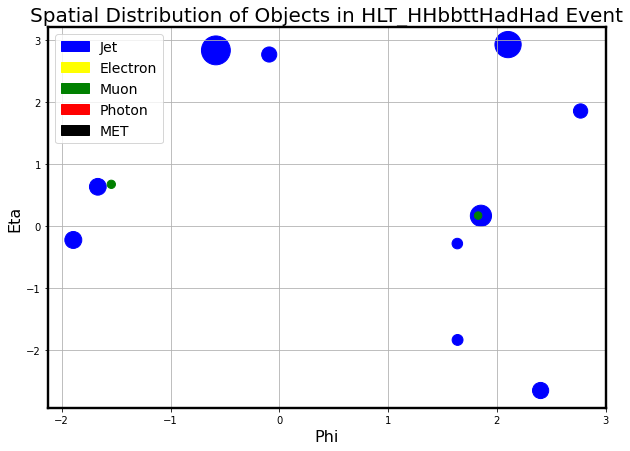

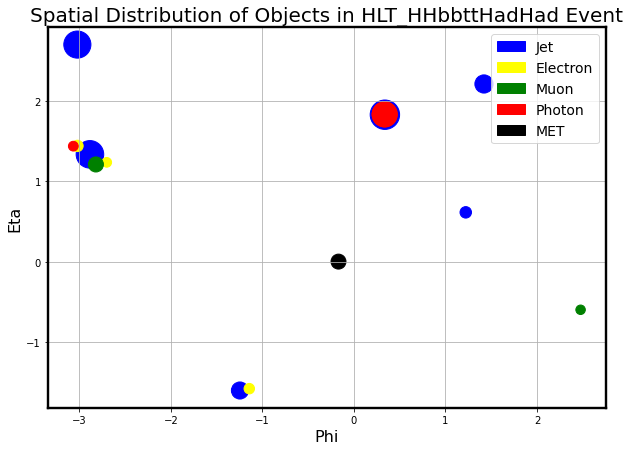

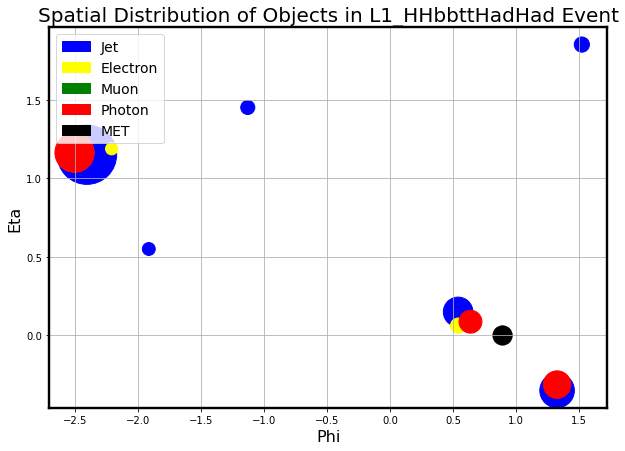

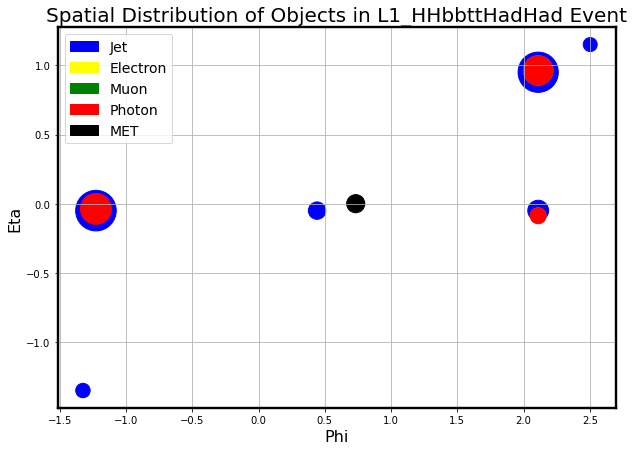

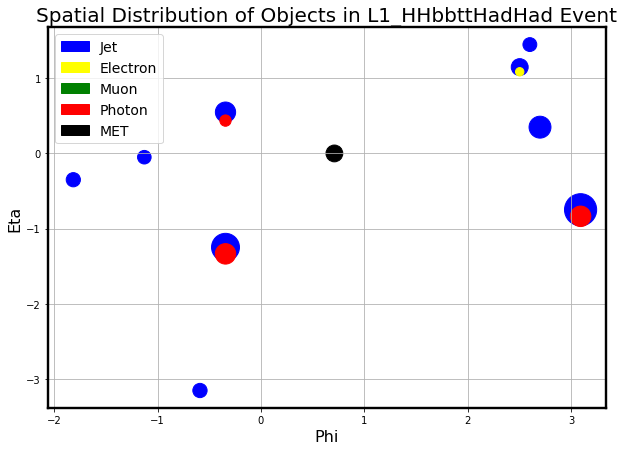

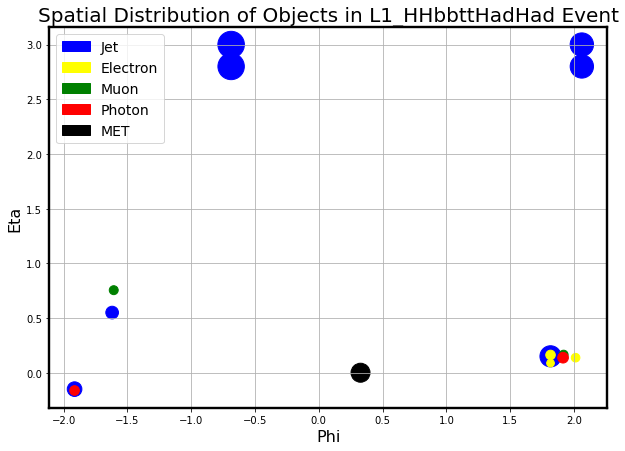

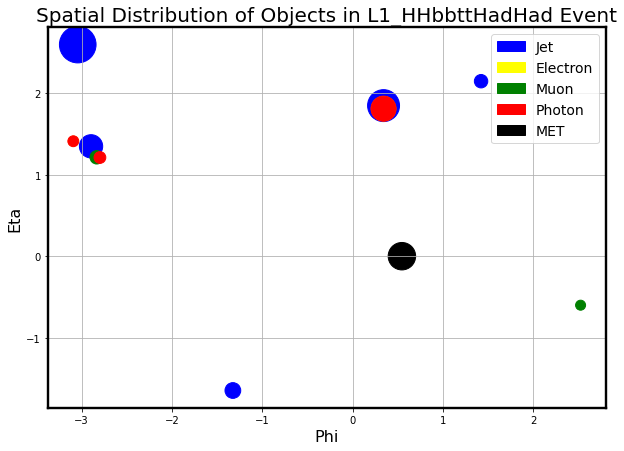

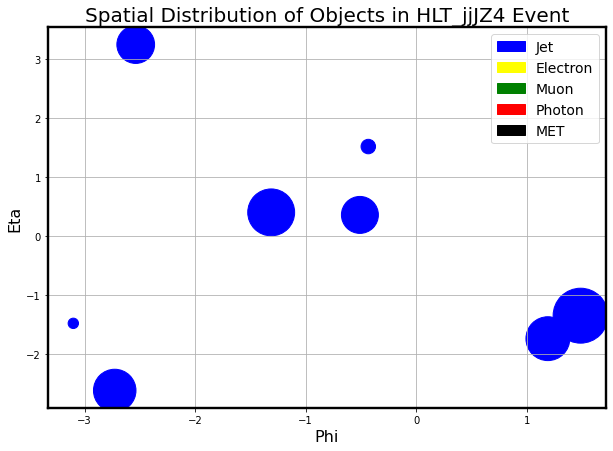

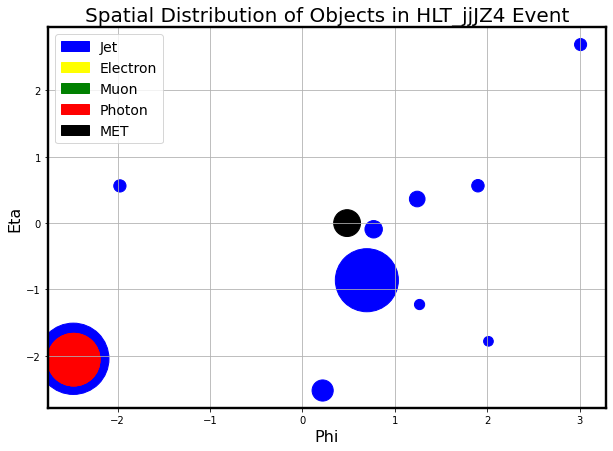

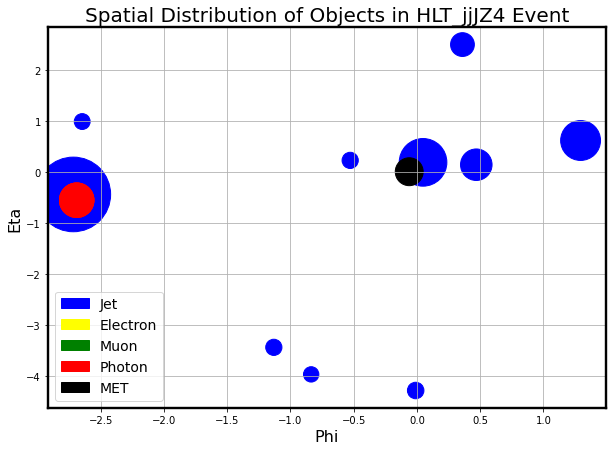

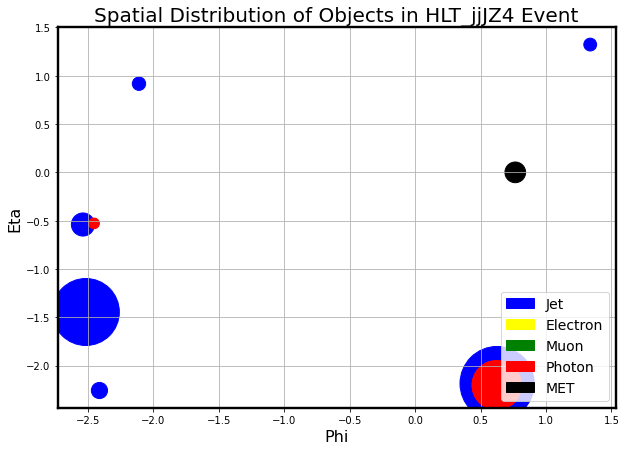

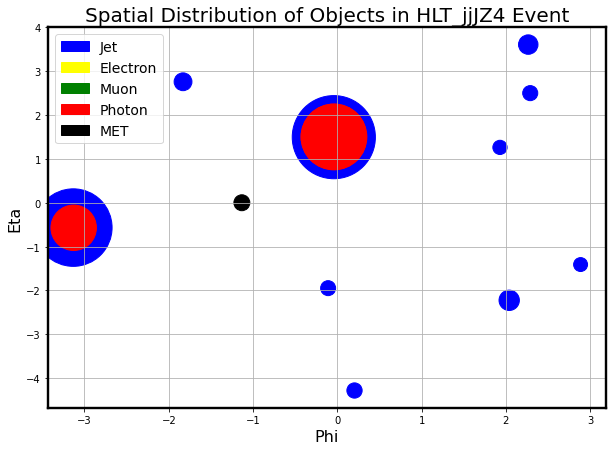

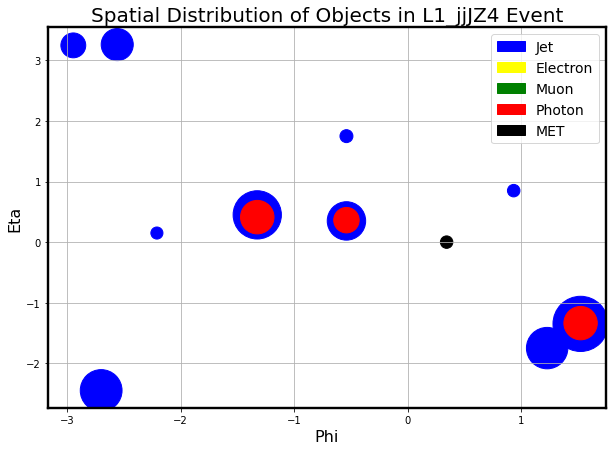

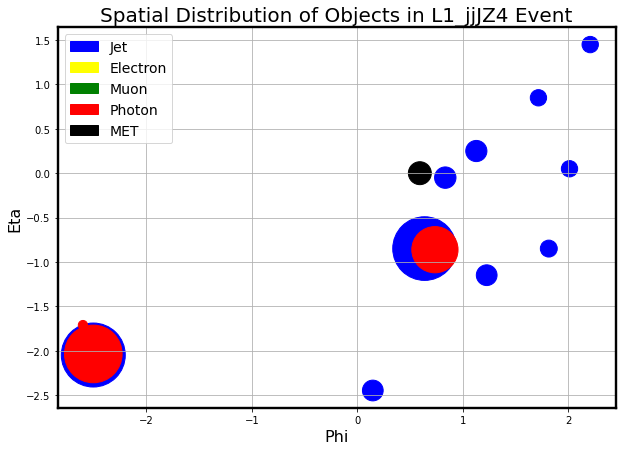

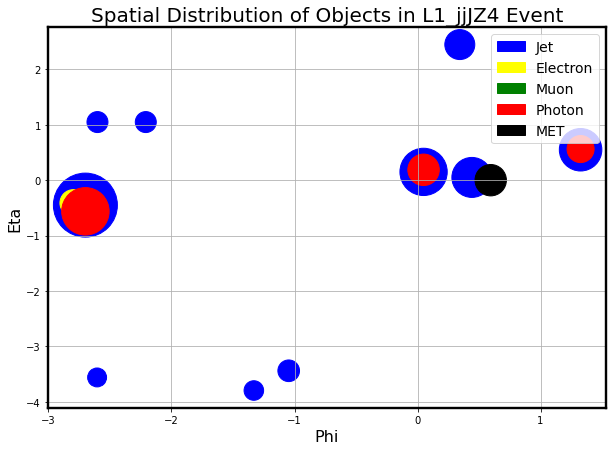

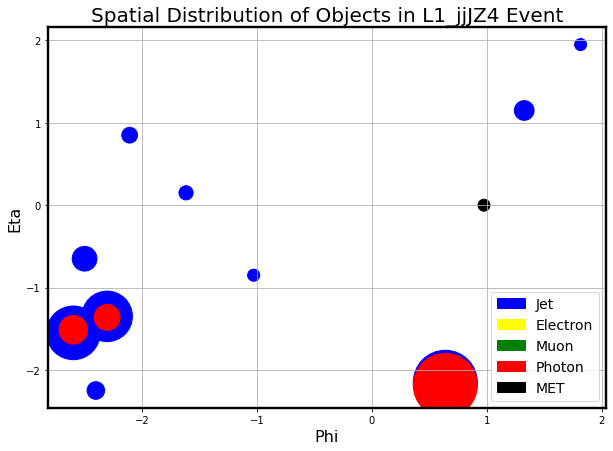

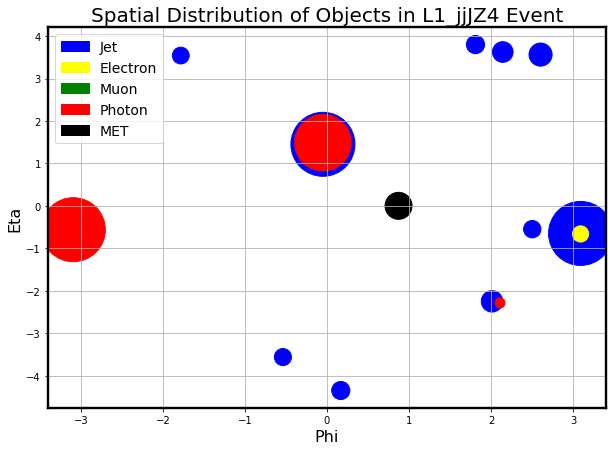

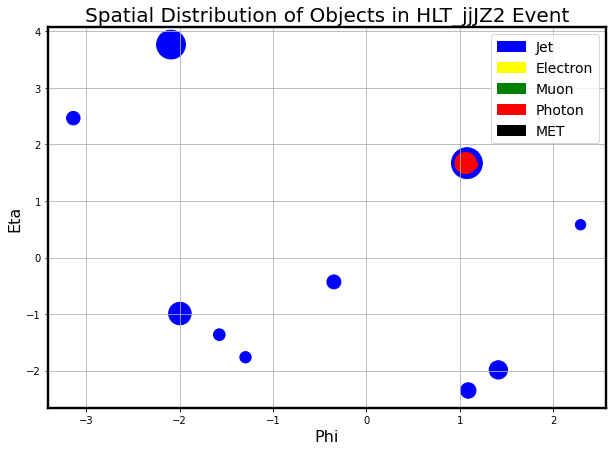

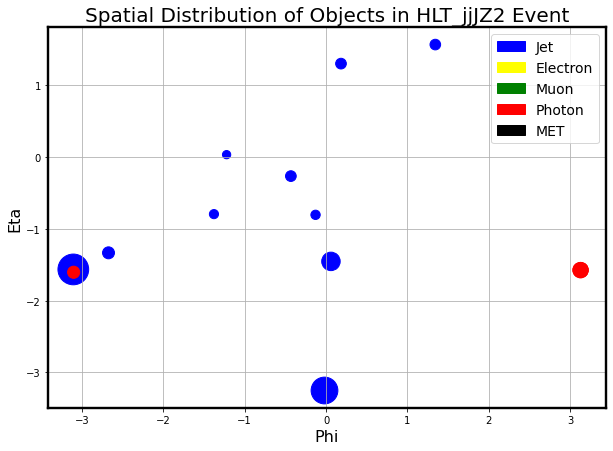

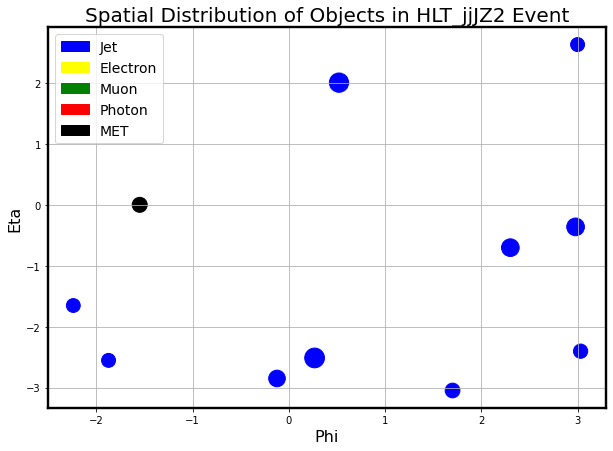

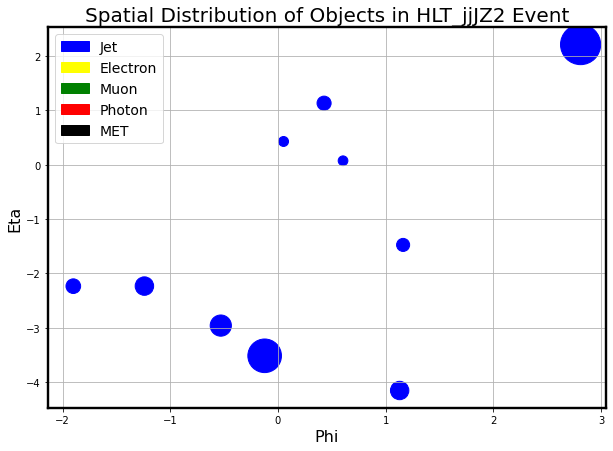

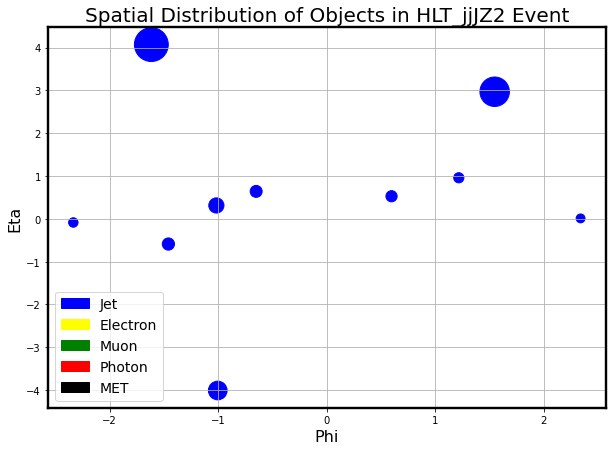

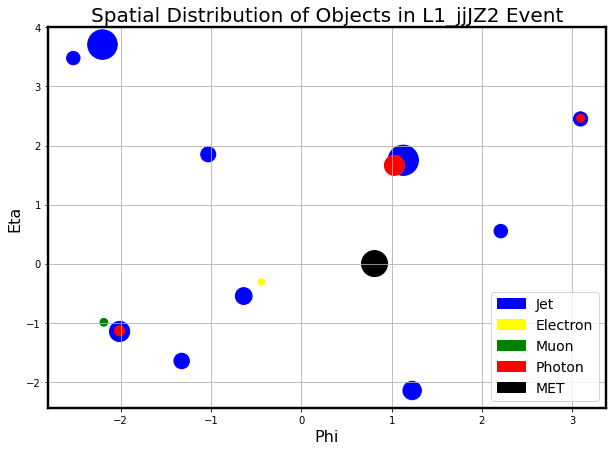

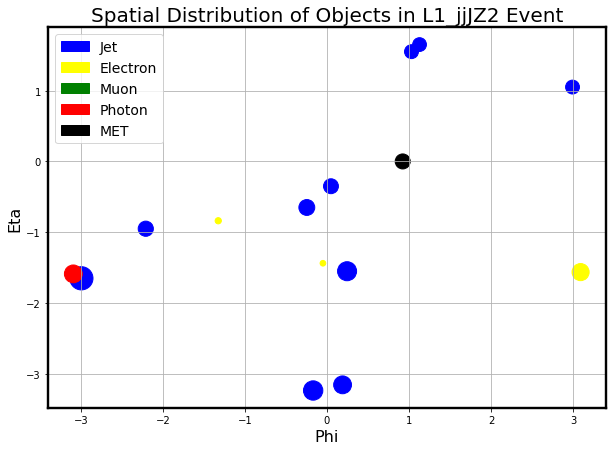

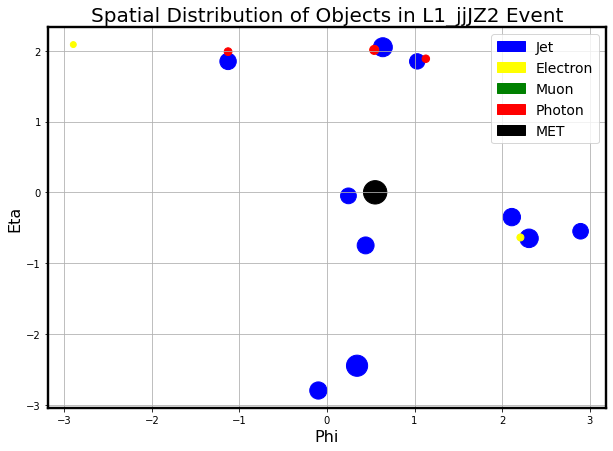

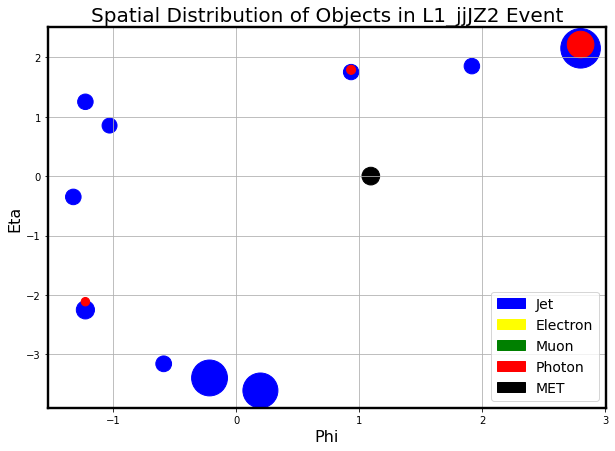

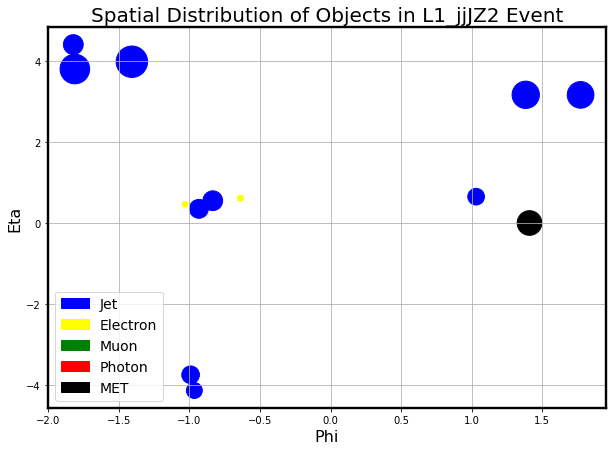

In [14]:
for tag, data in datasets.items():
    for i in range(5):
        plot_event(data[i], tag)

Event 0:


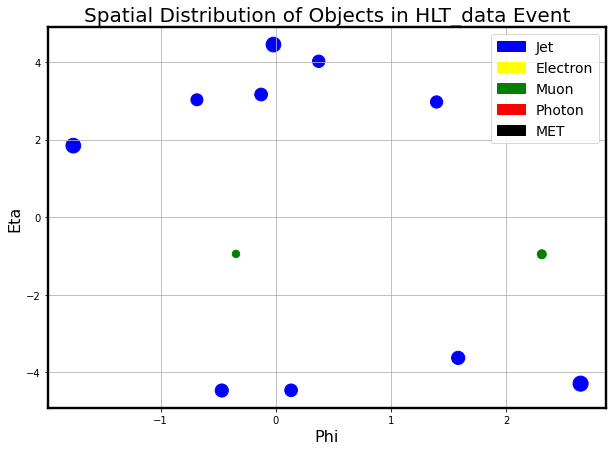

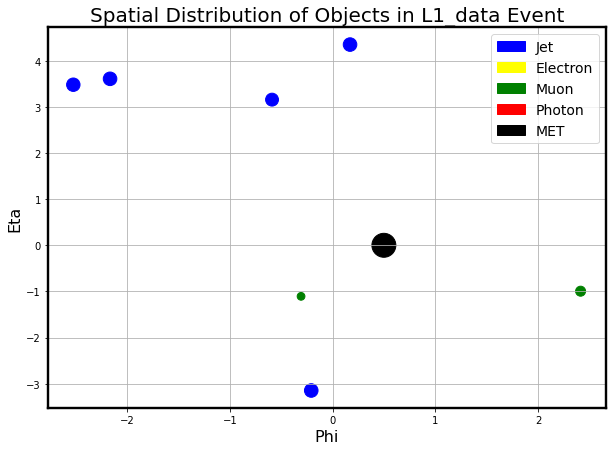





Event 1:


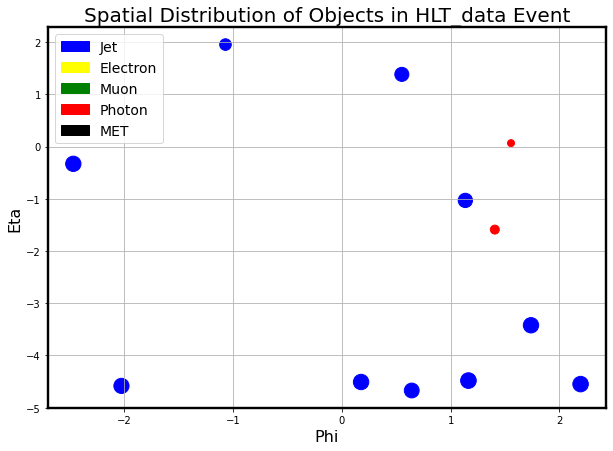

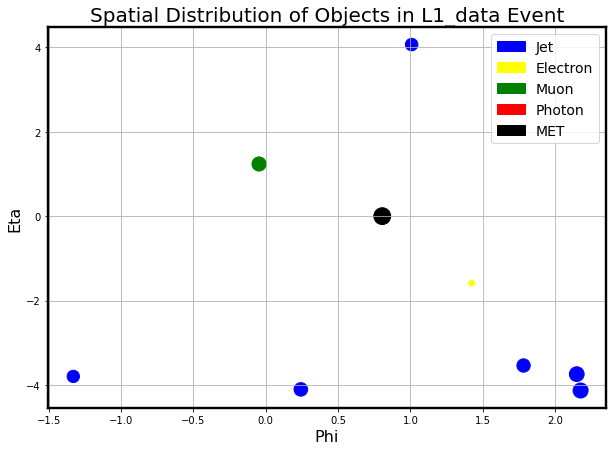





Event 2:


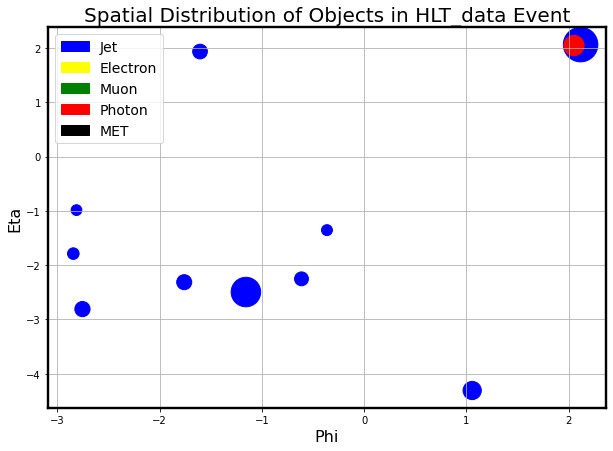

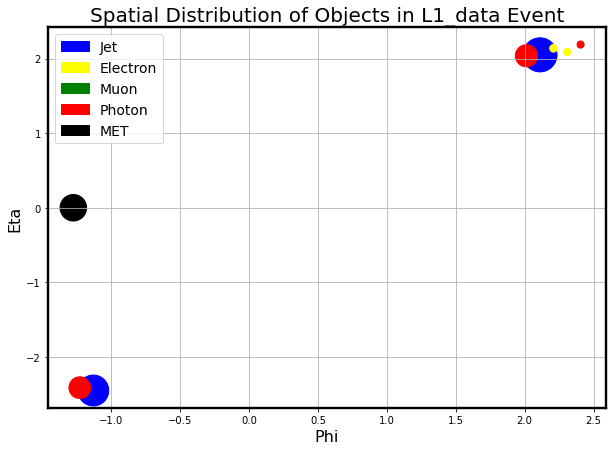





Event 3:


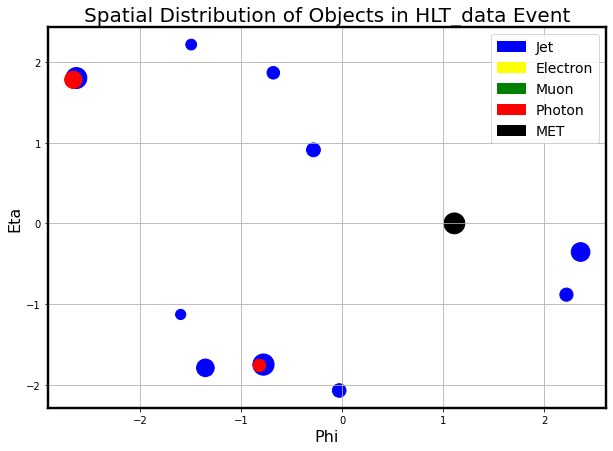

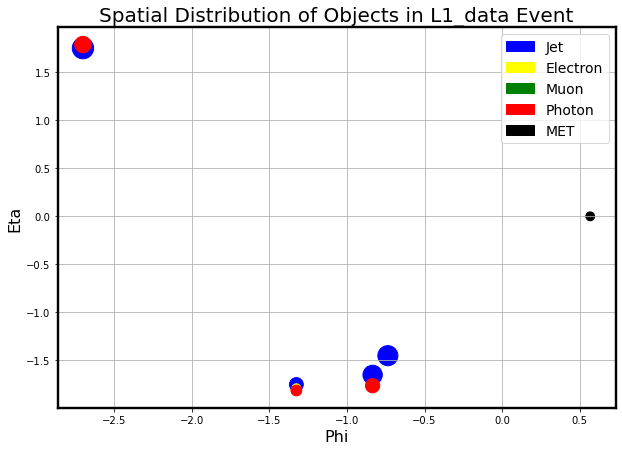





Event 4:


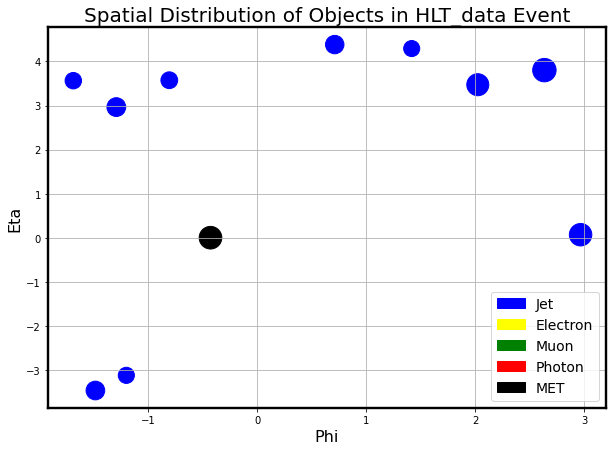

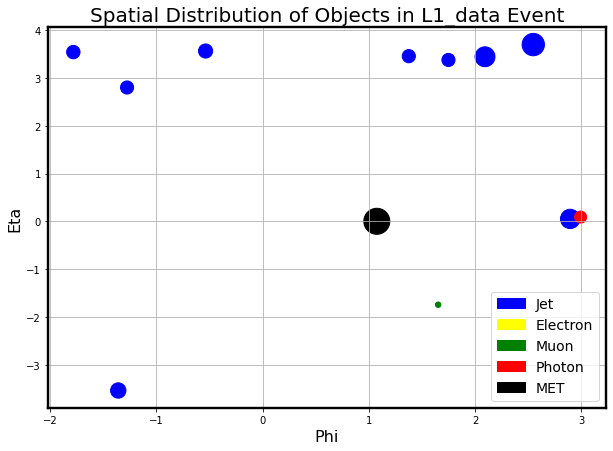

In [15]:
for i in range(5):
    print(f'Event {i}:')
    plot_event(datasets['HLT_data'][i], 'HLT_data')
    plot_event(datasets['L1_data'][i], 'L1_data')
    print('\n\n\n')

## Final preprocessing of data

In [10]:
"""Normalize pt """
for tag, data in datasets.items():
    # sum of the pt and E in each event
    sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)

    # If the sum is 0, set the sum to 1 to avoid division by 0
    sum_pt[sum_pt == 0] = 1

    # Divide pt and E by their respective sums
    data[:, :, 0] /= (sum_pt)

In [11]:
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (219467, 20, 3)
L1_data: (219467, 20, 3)
HLT_zerobias: (777848, 20, 3)
L1_zerobias: (777848, 20, 3)
HLT_passedHLT: (7850, 20, 3)
L1_passedHLT: (7850, 20, 3)
HLT_Ztautau: (100000, 20, 3)
HLT_ZZ4lep: (100000, 20, 3)
HLT_qqa: (50000, 20, 3)
HLT_HNL7p5_ctau1_eemu: (10000, 20, 3)
HLT_Zprime2EJs: (100000, 20, 3)
HLT_HAHMggfZdZd2l2nu: (70000, 20, 3)
HLT_HHbbttHadHad: (70000, 20, 3)
L1_HHbbttHadHad: (100000, 20, 3)
HLT_jjJZ4: (70000, 20, 3)
L1_jjJZ4: (100000, 20, 3)
HLT_jjJZ2: (70000, 20, 3)
L1_jjJZ2: (100000, 20, 3)


In [12]:
# Flatten ndarrays for use in DNN

for tag, data in datasets.items():
    datasets[tag] = np.reshape(data, newshape=(-1, 60))

for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (219467, 60)
L1_data: (219467, 60)
HLT_zerobias: (777848, 60)
L1_zerobias: (777848, 60)
HLT_passedHLT: (7850, 60)
L1_passedHLT: (7850, 60)
HLT_Ztautau: (100000, 60)
HLT_ZZ4lep: (100000, 60)
HLT_qqa: (50000, 60)
HLT_HNL7p5_ctau1_eemu: (10000, 60)
HLT_Zprime2EJs: (100000, 60)
HLT_HAHMggfZdZd2l2nu: (70000, 60)
HLT_HHbbttHadHad: (70000, 60)
L1_HHbbttHadHad: (100000, 60)
HLT_jjJZ4: (70000, 60)
L1_jjJZ4: (100000, 60)
HLT_jjJZ2: (70000, 60)
L1_jjJZ2: (100000, 60)


In [13]:
# Make train, test, and val splits
# TRAIN_SIZE = 0.5
# VAL_SIZE = 0.1
# TEST_1_SIZE = 0.2
# TEST_2_SIZE = 0.2

# HLT_tags = ['train', 'val', 'test_bkg', 'test2', 'zerobias', 'Ztautau', 'HHbbttHadHad', 'ZZ4lep', 'jjJZ4', 'jjJZ2', 'qqa', 'LLP', 'dark_jets', 'dark_photons']
# HLT_datasets = []
# HLT_weights = []

# L1_tags = ['train', 'val', 'test_bkg', 'test2', 'passed_HLT', 'passed_L1', 'passed_only_L1']
# L1_datasets = []
# L1_weights = []

random_seed = 0 # random seed for replication between notebooks

# HLT -----------------------------------
# Split indices
indices = np.arange(len(datasets['HLT_data']))
train_indices, temp_indices = train_test_split(indices, train_size=0.5, random_state=random_seed)
val_indices, test_indices = train_test_split(temp_indices, train_size=0.2, random_state=random_seed)  # Adjust size as needed
test_1_indices, test_2_indices = train_test_split(test_indices, train_size=0.5, random_state=random_seed)

# Train splits
datasets['HLT_train'] = datasets['HLT_data'][train_indices]
weights['HLT_train'] = weights['HLT_data'][train_indices]
datasets['L1_train'] = datasets['L1_data'][train_indices]
weights['L1_train'] = weights['L1_data'][train_indices]
pass_HLT['HLT_train'] = pass_HLT['HLT_data'][train_indices]
pass_HLT['L1_train'] = pass_HLT['L1_data'][train_indices]

# Val splits
datasets['HLT_val'] = datasets['HLT_data'][val_indices]
weights['HLT_val'] = weights['HLT_data'][val_indices]
datasets['L1_val'] = datasets['L1_data'][val_indices]
weights['L1_val'] = weights['L1_data'][val_indices]
pass_HLT['HLT_val'] = pass_HLT['HLT_data'][val_indices]
pass_HLT['L1_val'] = pass_HLT['L1_data'][val_indices]

# Test 1 splits
datasets['HLT_test1'] = datasets['HLT_data'][test_1_indices]
weights['HLT_test1'] = weights['HLT_data'][test_1_indices]
datasets['L1_test1'] = datasets['L1_data'][test_1_indices]
weights['L1_test1'] = weights['L1_data'][test_1_indices]
pass_HLT['HLT_test1'] = pass_HLT['HLT_data'][test_1_indices]
pass_HLT['L1_test1'] = pass_HLT['L1_data'][test_1_indices]

# Test_2 splits
datasets['HLT_test2'] = datasets['HLT_data'][test_2_indices]
weights['HLT_test2'] = weights['HLT_data'][test_2_indices]
datasets['L1_test2'] = datasets['L1_data'][test_2_indices]
weights['L1_test2'] = weights['L1_data'][test_2_indices]
pass_HLT['HLT_test2'] = pass_HLT['HLT_data'][test_2_indices]
pass_HLT['L1_test2'] = pass_HLT['L1_data'][test_2_indices]

# Remove old pre-split dataset
datasets.pop('HLT_data')
datasets.pop('L1_data')
weights.pop('HLT_data')
weights.pop('L1_data')
pass_HLT.pop('HLT_data')
pass_HLT.pop('L1_data')

# Printing
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_zerobias: (777848, 60)
L1_zerobias: (777848, 60)
HLT_passedHLT: (7850, 60)
L1_passedHLT: (7850, 60)
HLT_Ztautau: (100000, 60)
HLT_ZZ4lep: (100000, 60)
HLT_qqa: (50000, 60)
HLT_HNL7p5_ctau1_eemu: (10000, 60)
HLT_Zprime2EJs: (100000, 60)
HLT_HAHMggfZdZd2l2nu: (70000, 60)
HLT_HHbbttHadHad: (70000, 60)
L1_HHbbttHadHad: (100000, 60)
HLT_jjJZ4: (70000, 60)
L1_jjJZ4: (100000, 60)
HLT_jjJZ2: (70000, 60)
L1_jjJZ2: (100000, 60)
HLT_train: (109733, 60)
L1_train: (109733, 60)
HLT_val: (21946, 60)
L1_val: (21946, 60)
HLT_test1: (43894, 60)
L1_test1: (43894, 60)
HLT_test2: (43894, 60)
L1_test2: (43894, 60)


## Network Infrastructure

In [14]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [15]:
def make_encoder(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs=keras.Input(shape=(input_dim))
    #x=layers.BatchNormalization()(inputs)
    x=layers.Dense(h_dim_1, activation='relu')(inputs)
    x=layers.Dense(h_dim_2, activation='relu')(x)
    z_mean=layers.Dense(latent_dim, name='z_mean')(x)
    z_logvar=layers.Dense(latent_dim, name='z_log_var')(x)
    z=Sampling()([z_mean,z_logvar])
    encoder=keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

In [16]:
def make_decoder(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_2, activation='relu')(inputs)
    x=layers.Dense(h_dim_1, activation='relu')(x)
    z=layers.Dense(input_dim)(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder


In [17]:
class VAE_Model(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta=1

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def set_beta(self,beta):
        self.beta=beta
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            #print(z_mean)
            reconstruction = self.decoder(z)
            #making a masked loss function
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))
            reconstruction_loss *=(1-self.beta)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta


            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))
        
        reconstruction_loss*=(1-self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        
        #KL loss changed abck to sum as in paper
        kl_loss = tf.reduce_sum(kl_loss)
        
        kl_loss *=self.beta
        
        total_loss = reconstruction_loss + kl_loss
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }


## Train

In [18]:
# Define parameters
INPUT_DIM = datasets['HLT_train'].shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
LATENT_DIM = 5
STOP_PATIENCE = 8
LR_PATIENCE = 4
NUM_EPOCHS = 150
BATCH_SIZE = 512

In [19]:
# Train multiple models

for BETA in [0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.999]:
    for model_count in range(5):
        print('Starting!')
        
        # Initialize models
        HLT_encoder = make_encoder(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
        HLT_decoder = make_decoder(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
        HLT_VAE = VAE_Model(encoder=HLT_encoder, decoder=HLT_decoder)
        HLT_VAE.set_beta(BETA)
        
        L1_encoder = make_encoder(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
        L1_decoder = make_decoder(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
        L1_VAE = VAE_Model(encoder=L1_encoder, decoder=L1_decoder)
        L1_VAE.set_beta(BETA)
        
        HLT_VAE.compile(optimizer='adam')
        L1_VAE.compile(optimizer='adam')
        
        # Initialize callbacks
        early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=0, min_lr=1e-6)
        callbacks = [early_stopping, reduce_lr]
        
        # train HLT model
        print(f'Starting training of HLT model, beta = {BETA}, trial {model_count}!')
        history_HLT = HLT_VAE.fit(x=datasets['HLT_train'], validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True, sample_weight=weights['HLT_train'], verbose=0)
        HLT_VAE.save_weights(f'./trained_models/VAE_scan_05-20-2024/HLT_VAE_beta{BETA}_{model_count}.keras')
        HLT_encoder.save_weights(f'./trained_models/VAE_scan_05-20-2024/HLT_encoder_beta{BETA}_{model_count}.keras')
        HLT_decoder.save_weights(f'./trained_models/VAE_scan_05-20-2024/HLT_decoder_beta{BETA}_{model_count}.keras')
        print(f'Finished training of HLT model, beta = {BETA}, trial {model_count}!')
        
        
        # train L1 model
        print(f'Starting training of L1 model, beta = {BETA}, trial {model_count}!')
        history_L1 = L1_VAE.fit(x=datasets['L1_train'], validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True, sample_weight=weights['L1_train'], verbose=0)
        L1_VAE.save_weights(f'./trained_models/VAE_scan_05-20-2024/L1_VAE_beta{BETA}_{model_count}.keras')
        L1_encoder.save_weights(f'./trained_models/VAE_scan_05-20-2024/L1_encoder_beta{BETA}_{model_count}.keras')
        L1_decoder.save_weights(f'./trained_models/VAE_scan_05-20-2024/L1_decoder_beta{BETA}_{model_count}.keras')
        print(f'Finished training of L1 model, beta = {BETA}, trial {model_count}!')

Starting!


2024-05-20 16:56:23.551196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 16:56:23.580406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 16:56:23.580683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Starting training of HLT model, beta = 0.001, trial 0!


2024-05-20 16:56:28.719240: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f49d5941a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-20 16:56:28.719304: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-20 16:56:28.736631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-20 16:56:28.919573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-05-20 16:56:29.229664: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Finished training of HLT model, beta = 0.001, trial 0!
Starting training of L1 model, beta = 0.001, trial 0!
Finished training of L1 model, beta = 0.001, trial 0!
Starting!
Starting training of HLT model, beta = 0.001, trial 1!
Finished training of HLT model, beta = 0.001, trial 1!
Starting training of L1 model, beta = 0.001, trial 1!
Finished training of L1 model, beta = 0.001, trial 1!
Starting!
Starting training of HLT model, beta = 0.001, trial 2!
Finished training of HLT model, beta = 0.001, trial 2!
Starting training of L1 model, beta = 0.001, trial 2!
Finished training of L1 model, beta = 0.001, trial 2!
Starting!
Starting training of HLT model, beta = 0.001, trial 3!
Finished training of HLT model, beta = 0.001, trial 3!
Starting training of L1 model, beta = 0.001, trial 3!
Finished training of L1 model, beta = 0.001, trial 3!
Starting!
Starting training of HLT model, beta = 0.001, trial 4!
Finished training of HLT model, beta = 0.001, trial 4!
Starting training of L1 model, be

In [21]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [22]:
def MSE_AD_score(y, x):
    # mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(y, x))

In [23]:
def KL_AD_score(z_mean, z_log_var):
    kl_values = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_score = np.mean(kl_values, axis=-1)
    return kl_score

In [25]:
skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val'] # Don't evaluate over train/val datasets

# lists to hold the results for each model. There were 40 total trained models, so each will hold 40 dictionaries
signal_efficiencies_MSE = {}
signal_efficiencies_KL = {}
AUCs_MSE = {}
AUCs_KL = {}

for BETA in [0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.999]:
    for model_count in range(5):
        for type, test_tag in zip(['HLT', 'L1'], ['HLT_test1', 'L1_test1']):
            print(f'Starting Evaluation of {type} model with beta = {BETA}, trial {model_count}!')
            
            
            # Dictionaries for this specific model -----------------------------------------------------
            model_outputs = {}
            MSE_AD_scores = {}
            KL_AD_scores = {}
            latent_representations = {}
            this_AUC_MSE = {}
            this_AUC_KL = {}
            this_TPR_MSE = {}
            this_TPR_KL = {}
            # ------------------------------------------------------------------------------------------
    
            
            # Initlaize model and load weights ---------------------------------------------------------
            encoder = make_encoder(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
            decoder = make_decoder(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
            VAE = VAE_Model(encoder=HLT_encoder, decoder=HLT_decoder)
            VAE.set_beta(BETA)
            
            encoder.load_weights(f'./trained_models/VAE_scan_05-20-2024/{type}_encoder_beta{BETA}_{model_count}.keras')
            decoder.load_weights(f'./trained_models/VAE_scan_05-20-2024/{type}_decoder_beta{BETA}_{model_count}.keras')
            VAE = VAE_Model(encoder=encoder, decoder=decoder)
            # ------------------------------------------------------------------------------------------
    
            
            target_background = np.zeros(datasets[test_tag].shape[0]) # Background for ROC curve
    
            
            # Run the data through the model -----------------------------------------------------------
            for tag, data in datasets.items():
                if tag.startswith(type) and tag not in skip_tags: # only evaluate L1 model on L1 objects, similarly for HLT
                    model_outputs[tag] = VAE.predict(data)
                    MSE_AD_scores[tag] = MSE_AD_score(datasets[tag], model_outputs[tag]['reconstruction'])
                    KL_AD_scores[tag] = KL_AD_score(model_outputs[tag]['z_mean'], model_outputs[tag]['z_log_var'])
            # ------------------------------------------------------------------------------------------
    
    
            
            # Compute AUC and signal efficiencies ------------------------------------------------------
            target_fpr = 10**-4
            for tag, scores in MSE_AD_scores.items():
                
                if tag == test_tag: continue  # Skip processing the background as a signal
        
                trueVal = np.concatenate((np.ones(scores.shape[0]), target_background))
                predVal_loss = np.concatenate((scores, MSE_AD_scores[test_tag]))
                sample_weights = np.concatenate((weights[tag], weights[test_tag]))
        
                fpr_loss, tpr_loss, _ = roc_curve(trueVal, predVal_loss, sample_weight=sample_weights)
                auc_loss = auc(fpr_loss, tpr_loss)
                idx = np.argmin(np.abs(fpr_loss - target_fpr))
        
                this_AUC_MSE[tag] = auc_loss
                this_TPR_MSE[tag] = tpr_loss[idx]

            for tag, scores in KL_AD_scores.items():
                
                if tag == test_tag: continue  # Skip processing the background as a signal
        
                trueVal = np.concatenate((np.ones(scores.shape[0]), target_background))
                predVal_loss = np.concatenate((scores, KL_AD_scores[test_tag]))
                sample_weights = np.concatenate((weights[tag], weights[test_tag]))
        
                fpr_loss, tpr_loss, _ = roc_curve(trueVal, predVal_loss, sample_weight=sample_weights)
                auc_loss = auc(fpr_loss, tpr_loss)
                idx = np.argmin(np.abs(fpr_loss - target_fpr))
        
                this_AUC_KL[tag] = auc_loss
                this_TPR_KL[tag] = tpr_loss[idx]
            # -------------------------------------------------------------------------------------------


            
            # Append results to the lists --------------------------------------------------------------
            signal_efficiencies_MSE[f'{type}_beta{BETA}_{model_count}'] = this_TPR_MSE
            signal_efficiencies_KL[f'{type}_beta{BETA}_{model_count}'] = this_TPR_KL
            AUCs_MSE[f'{type}_beta{BETA}_{model_count}'] = this_AUC_MSE
            AUCs_KL[f'{type}_beta{BETA}_{model_count}'] = this_AUC_KL
            # ------------------------------------------------------------------------------------------

Starting Evaluation of HLT model with beta = 0.001, trial 0!
1372/1372 [==============================] - 3s 2ms/step
Starting Evaluation of L1 model with beta = 0.001, trial 0!
1372/1372 [==============================] - 3s 2ms/step
Starting Evaluation of HLT model with beta = 0.001, trial 1!
1372/1372 [==============================] - 2s 2ms/step
Starting Evaluation of L1 model with beta = 0.001, trial 1!
1372/1372 [==============================] - 2s 2ms/step
Starting Evaluation of HLT model with beta = 0.001, trial 2!
1372/1372 [==============================] - 2s 2ms/step
Starting Evaluation of L1 model with beta = 0.001, trial 2!
1372/1372 [==============================] - 3s 2ms/step
Starting Evaluation of HLT model with beta = 0.001, trial 3!
1372/1372 [==============================] - 3s 2ms/step
Starting Evaluation of L1 model with beta = 0.001, trial 3!
1372/1372 [==============================] - 2s 2ms/step
Starting Evaluation of HLT model with beta = 0.001, trial 4!

In [26]:
import json
with open(f'./trained_models/VAE_scan_05-20-2024/signal_efficiencies_MSE.json', 'w') as file:
    json.dump(signal_efficiencies_MSE, file, indent=4)

with open(f'./trained_models/VAE_scan_05-20-2024/signal_efficiencies_KL.json', 'w') as file:
    json.dump(signal_efficiencies_KL, file, indent=4)

with open(f'./trained_models/VAE_scan_05-20-2024/AUCs_MSE.json', 'w') as file:
    json.dump(AUCs_MSE, file, indent=4)

with open(f'./trained_models/VAE_scan_05-20-2024/AUCs_KL.json', 'w') as file:
    json.dump(AUCs_KL, file, indent=4)


print(signal_efficiencies_MSE.keys())

dict_keys(['HLT_beta0.001_0', 'L1_beta0.001_0', 'HLT_beta0.001_1', 'L1_beta0.001_1', 'HLT_beta0.001_2', 'L1_beta0.001_2', 'HLT_beta0.001_3', 'L1_beta0.001_3', 'HLT_beta0.001_4', 'L1_beta0.001_4', 'HLT_beta0.1_0', 'L1_beta0.1_0', 'HLT_beta0.1_1', 'L1_beta0.1_1', 'HLT_beta0.1_2', 'L1_beta0.1_2', 'HLT_beta0.1_3', 'L1_beta0.1_3', 'HLT_beta0.1_4', 'L1_beta0.1_4', 'HLT_beta0.2_0', 'L1_beta0.2_0', 'HLT_beta0.2_1', 'L1_beta0.2_1', 'HLT_beta0.2_2', 'L1_beta0.2_2', 'HLT_beta0.2_3', 'L1_beta0.2_3', 'HLT_beta0.2_4', 'L1_beta0.2_4', 'HLT_beta0.4_0', 'L1_beta0.4_0', 'HLT_beta0.4_1', 'L1_beta0.4_1', 'HLT_beta0.4_2', 'L1_beta0.4_2', 'HLT_beta0.4_3', 'L1_beta0.4_3', 'HLT_beta0.4_4', 'L1_beta0.4_4', 'HLT_beta0.6_0', 'L1_beta0.6_0', 'HLT_beta0.6_1', 'L1_beta0.6_1', 'HLT_beta0.6_2', 'L1_beta0.6_2', 'HLT_beta0.6_3', 'L1_beta0.6_3', 'HLT_beta0.6_4', 'L1_beta0.6_4', 'HLT_beta0.8_0', 'L1_beta0.8_0', 'HLT_beta0.8_1', 'L1_beta0.8_1', 'HLT_beta0.8_2', 'L1_beta0.8_2', 'HLT_beta0.8_3', 'L1_beta0.8_3', 'HLT_beta0.8

In [27]:
with open(f'./trained_models/VAE_scan_05-20-2024/signal_efficiencies_MSE.json', 'r') as file:
    loaded_signal_efficiencies = json.load(file)

print(loaded_signal_efficiencies.keys())

dict_keys(['HLT_beta0.001_0', 'L1_beta0.001_0', 'HLT_beta0.001_1', 'L1_beta0.001_1', 'HLT_beta0.001_2', 'L1_beta0.001_2', 'HLT_beta0.001_3', 'L1_beta0.001_3', 'HLT_beta0.001_4', 'L1_beta0.001_4', 'HLT_beta0.1_0', 'L1_beta0.1_0', 'HLT_beta0.1_1', 'L1_beta0.1_1', 'HLT_beta0.1_2', 'L1_beta0.1_2', 'HLT_beta0.1_3', 'L1_beta0.1_3', 'HLT_beta0.1_4', 'L1_beta0.1_4', 'HLT_beta0.2_0', 'L1_beta0.2_0', 'HLT_beta0.2_1', 'L1_beta0.2_1', 'HLT_beta0.2_2', 'L1_beta0.2_2', 'HLT_beta0.2_3', 'L1_beta0.2_3', 'HLT_beta0.2_4', 'L1_beta0.2_4', 'HLT_beta0.4_0', 'L1_beta0.4_0', 'HLT_beta0.4_1', 'L1_beta0.4_1', 'HLT_beta0.4_2', 'L1_beta0.4_2', 'HLT_beta0.4_3', 'L1_beta0.4_3', 'HLT_beta0.4_4', 'L1_beta0.4_4', 'HLT_beta0.6_0', 'L1_beta0.6_0', 'HLT_beta0.6_1', 'L1_beta0.6_1', 'HLT_beta0.6_2', 'L1_beta0.6_2', 'HLT_beta0.6_3', 'L1_beta0.6_3', 'HLT_beta0.6_4', 'L1_beta0.6_4', 'HLT_beta0.8_0', 'L1_beta0.8_0', 'HLT_beta0.8_1', 'L1_beta0.8_1', 'HLT_beta0.8_2', 'L1_beta0.8_2', 'HLT_beta0.8_3', 'L1_beta0.8_3', 'HLT_beta0.8

In [2]:
with open(f'./trained_models/VAE_scan_05-20-2024/signal_efficiencies_MSE.json', 'r') as file:
    signal_efficiencies_MSE = json.load(file)

with open(f'./trained_models/VAE_scan_05-20-2024/signal_efficiencies_KL.json', 'r') as file:
    signal_efficiencies_KL = json.load(file)

with open(f'./trained_models/VAE_scan_05-20-2024/AUCs_MSE.json', 'r') as file:
    AUCs_MSE = json.load(file)

with open(f'./trained_models/VAE_scan_05-20-2024/AUCs_KL.json', 'r') as file:
    AUCs_KL = json.load(file)

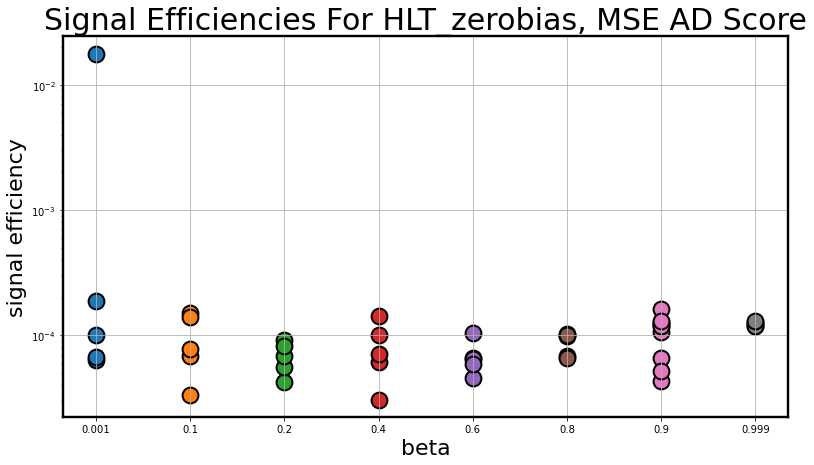

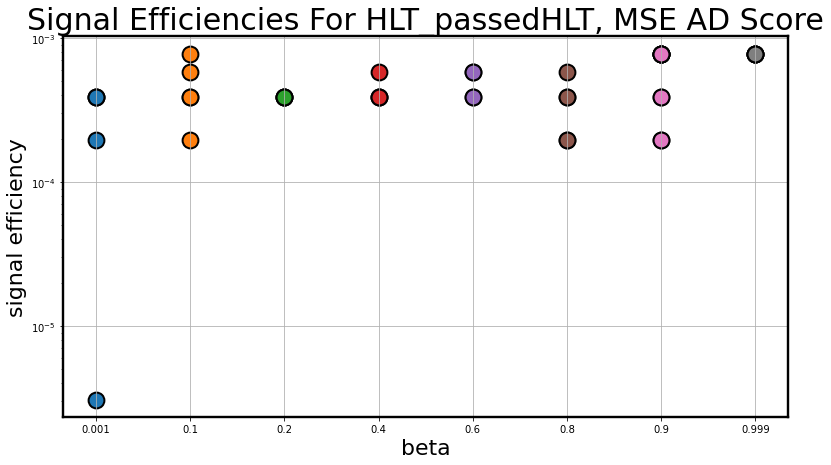

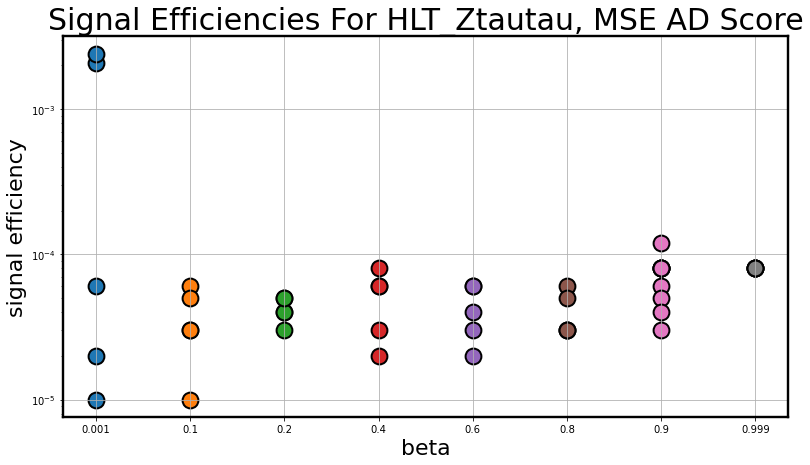

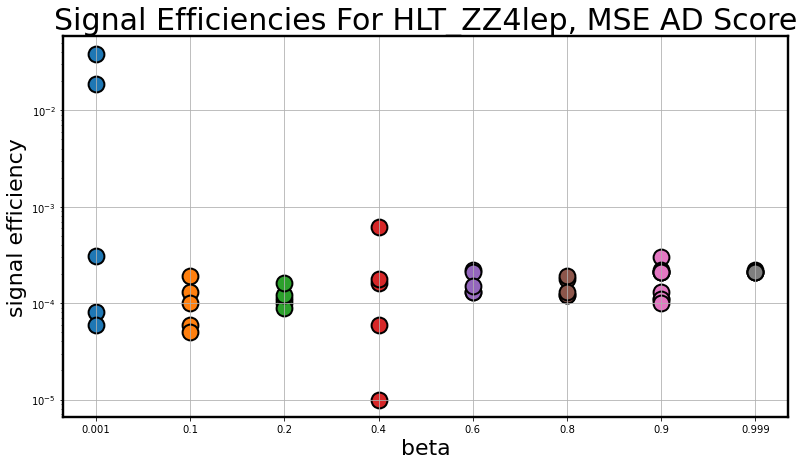

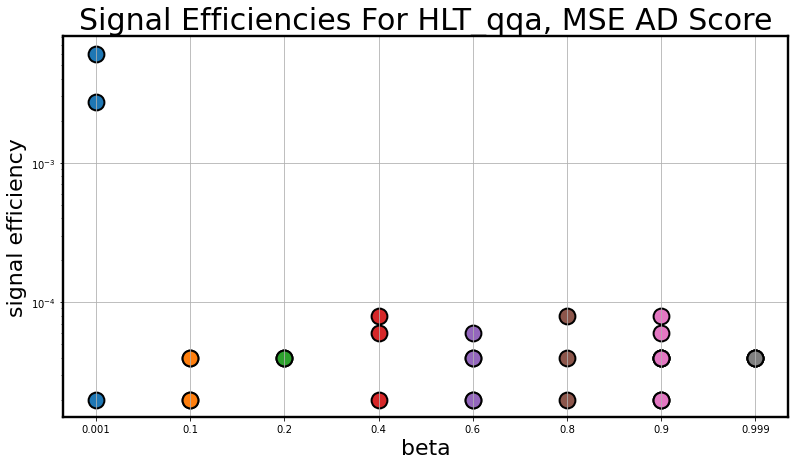

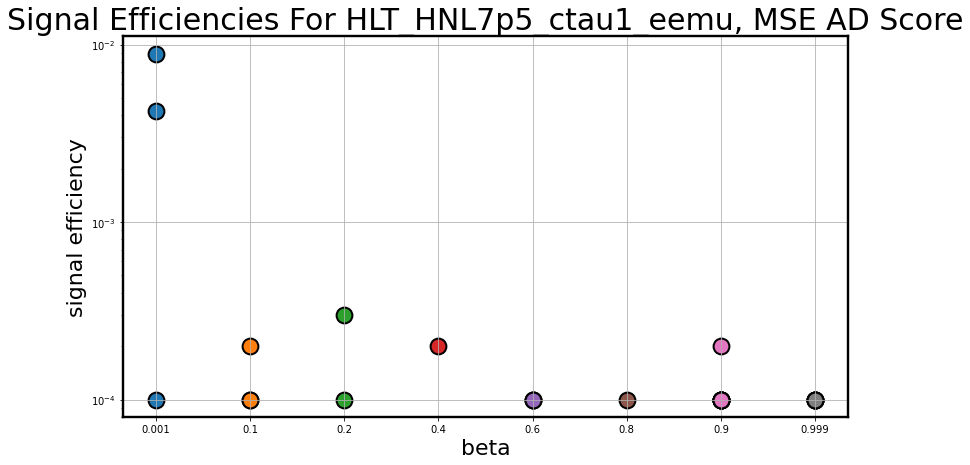

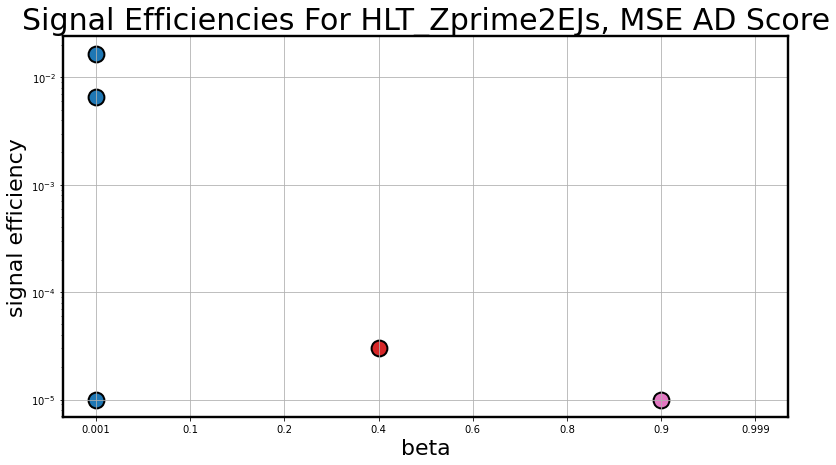

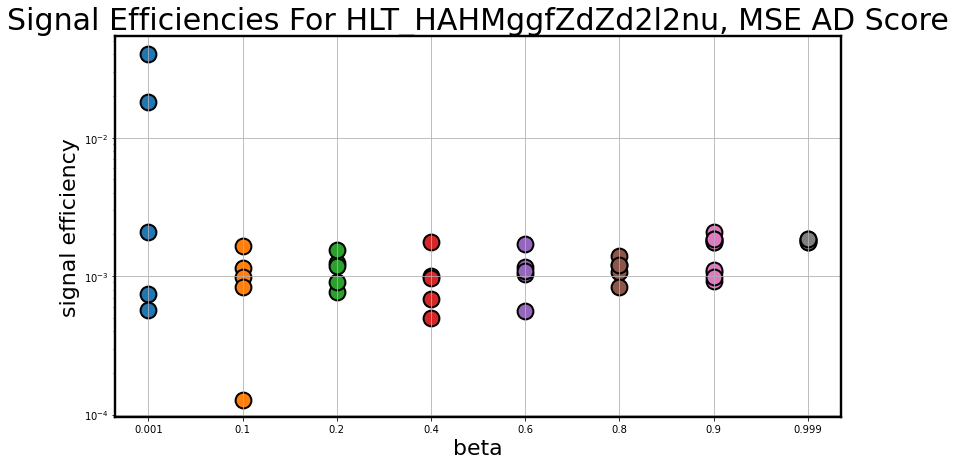

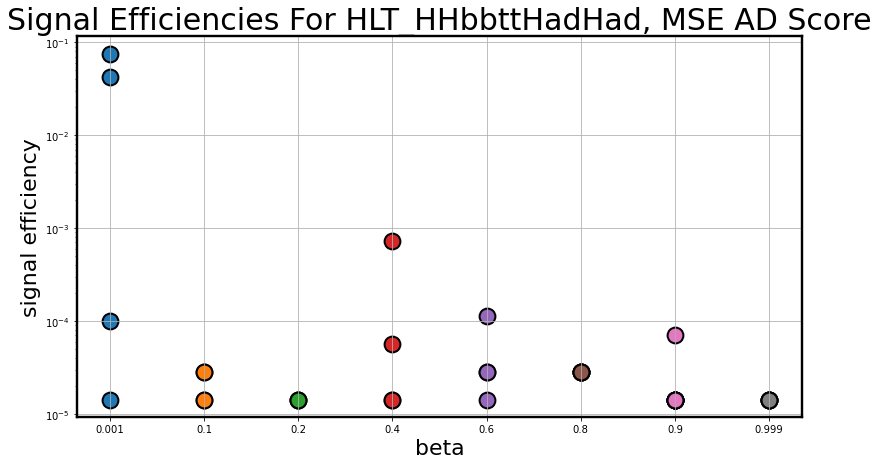

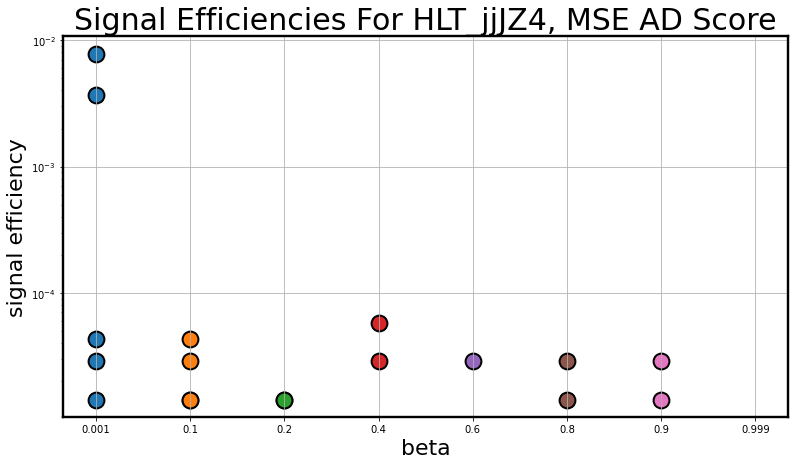

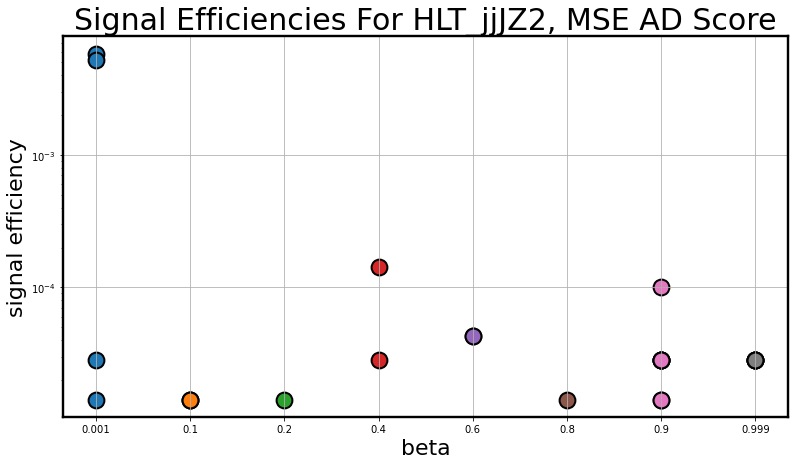

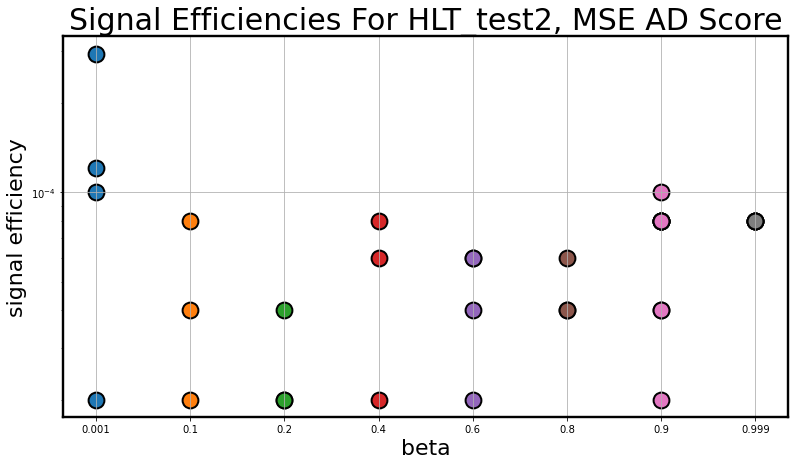

In [21]:
betas = [0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.999]
plt.rcParams['axes.linewidth'] = 2.4

signal_names = next(iter(signal_efficiencies_MSE.values())).keys()

for signal_name in signal_names:
    plt.figure(figsize=(13, 7))
    plt.xticks(ticks=np.arange(len(betas)), labels=betas)
    for i, BETA in enumerate(betas):
        TPRs = []
        
        for model_tag, TPR_dict in signal_efficiencies_MSE.items():
            #for data_tag, TPR in TPR_dict.items():
            if model_tag.startswith(f'HLT_beta{BETA}'):
                TPRs.append(TPR_dict[signal_name])
        
        plt.scatter(i*np.ones(len(TPRs)), TPRs, s=250, edgecolors='k', linewidth=2)
    
    plt.yscale('log')
    plt.ylabel('signal efficiency', fontsize=22)
    plt.xlabel('beta', fontsize=22)
    plt.title(f"Signal Efficiencies For {signal_name}, MSE AD Score", fontsize=30)
    plt.grid()
    #plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

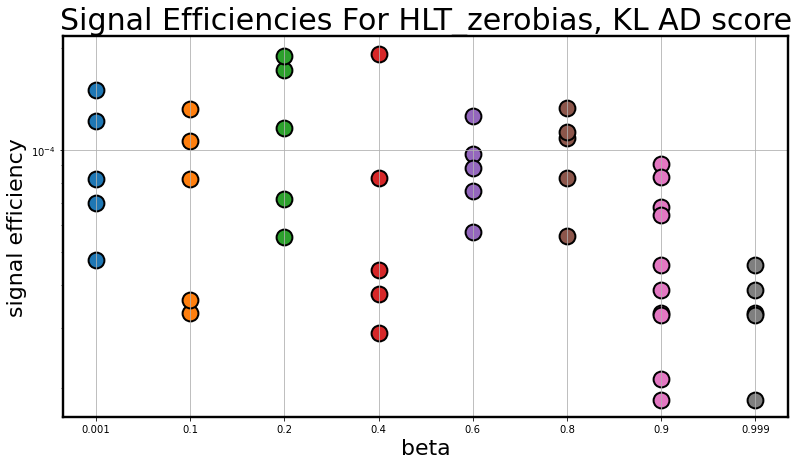

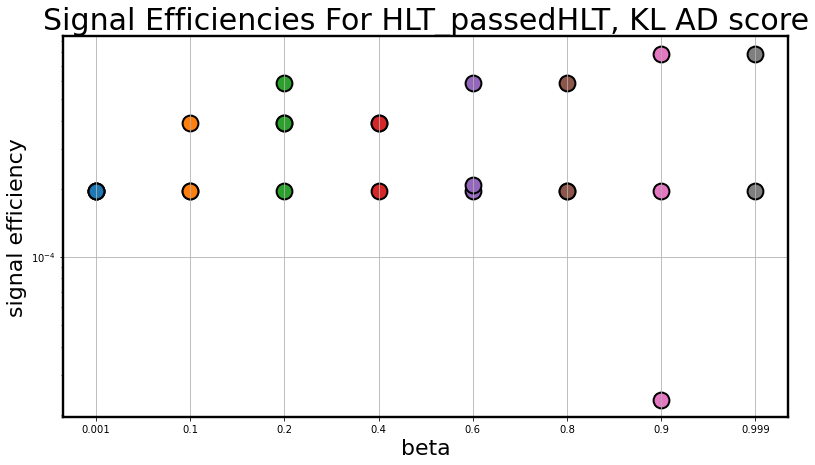

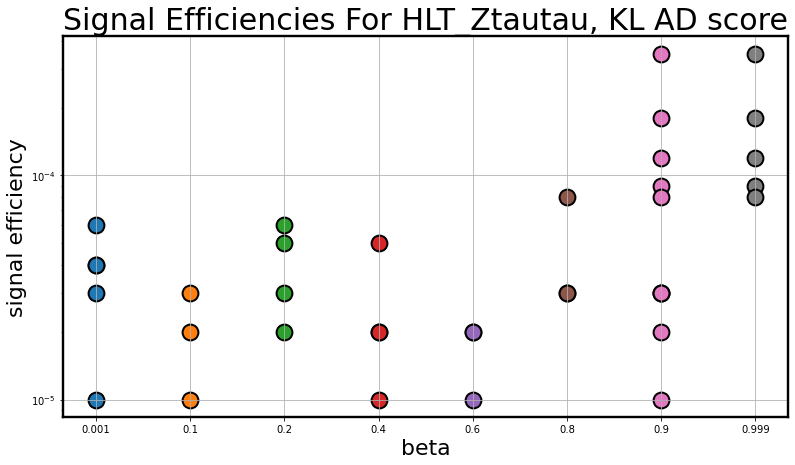

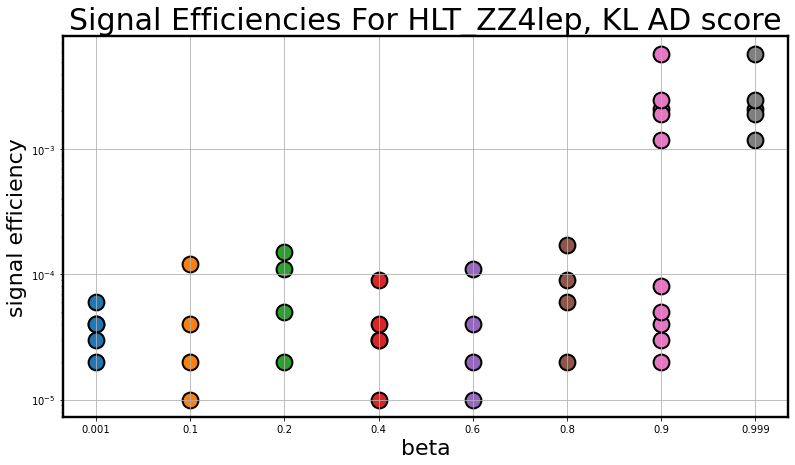

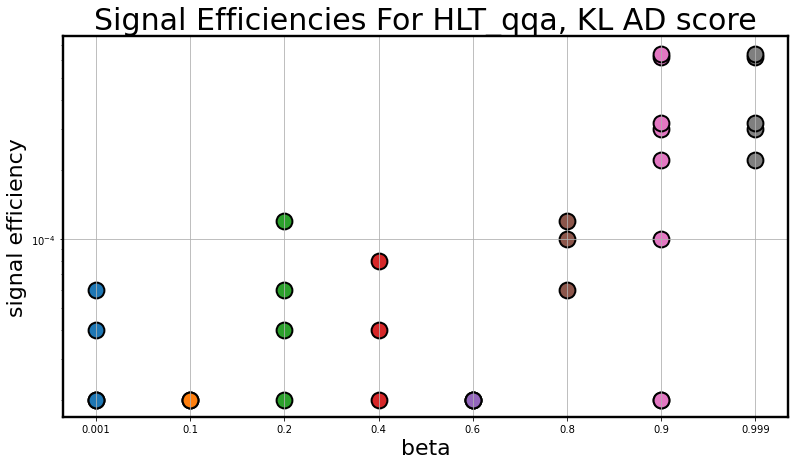

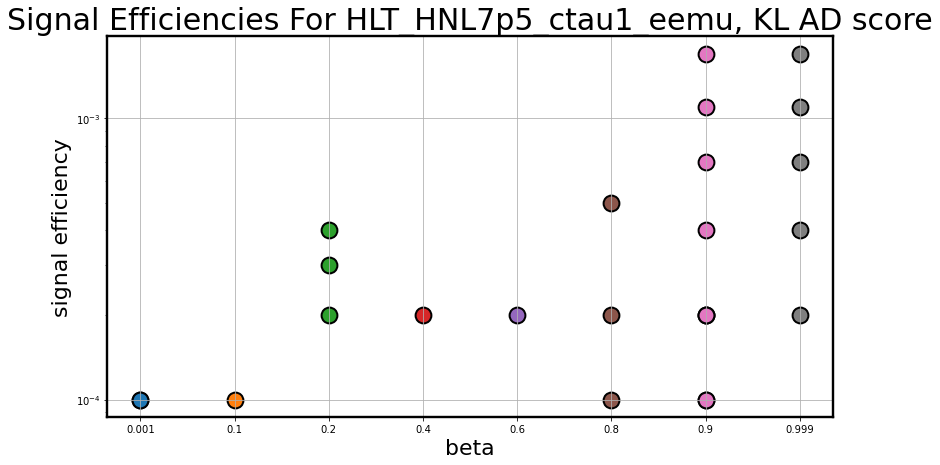

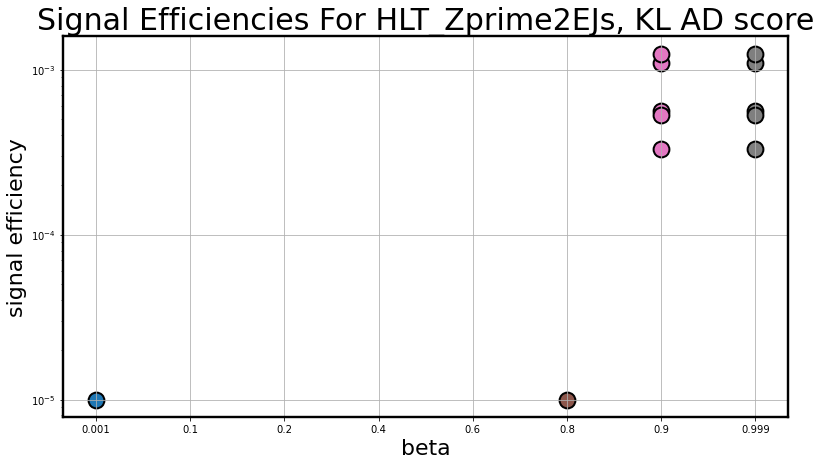

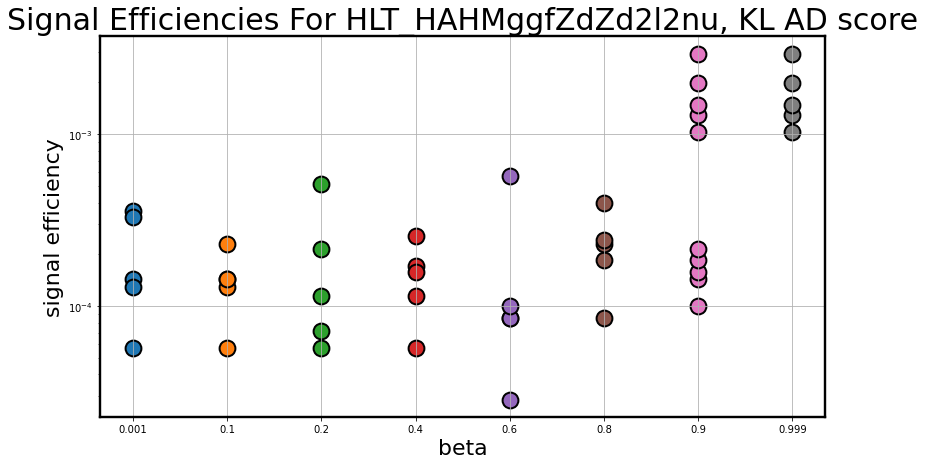

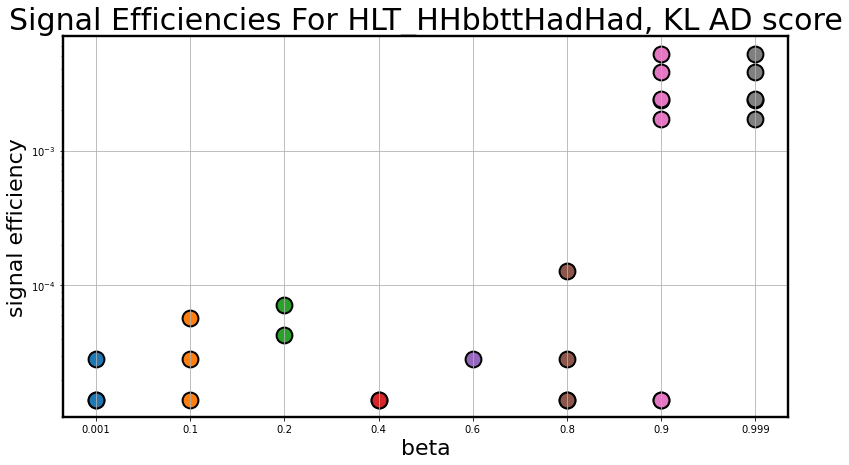

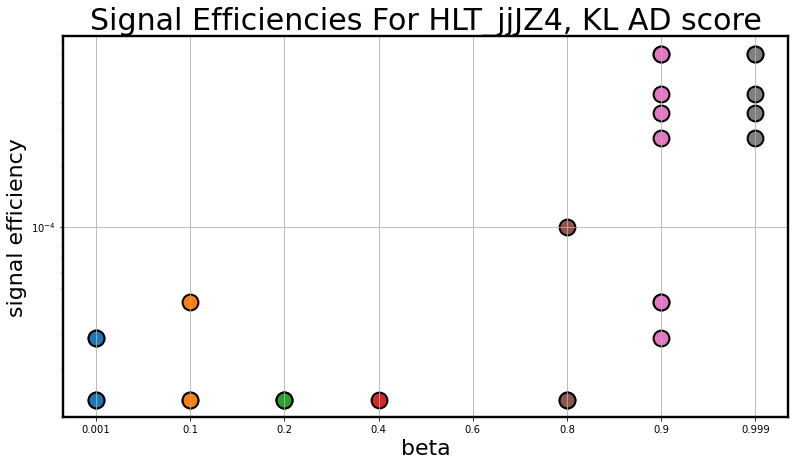

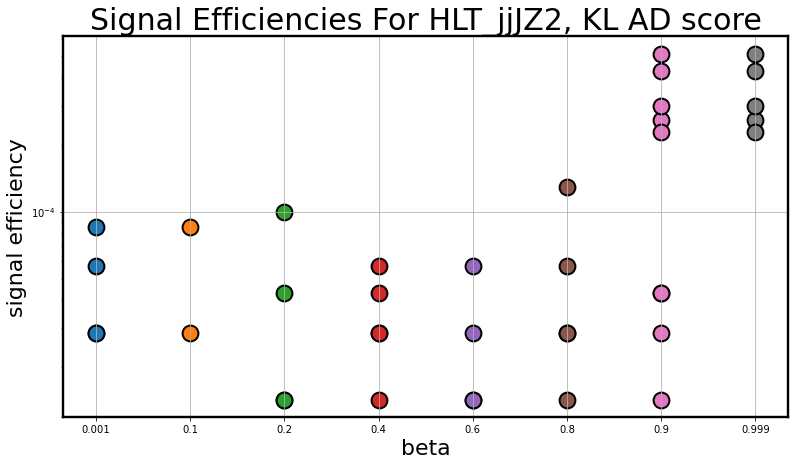

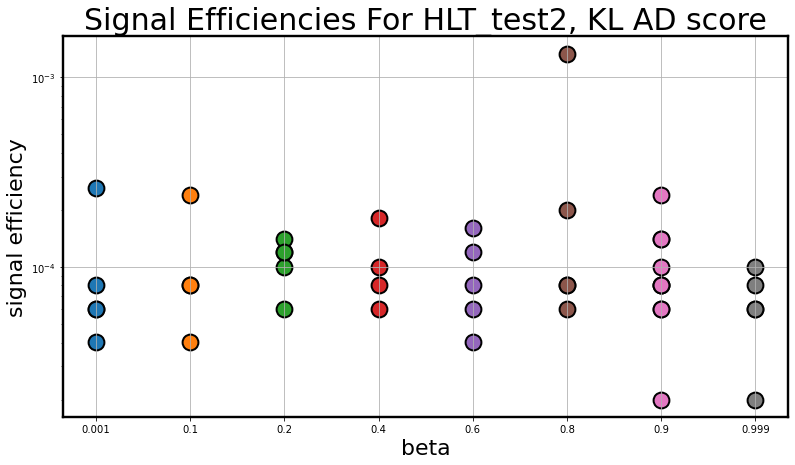

In [22]:
betas = [0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.999]
plt.rcParams['axes.linewidth'] = 2.4

signal_names = next(iter(signal_efficiencies_KL.values())).keys()

for signal_name in signal_names:
    plt.figure(figsize=(13, 7))
    plt.xticks(ticks=np.arange(len(betas)), labels=betas)
    for i, BETA in enumerate(betas):
        TPRs = []
        
        for model_tag, TPR_dict in signal_efficiencies_KL.items():
            #for data_tag, TPR in TPR_dict.items():
            if model_tag.startswith(f'HLT_beta{BETA}'):
                TPRs.append(TPR_dict[signal_name])
        
        plt.scatter(i*np.ones(len(TPRs)), TPRs, s=250, edgecolors='k', linewidth=2)
    
    plt.yscale('log')
    plt.ylabel('signal efficiency', fontsize=22)
    plt.xlabel('beta', fontsize=22)
    plt.title(f"Signal Efficiencies For {signal_name}, KL AD score", fontsize=30)
    plt.grid()
    #plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

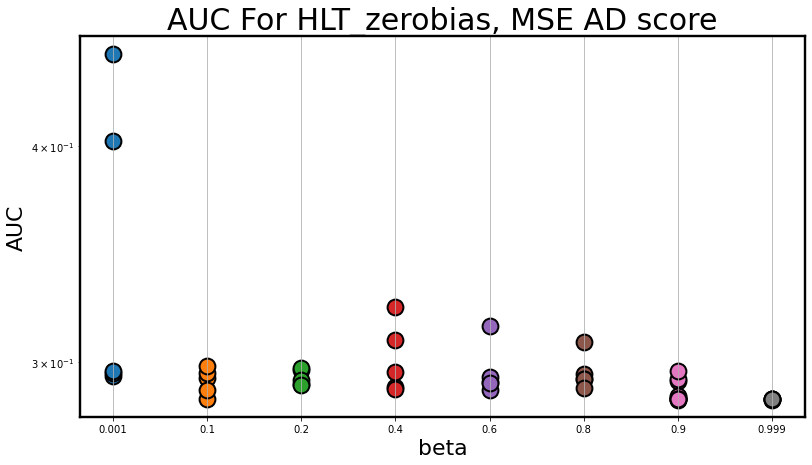

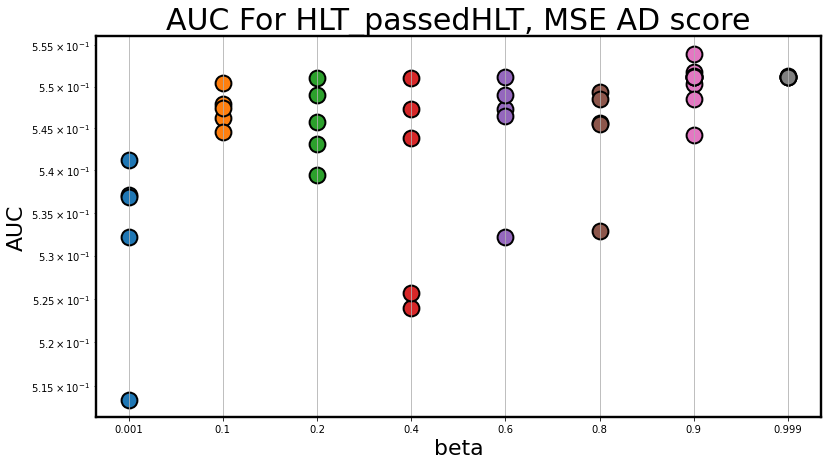

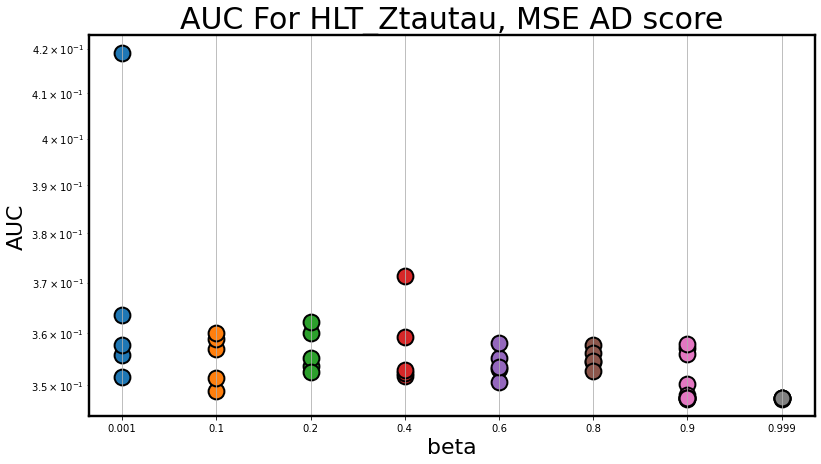

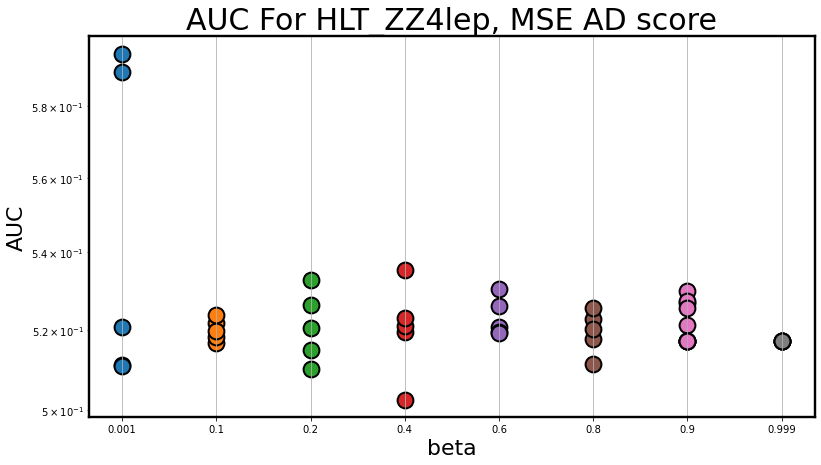

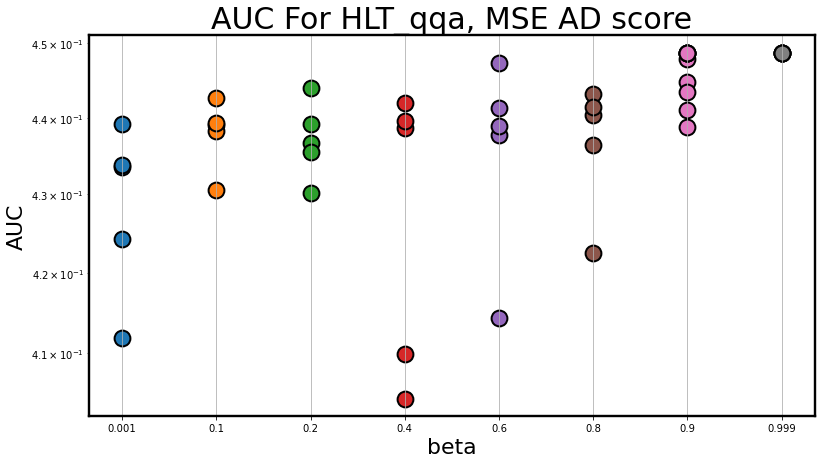

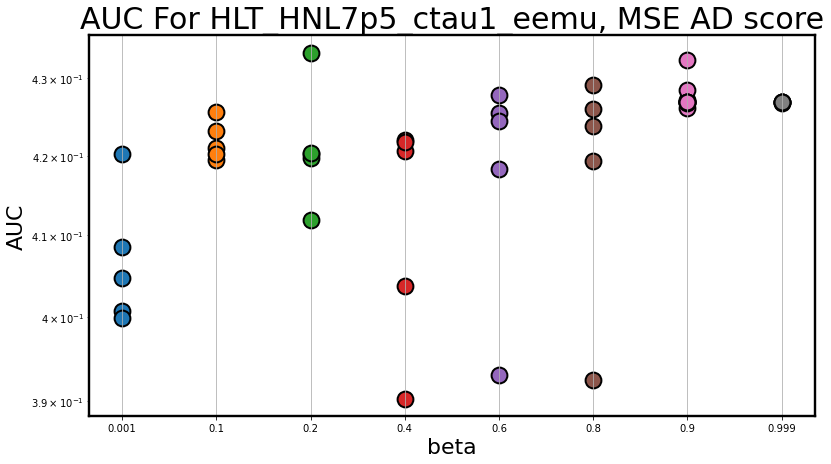

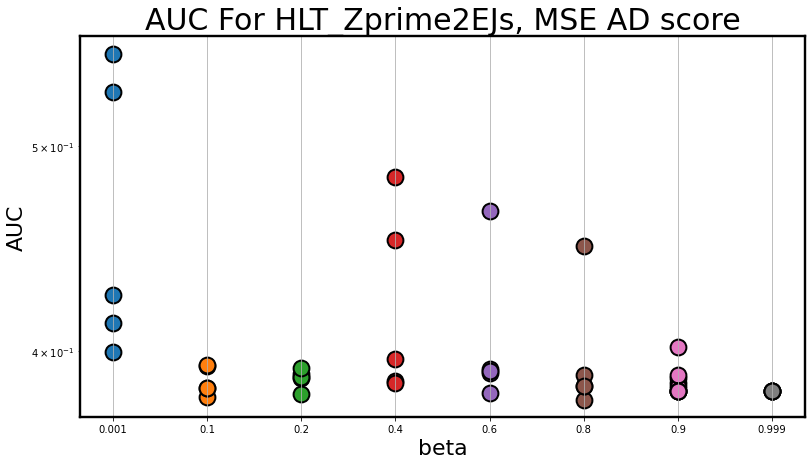

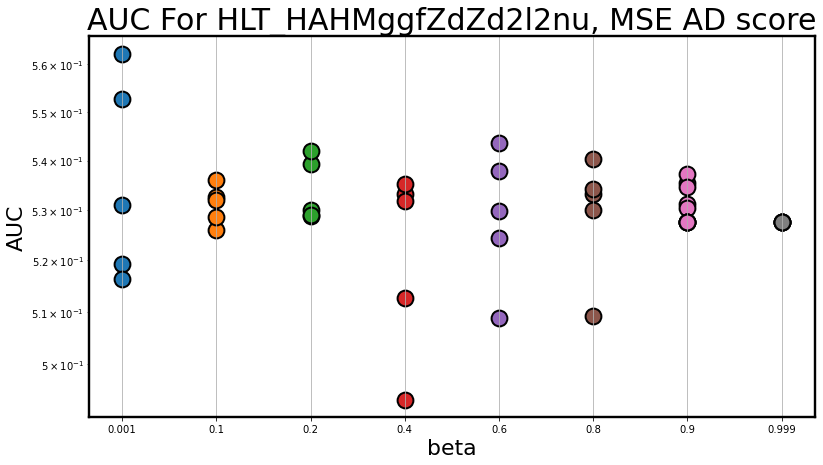

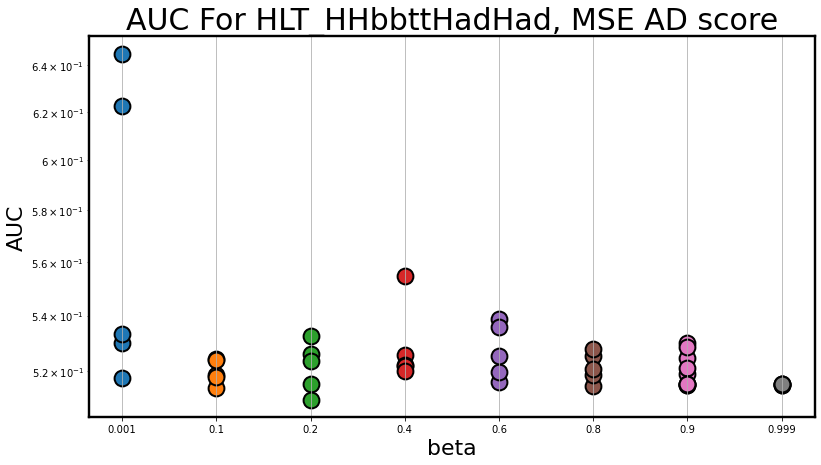

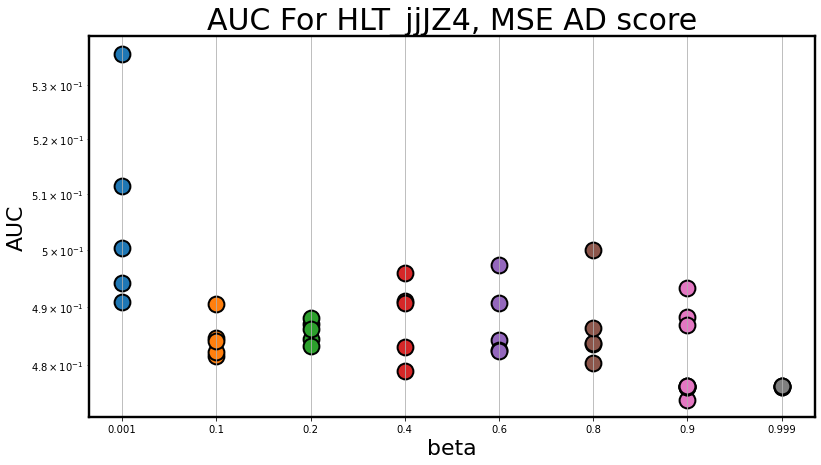

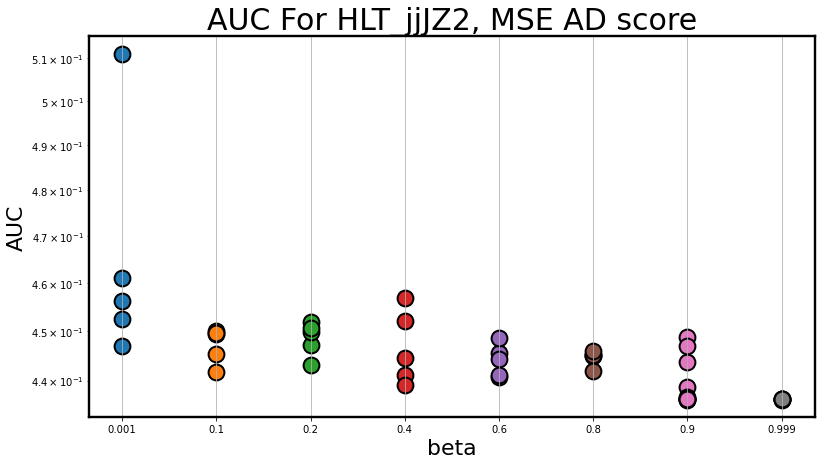

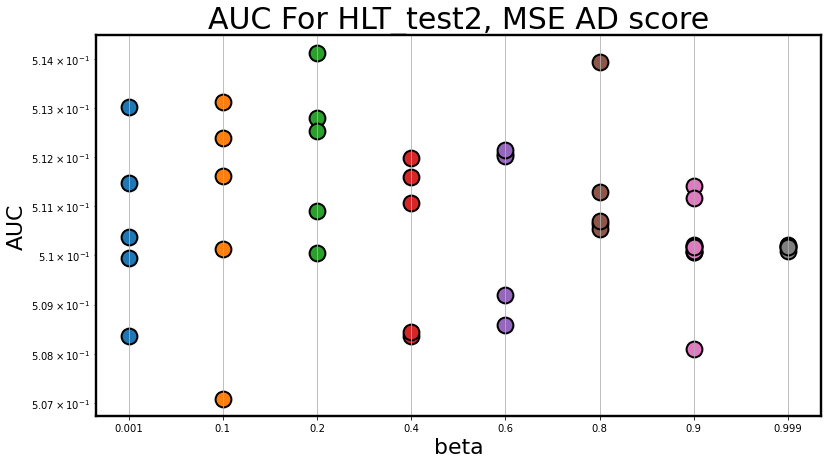

In [23]:
betas = [0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.999]
plt.rcParams['axes.linewidth'] = 2.4

signal_names = next(iter(AUCs_MSE.values())).keys()

for signal_name in signal_names:
    plt.figure(figsize=(13, 7))
    plt.xticks(ticks=np.arange(len(betas)), labels=betas)
    for i, BETA in enumerate(betas):
        aucs = []
        
        for model_tag, AUC_dict in AUCs_MSE.items():
            #for data_tag, TPR in TPR_dict.items():
            if model_tag.startswith(f'HLT_beta{BETA}'):
                aucs.append(AUC_dict[signal_name])
        
        plt.scatter(i*np.ones(len(aucs)), aucs, s=250, edgecolors='k', linewidth=2)
    
    plt.yscale('log')
    plt.ylabel('AUC', fontsize=22)
    plt.xlabel('beta', fontsize=22)
    plt.title(f"AUC For {signal_name}, MSE AD score", fontsize=30)
    plt.grid()
    #plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

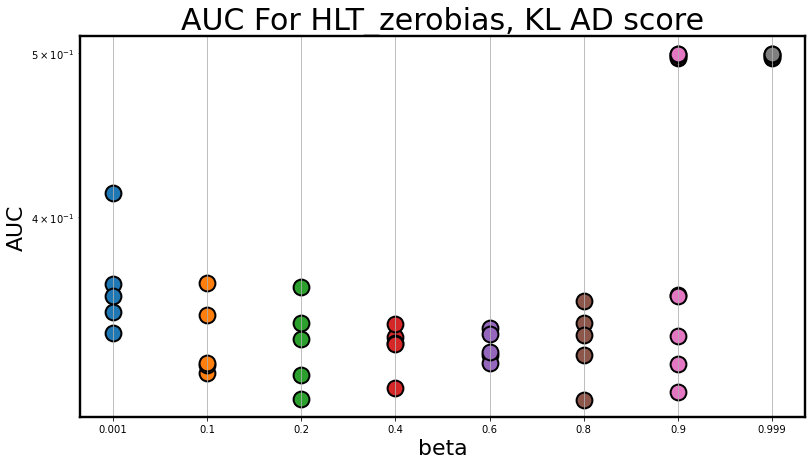

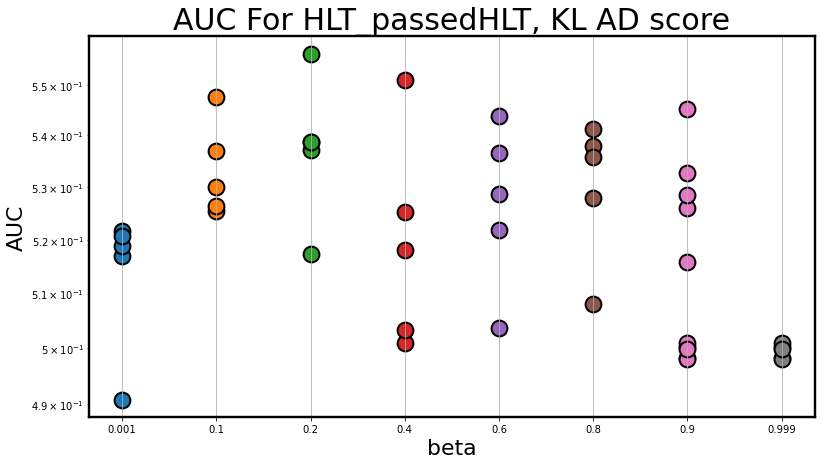

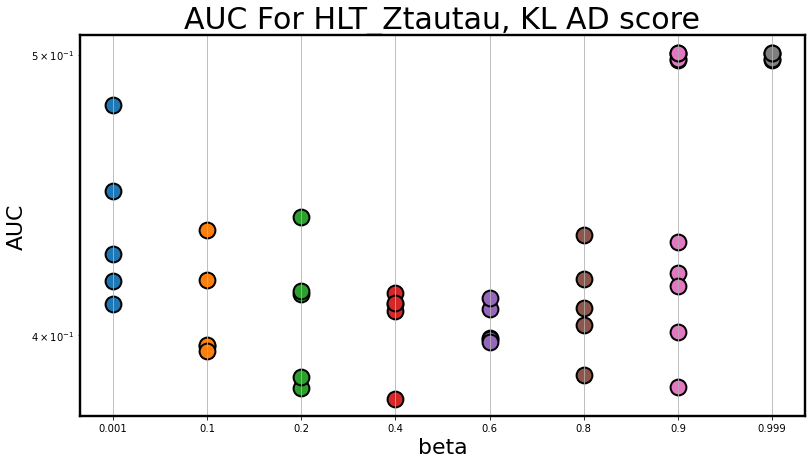

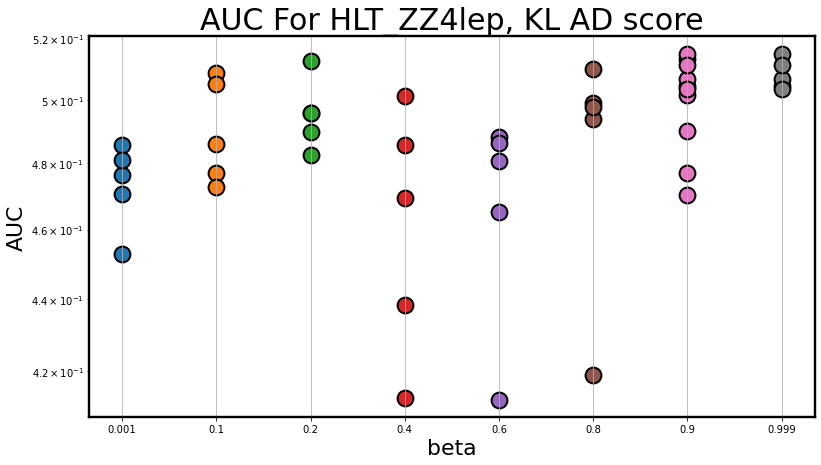

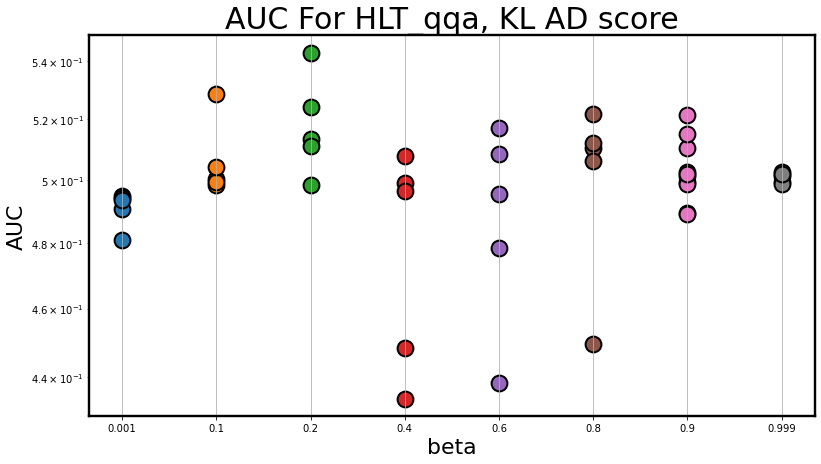

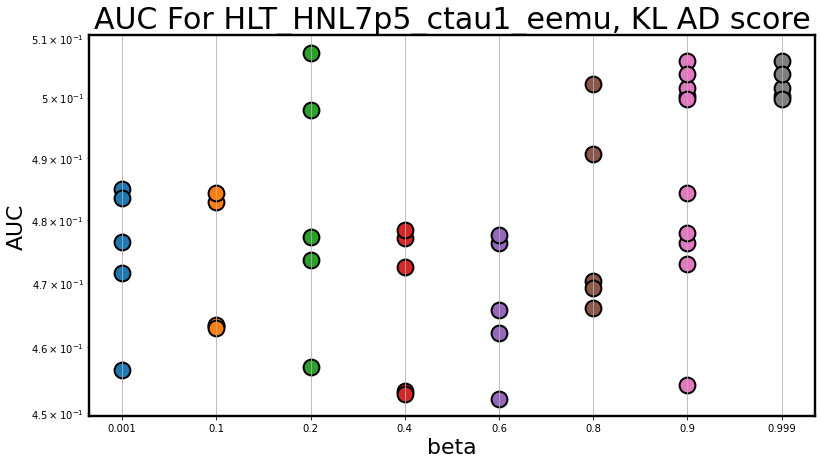

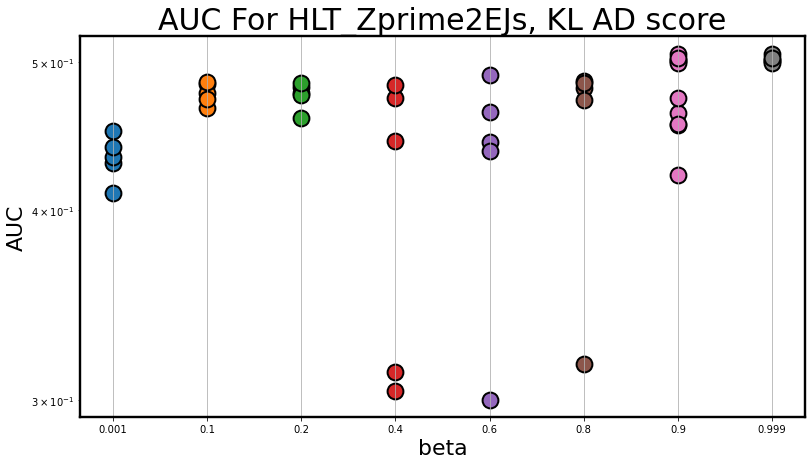

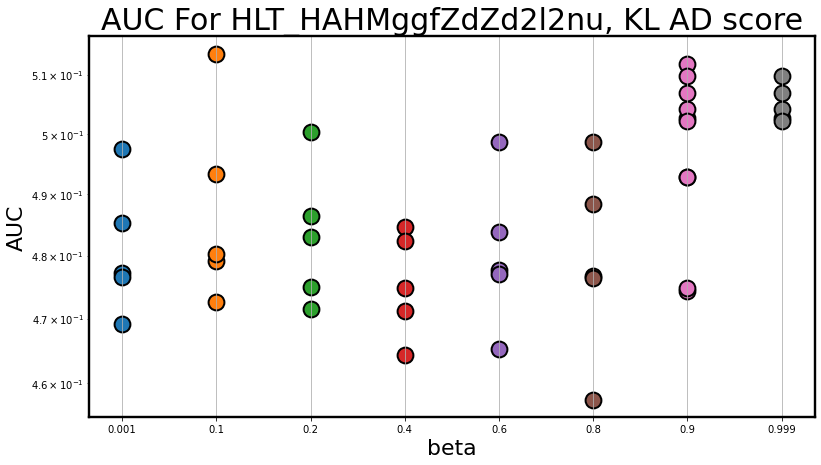

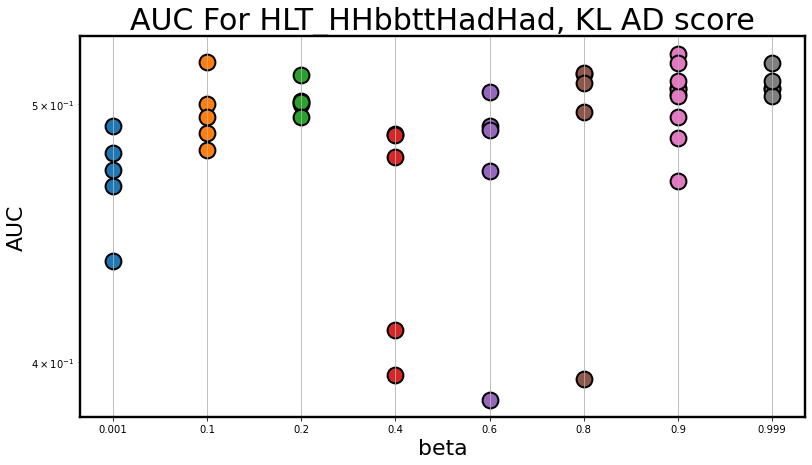

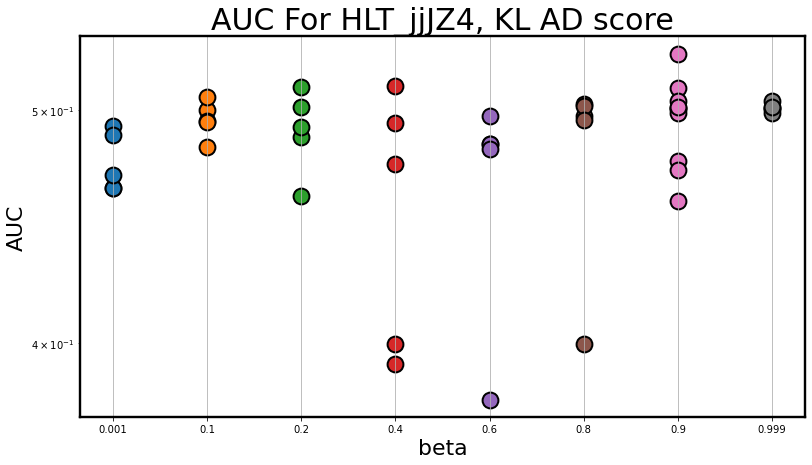

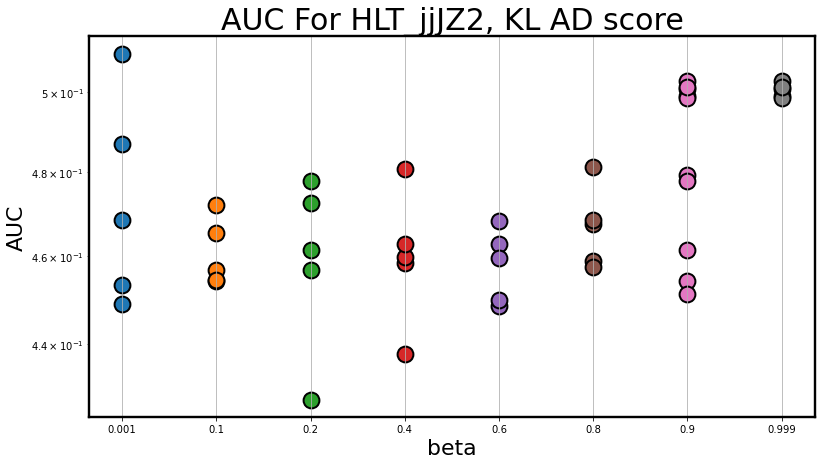

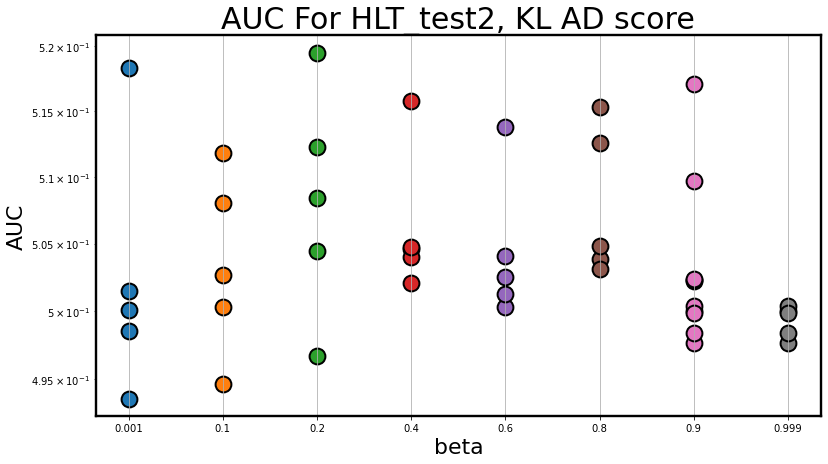

In [24]:
betas = [0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.999]
plt.rcParams['axes.linewidth'] = 2.4

signal_names = next(iter(AUCs_KL.values())).keys()

for signal_name in signal_names:
    plt.figure(figsize=(13, 7))
    plt.xticks(ticks=np.arange(len(betas)), labels=betas)
    for i, BETA in enumerate(betas):
        aucs = []
        
        for model_tag, AUC_dict in AUCs_KL.items():
            #for data_tag, TPR in TPR_dict.items():
            if model_tag.startswith(f'HLT_beta{BETA}'):
                aucs.append(AUC_dict[signal_name])
        
        plt.scatter(i*np.ones(len(aucs)), aucs, s=250, edgecolors='k', linewidth=2)
    
    plt.yscale('log')
    plt.ylabel('AUC', fontsize=22)
    plt.xlabel('beta', fontsize=22)
    plt.title(f"AUC For {signal_name}, KL AD score", fontsize=30)
    plt.grid()
    #plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()